In [348]:
%%javascript
try {
  require(['base/js/utils'], function (utils) {
    utils.load_extension('code_prettify/code_prettify');
    utils.load_extension('collapsible_headings/main'); 
    utils.load_extension('codefolding/edit'); 
    utils.load_extension('codefolding/main'); 
    utils.load_extension('execute_time/ExecuteTime');   
    utils.load_extension('toc2/main'); 
  });
}
catch (err) {
  console.log('toc2 load error:', err);
}

<IPython.core.display.Javascript object>

In [349]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


# Status

## Status
* Fitting of PSF with oversampling and modeeling of PSF as circle (fiber image) and bivariate Gaussian implemented.
* Mdeling by 5-th degree Chebychev and fibre to fiber offset seems to work well.
* PSF based extraction of arcframes seems to work reasonably well.
* Showing column normlized extracted arc frames in ds9 shows no significant residual features around emission lines.

## Next tests
* Look and column mean subtracted, extracted arc frame. Check for residuals.
* Extract twilight. See if we can fix the y offset and use the twilight for flatfielding.

## Todo
* Implement moving window spectral extraction.

In [350]:
from astropy.io import fits
from astropy.stats import biweight_location, biweight_midvariance
from matplotlib import pyplot as plt
import numpy as np
import matplotlib
%matplotlib inline

In [351]:
farc = "/Users/nevencaplar/Documents/PFS/Max/data/masterarc.fits.gz"
fFearc = "/Users/nevencaplar/Documents/PFS/Max/data/Femasterarc.fits.gz"
farcpeaks = "/Users/nevencaplar/Documents/PFS/Max/data/masterflat.arcpeaks"

ftwi = "/Users/nevencaplar/Documents/PFS/Max/data/mastertwi.fits.gz"
fFetwi = "/Users/nevencaplar/Documents/PFS/Max/data/Femastertwi.fits.gz"
farcpeaks = "/Users/nevencaplar/Documents/PFS/Max/data/masterflat.arcpeaks"

arc = fits.getdata(farc)
fearc = fits.getdata(fFearc)
twi = fits.getdata(ftwi)
fetwi = fits.getdata(fFetwi)

In [352]:
#ffsci=!ls redux/20170327/evw03002?.fits.gz
#sc_cube = np.array( [fits.getdata(f) for f in ffsci] )
#sci = biweight_location(sc_cube, axis=0)
#m = np.median(sc_cube, axis=0)
#ii = np.isnan( sci )
#sci[ii] = m[ii]

In [353]:
# van der Marel & Franx (1993)
def H3(x):
    return 1./np.sqrt(6.) * ( 2 * np.sqrt(2.) * x**3. - 3. * np.sqrt(2.)*x)
 
def H4(x):
    return 1./np.sqrt(24.) * (4.*x**4 - 12.*x**2 + 3.)

#generic gaussian, with h3 and h4 moments
def gauss_hermite(mu, sigma, h3, h4, x):
   gofx = 1./(sigma * np.sqrt(2. * np.pi) ) * np.exp( -(x-mu)**2./(2. * sigma**2.))
   return gofx * (1. + h3*H3( (x-mu)/sigma ) + h4*H4( (x-mu)/sigma ) )


# bivariate gaussian
def biv_gauss(x0,y0,sigma,ell,alpha,xx,yy):
    _xx = xx*np.cos(alpha) - yy*np.sin(alpha)
    _yy = yy*np.sin(alpha) + xx*np.cos(alpha)
    rsq = np.sqrt( (xx-x0)**2. + ((yy-y0)*(1.-ell))**2. )
    return np.gauss(sigma, rsq)

# bivariate gaussian
def biv_gauss_herm(x0,y0,sigma,h3, h4, ell, alpha,xx,yy):
    _xx = xx*np.cos(alpha) - yy*np.sin(alpha)
    _yy = yy*np.sin(alpha) + xx*np.cos(alpha)
    rr = np.sqrt( (xx-x0)**2. + ((yy-y0)*(1.-ell))**2. )
    return gauss_hermite(0., sigma, h3, h4, rr )


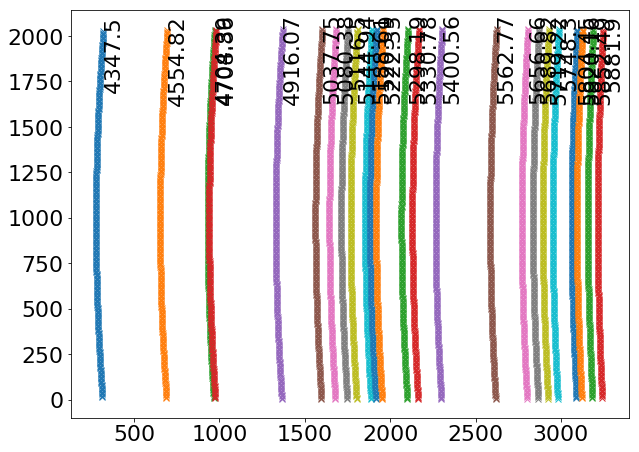

In [354]:
# read arcpeak locations (from prior deformer run)
import re
arcpeaks = []
with open(farcpeaks) as f:
    ll = f.readlines()
for l in ll:
    if l.startswith("#"): continue
    expr = r"circle\(((?:\d*\.)?\d+),((?:\d*\.)?\d+)"
    m = re.search(expr, l)
    x  = float(m.group(1)) - 1.
    y  = float(m.group(2)) - 1.
    #print x,y
    arcpeaks.append( [x,y] )
 
arcpeaks = np.array(arcpeaks)

# build dict from arcpeaks
from astropy.io import ascii
from collections import OrderedDict

lines = ascii.read("/Users/nevencaplar/Documents/PFS/Max/lrlines.Mar17")
arcpeaks_dict = OrderedDict()

for i,l in enumerate(list(lines['col1'])):
     arcpeaks_dict[l] = arcpeaks[i*267:(i+1)*267]

f = plt.figure(figsize=[10,7.5])
for l in  arcpeaks_dict:
    pp = arcpeaks_dict[l]
    plt.plot(pp[:,0],pp[:,1],'x')
    plt.text(pp[0,0],pp[0,1],l,rotation=90.)



# implement oversampling

In [355]:
def oversampleGrid(X,Y,samplef = 4):

    Nx     = X.shape[1]
    Ny     = Y.shape[0]
    xstart = X[0,0]
    ystart = Y[0,0]
    xx_os = np.linspace(-0.5 + xstart, (Nx-1) + 0.5 + xstart, (Nx*samplef +1 ))[:-1] + 1./(samplef*2.)
    yy_os = np.linspace(-0.5 + ystart, (Ny-1) + 0.5 + ystart, (Ny*samplef +1 ))[:-1] + 1./(samplef*2.)

    X_os,Y_os = np.meshgrid(xx_os,yy_os)
    return X_os,Y_os

def downsampleData(xx,yy, X_os, Y_os, highres):
    lowres = np.zeros([yy.shape[0],xx.shape[0]])
    for i,x in enumerate(xx):
        for j,y in enumerate(yy):
            ii =  (X_os > x-.5) * (X_os < x+.5)
            ii *= (Y_os > y-.5) * (Y_os < y+.5)
            #lowres[j,i] = np.mean( highres[ii] )
            lowres[j,i] = np.sum( highres[ii] )
    return lowres

# fit fixed round fiber tip image convolved with a variable, bivarate gaussian

In [9]:
from scipy.signal import fftconvolve 

def peval(p, X,Y,samplef, normf=np.sum):
    A, BG, mux, muy, sigmax, sigmay, sigmaxy, tA = p

    # image of the fiber end
    ell = 0.06
    R   = 1.88

    s     = (np.ceil(R))
    _xx   = np.arange(-s,s+1,1./samplef)
    _X,_Y = np.meshgrid(_xx,_xx)
    rrsq  = (_X )**2. + (_Y*(1.-ell))**2.
    im    = np.array(rrsq <= (R)**2., dtype=float) 
    im    = im/normf(im.flatten())

    # optical PSF kernel
    G = matplotlib.mlab.bivariate_normal(X, Y, sigmax=sigmax, sigmay=sigmay, mux=mux, muy=muy, sigmaxy=sigmaxy)
    
    # convolved image
    cim = fftconvolve(G, im, mode='same')
    cim = cim/normf(cim.flatten())

    if tA > 0.: # don't bother generating a model trace if it's amplitude is zero anyways.
        # also model the trace with the PSF convolved fiber tip image
        trace = np.zeros_like(X)
        for x in np.arange(X.min(),X.max(),1./2.):
            t = matplotlib.mlab.bivariate_normal(X, Y, sigmax=sigmax, sigmay=sigmay, mux=x, muy=muy, sigmaxy=sigmaxy)
            ct = fftconvolve(t, im, mode='same')
            ct = ct/normf(ct.flatten())
            trace += ct

        return A * cim + BG + tA  * trace
    else:
        return A * cim + BG


def resid(p, X, Y, Z, dZ, samplef):
    if samplef == 1:
        X_os,Y_os = X, Y
    else:
        X_os,Y_os = oversampleGrid(X,Y,samplef = samplef)
    highres_model = peval(p,X_os,Y_os,samplef)
    xx = X[0,:]
    yy = Y[:,0]
    if samplef == 1:
        lowres_model = highres_model
    else:
        lowres_model = downsampleData(xx, yy, X_os, Y_os, highres_model)
    return ((lowres_model - Z)/dZ).flatten()

## single fit

In [356]:
#import mfutils
from scipy.optimize import least_squares
def fit_yshift(subim, model, NCUT=2, PLOT=False):
    """
    Fit offset between model trace and data trace through fitting two gaussians.
    """
    def peval(p, yy_):
        g = p[0] * mfutils.gauss(p[1],p[2], yy_)
        #g = g/np.sum(g)
        return g

    def resid(p, subim, yy_, NCUT=2):
        m = peval(p, yy_)
        return ( np.mean(subim,axis=1)-m)[NCUT:-NCUT]
    
    ysize = subim.shape[0]
    yy_ = np.arange(ysize,dtype=float)
    #yy_ -= np.mean(yy_)
    cdata = np.mean(subim,axis=1)
    cmodel = np.mean(model,axis=1)
    #print yy_
    
    #p0 = [np.sum(cdata), np.mean(cdata), np.std(cdata)]
    p0 = [np.sum(cdata), 3.5, 2.]
    #print p0
    fitdata = least_squares(resid, p0, args=(subim,  yy_, NCUT))
    #print fitdata.x
    #p0 = [np.sum(cmodel), np.mean(cmodel), np.std(cmodel)]
    p0 = [np.sum(cmodel), 3.5, 2.]
    #print p0
    fitmodel = least_squares(resid, p0, args=(model,  yy_, NCUT))
    #print fitmodel.x
    
    yshift = fitdata.x[1] - fitmodel.x[1]
    print("yshift from Gaussfit is {:.3f} px".format(yshift))
    
    if PLOT:
        f=plt.figure(figsize=[5,5])
        plt.plot(yy_, cdata,label="data",color='k')
        plt.plot(yy_, peval(fitdata.x, yy_),label="fit to data",color='k',ls=":")
        l = plt.axvline(fitdata.x[1],ls=':', c='k')
        l = plt.legend(loc=2)
        l.draw_frame(False)
        plt.xlabel("y [px]")
        plt.ylabel("counts data")
        plt.twinx()
        plt.plot(yy_, cmodel,label="model",color='b')
        plt.plot(yy_, peval(fitmodel.x, yy_),label="fit to model",color='b',ls=":")
        l = plt.axvline(fitmodel.x[1],ls=':', c='b')
        l = plt.legend(loc=1)
        l.draw_frame(False)
        plt.ylabel("counts model")
        #plt.yscale('log')
        
    
    return yshift, fitdata.x[1],  fitmodel.x[1]
    
#yshift, __, __ = fit_yshift(subim, model, PLOT=True)

xmin = 2293,xmax = 2308
x0 = 7,y0 = 3
   A0 =12056.477, BG0 =1.00, mux0 = 2300.000, muy0 = 3.000, sigmax0 = 0.600, sigmay0 = 0.600, sigmaxy0 =0.100, tA0 =40.000
1.29 s to fit.
standard deviation =  0.9305
equal weight RMS =  11.5347
A =14457.845, BG =0.65, mux = 2300.178, muy = 3.050, sigmax = 0.744, sigmay = 0.560, sigmaxy =-0.051, tA =44.869
dA =125.117, dBG =0.02, dmux = 0.011, dmuy = 0.010, dsigmax = 0.014, dsigmay = 0.013, dsigmaxy =0.012, dtA =2.180


/Users/nevencaplar/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:88: RuntimeWarning: invalid value encountered in log


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

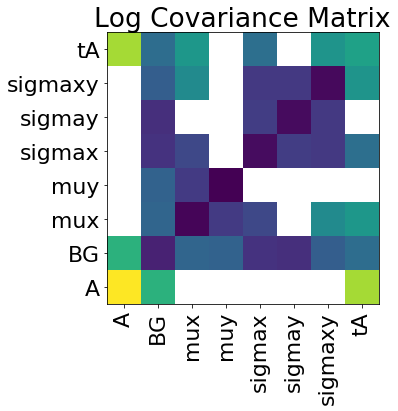

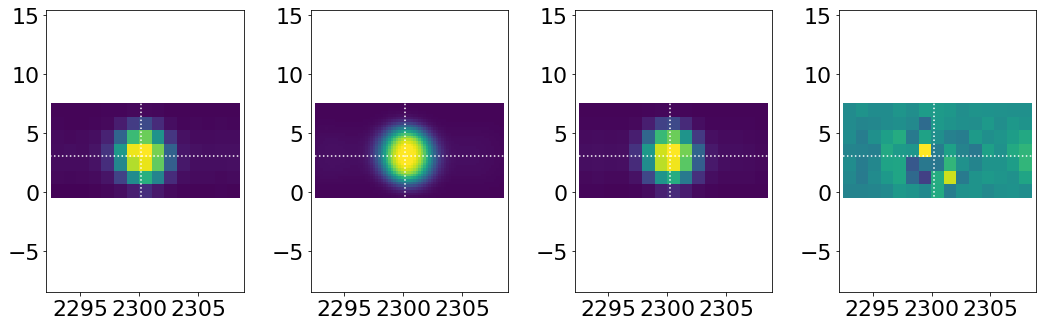

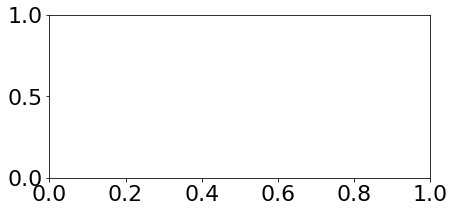

In [363]:
from scipy.optimize import least_squares
import time
% matplotlib inline

xw = 15
yw = 9
RN = 5. / np.sqrt(11.)
samplef = 5

#156 5562.77


#goodpeaks = [4,5,6,11,13,14,15,16,17,18,19,20,21]
goodpeaks = [4,5,6,13,14,15,16,17,18,19,20,21]

fib = 266
#ipeak = 9
xc,yc = arcpeaks_dict[arcpeaks_dict.keys()[ 14 ]][fib]
#xc,yc = arcpeaks_dict[ 5562.77][fib]
#print xc,yc

ymin,ymax = np.max( [int(round(yc)-yw/2.)+1,0] ),np.min( [int(round(yc)+yw/2.)+1, arc.shape[0]] )
xmin,xmax = np.max( [int(round(xc)-xw/2.)+1,0] ),np.min( [int(round(xc)+xw/2.)+1, arc.shape[1]] )


print("xmin = {},xmax = {}".format(xmin,xmax))
subim = arc[ ymin:ymax,xmin:xmax ]


xx = np.arange(xmin,xmax)
yy = np.arange(ymin,ymax)
X,Y = np.meshgrid(xx,yy)



#P0 = [   6.33 , 10., (xw-1.)/2.+xmin,  (yw-1.)/2.+ymin,   0.6, 0.6,  -0.0, 30.]
#P0 = [   6.33 , 0., (xw-1.)/2.+xmin,  (yw-1.)/2.+ymin,   0.6, 0.6,  -0.0, 30.]
y0,x0 = np.unravel_index(subim.argmax(), subim.shape)
print("x0 = {},y0 = {}".format(x0,y0))

P0 = [   subim.max()*10. , 1., x0+xmin,  y0+ymin,   0.6, 0.6,  0.1, 40.]
#P0 = [   subim.max() , 1., x0+xmin,  y0+ymin,   0.6, 0.6,  -0.0, 0.1]

A0, BG0, mux0, muy0, sigmax0, sigmay0, sigmaxy0, tA0 = P0 
print("   A0 ={:.3f}, BG0 ={:.2f}, mux0 = {:.3f}, muy0 = {:.3f}, sigmax0 = {:.3f}, sigmay0 = {:.3f}, sigmaxy0 ={:.3f}, tA0 ={:.3f}".\
  format(A0, BG0, mux0, muy0, sigmax0, sigmay0, sigmaxy0, tA0))
        

#A =3.920, BG =7.90, mux = 1644.110, muy = 1006.652, sigmax = 0.596, sigmay = 0.411, sigmaxy =-0.045, tA =29.771

#dsubim = np.ones_like(subim)
dsubim = np.sqrt(subim + RN**2.)

bounds = ( [0., 0., 0., 0., 0.1, 0.1, -1., 0.], [np.inf, np.inf, 4000., 2100., 2., 2., 1., np.inf]) 

starttime = time.time()
fit = least_squares(resid,P0, args = (X,Y,subim, dsubim, samplef), bounds=bounds )
endtime = time.time()
print("{:.2f} s to fit.".format(endtime-starttime))

p = fit.x
#p = P0

f = plt.figure(figsize=[15,5])

X_os,Y_os = oversampleGrid(X,Y,samplef = samplef)
highres_model = peval(p, X_os,Y_os, samplef)
lowres_model =  downsampleData(xx, yy, X_os, Y_os, highres_model)

dsubim = np.sqrt(subim + RN**2.)
res = resid(p, X, Y, subim, dsubim, samplef)
print ("standard deviation =  {:.4f}".format(np.std(res)))

dsubim = np.ones_like(subim)
res = resid(p, X, Y, subim, dsubim, samplef)
print ("equal weight RMS =  {:.4f}".format(np.std(res)))



A, BG, mux, muy, sigmax, sigmay, sigmaxy, tA = fit.x 

print("A ={:.3f}, BG ={:.2f}, mux = {:.3f}, muy = {:.3f}, sigmax = {:.3f}, sigmay = {:.3f}, sigmaxy ={:.3f}, tA ={:.3f}".\
      format(A, BG, mux, muy, sigmax, sigmay, sigmaxy, tA))



H = fit.jac.T.dot(fit.jac)
f = plt.figure(figsize=[5,5])

plt.imshow(np.log(1./H), origin='bottom')
plt.title("Log Covariance Matrix")
plt.xticks(np.arange(len(fit.x)), ["A", "BG", "mux", "muy", "sigmax", "sigmay", "sigmaxy", "tA"], rotation=90.)
plt.yticks(np.arange(len(fit.x)), ["A", "BG", "mux", "muy", "sigmax", "sigmay", "sigmaxy", "tA"], rotation=0.)

dA, dBG, dmux, dmuy, dsigmax, dsigmay, dsigmaxy, dtA = np.sqrt( (1./H).diagonal() )
print("dA ={:.3f}, dBG ={:.2f}, dmux = {:.3f}, dmuy = {:.3f}, dsigmax = {:.3f}, dsigmay = {:.3f}, dsigmaxy ={:.3f}, dtA ={:.3f}".\
      format(dA, dBG, dmux, dmuy, dsigmax, dsigmay, dsigmaxy, dtA))


f = plt.figure(figsize=[15,5])
ax1 = plt.subplot(1,4,1)
lrextent = [float(xmin)-.5,float(xmax)+.5,float(ymin)-.5,float(ymax)+.5]
#lrextent = [100,200,100,200]
#print "lrextent", lrextent
plt.imshow( subim,vmin=0, vmax=subim.max(),origin="bottom",extent=lrextent)
plt.axvline(mux,c='w',ls=':')
plt.axhline(muy,c='w',ls=':')

ax2 = plt.subplot(1,4,2, sharex=ax1, sharey=ax1)
#hrextent = [X_os.min()-.5/samplef,X_os.max()+.5/samplef,Y_os.min()-.5/samplef,Y_os.max()+.5/samplef]
hrextent = lrextent
plt.imshow( highres_model,vmin=0, vmax=subim.max()/samplef**2.,origin="bottom",extent=hrextent)
plt.axvline(mux,c='w',ls=':')
plt.axhline(muy,c='w',ls=':')

ax3 = plt.subplot(1,4,3, sharex=ax1, sharey=ax1)
plt.imshow(lowres_model,vmin=0, vmax=subim.max(),origin="bottom",extent=lrextent)
plt.axvline(mux,c='w',ls=':')
plt.axhline(muy,c='w',ls=':')

ax4 = plt.subplot(1,4,4, sharex=ax1, sharey=ax1)
plt.imshow(subim-lowres_model,vmin=-subim.max()/20., vmax=subim.max()/20.,origin="bottom",extent=lrextent)
plt.axvline(mux,c='w',ls=':')
plt.axhline(muy,c='w',ls=':')
f.tight_layout()


f = plt.figure(figsize=[15,3])

ax1 = plt.subplot(1,2,1)
plt.plot(subim[yw/2,:],drawstyle='steps-mid', label="data")
plt.plot(lowres_model[yw/2,:],drawstyle='steps-mid', label="model")
plt.xlabel("X")

plt.subplot(1,2,2, sharey=ax1)
plt.plot(subim[:,xw/2],drawstyle='steps-mid', label="data")
plt.plot(lowres_model[:,xw/2],drawstyle='steps-mid', label="model")
plt.xlabel("Y")

l = plt.legend()
f.tight_layout()

#yshift = fit_yshift(subim, lowres_model, PLOT=False)
#p = A, BG, mux , muy + yshift[0], sigmax, sigmay, sigmaxy, tA 
#highres_model = peval(p, X_os,Y_os, samplef)
#lowres_model =  downsampleData(xx, yy, X_os, Y_os, highres_model)
#res = resid(p, X, Y, subim, dsubim, samplef)
#print ("RMS =  {:.4f}".format(np.std(res)))
#fit_yshift(subim, lowres_model, PLOT=True)


In [ ]:
p_test=np.array([ 14457.84464383,      0.65171981,   2300.17759414,      3.05014035,
            0.74370364,      0.55977307,     -0.05095622,     400.86885563])

In [ ]:
highres_model = peval(p_test, X_os,Y_os, samplef)

In [ ]:
plt.imshow(highres_model)
plt.colorbar()

## sample all CCD

In [26]:
from astropy.table import Table, Column
from scipy.optimize import least_squares
% matplotlib inline

if True:
    t = Table(
        names=["wl","fib","A", "dA", "BG", "dBG", "mux", "dmux", "muy", "dmuy", "sigmax", "dsigmax", "sigmay", "dsigmay", "sigmaxy", "dsigmaxy", "tA", "dtA", "stddev", "RMS"],
        dtype=('f4', 'i4', 'f4', 'f4', 'f4', 'f4', 'f4', 'f4', 'f4', 'f4', 'f4', 'f4', 'f4', 'f4', 'f4', 'f4', 'f4', 'f4', 'f4', 'f4'))


xw = 15
yw = 9
RN = 5. / np.sqrt(11.)
wlmin,wlmax = 0.,np.inf

goodpeaks = [4,5,6,13,14,15,16,17,18,19,20,21]


fibers = np.arange(0,267,1)
goodpeaks = [4,5,6,13,14,15,16,17,18,19,20,21]
fibers = [266]
#fibers = [0]
for i,l in  enumerate(arcpeaks_dict):
    
    if not (l >= wlmin and l <= wlmax):
        continue
    if not i in goodpeaks:
        #print("Skipping, not in goodpeaks")
        continue
    
    print("i,l = {}, {}".format(i,l) )
    #print arcpeaks_dict[ l ]
    
    for fib in fibers:
        print("Wavelength {}, {} Fiber {}".format(i,l, fib))
        try:
            xc,yc = arcpeaks_dict[ l ][fib]
            print("   xc,yc = {}, {}".format(xc,yc))

            ymin,ymax = np.max( [int(round(yc)-yw/2.)+1,0] ),np.min( [int(round(yc)+yw/2.)+1, arc.shape[0]] )
            xmin,xmax = np.max( [int(round(xc)-xw/2.)+1,0] ),np.min( [int(round(xc)+xw/2.)+1, arc.shape[1]] )


            subim = arc[ ymin:ymax,xmin:xmax ]


            xx = np.arange(xmin,xmax)
            yy = np.arange(ymin,ymax)
            X,Y = np.meshgrid(xx,yy)

            samplef = 5

            y0,x0 = np.unravel_index(subim.argmax(), subim.shape)
            P0 = [   subim.max()*10. , 1., x0+xmin,  y0+ymin,   0.6, 0.6,  -0.0, 40.]

            A0, BG0, mux0, muy0, sigmax0, sigmay0, sigmaxy0, tA0 = P0 
            print("   A0 ={:.3f}, BG0 ={:.2f}, mux0 = {:.3f}, muy0 = {:.3f}, sigmax0 = {:.3f}, sigmay0 = {:.3f}, sigmaxy0 ={:.3f}, tA0 ={:.3f}".\
              format(A0, BG0, mux0, muy0, sigmax0, sigmay0, sigmaxy0, tA0))

            dsubim = np.sqrt(subim + RN**2.)

            bounds = ( [0., 0., 0., 0., 0.1, 0.1, -1., 0.], [np.inf, np.inf, 4000., 2100., 2., 2., 1., np.inf]) 

            starttime = time.time()
            fit = least_squares(resid,P0, args = (X,Y,subim, dsubim, samplef), bounds=bounds )
            endtime = time.time()
            print("   {:.2f} s to fit.".format(endtime-starttime))

            p = fit.x
            #p = P0

            X_os,Y_os = oversampleGrid(X,Y,samplef = samplef)
            highres_model = peval(p, X_os,Y_os, samplef)
            lowres_model =  downsampleData(xx, yy, X_os, Y_os, highres_model)


            dsubim = np.sqrt(subim + RN**2.)
            stddev = np.std( resid(p, X, Y, subim, dsubim, samplef) )
            #print ("standard deviation =  {:.4f}".format(stddev))

            dsubim = np.ones_like(subim)
            res = resid(p, X, Y, subim, dsubim, samplef)
            #print ("equal weight RMS =  {:.4f}".format(np.std(res)))

            RMS = np.std( lowres_model - subim )



            A, BG, mux, muy, sigmax, sigmay, sigmaxy, tA = fit.x 

            H = fit.jac.T.dot(fit.jac)
            dA, dBG, dmux, dmuy, dsigmax, dsigmay, dsigmaxy, dtA = np.sqrt( (1./H).diagonal() )


            r = (l, fib, A, dA, BG, dBG, mux, dmux, muy, dmuy, sigmax, dsigmax, sigmay, dsigmay, sigmaxy, dsigmaxy, tA, dtA, stddev, RMS)
            t.add_row(r)

            #print("   wl ={:.3f}, fib ={:d}".format(r[0],r[1]) )
            print("   A ={:.3f}, BG ={:.2f}, mux = {:.3f}, muy = {:.3f}, sigmax = {:.3f}, sigmay = {:.3f}, sigmaxy ={:.3f}, tA ={:.3f}, stddev ={:.3f}, RMS ={:.3f}".\
              format(A, BG, mux, muy, sigmax, sigmay, sigmaxy, tA, stddev, RMS))
            print("   dA ={:.3f}, dBG ={:.2f}, dmux = {:.3f}, dmuy = {:.3f}, dsigmax = {:.3f}, dsigmay = {:.3f}, dsigmaxy ={:.3f}, dtA ={:.3f}".\
                  format(dA, dBG, dmux, dmuy, dsigmax, dsigmay, dsigmaxy, dtA))

            if False:
                f = plt.figure(figsize=[5,5])
                plt.imshow(np.log(1./H), origin='bottom')
                plt.title("Log Covariance Matrix")
                plt.xticks(np.arange(len(fit.x)), ["A", "BG", "mux", "muy", "sigmax", "sigmay", "sigmaxy", "tA"], rotation=90.)
                plt.yticks(np.arange(len(fit.x)), ["A", "BG", "mux", "muy", "sigmax", "sigmay", "sigmaxy", "tA"], rotation=0.)

                f = plt.figure(figsize=[15,5])
                ax1 = plt.subplot(1,4,1)
                lrextent = [float(xmin)-.5,float(xmax)+.5,float(ymin)-.5,float(ymax)+.5]
                #lrextent = [100,200,100,200]
                print "lrextent", lrextent
                plt.imshow( subim,vmin=0, vmax=subim.max(),origin="bottom",extent=lrextent)
                plt.axvline(mux,c='w',ls=':')
                plt.axhline(muy,c='w',ls=':')

                ax2 = plt.subplot(1,4,2, sharex=ax1, sharey=ax1)
                #hrextent = [X_os.min()-.5/samplef,X_os.max()+.5/samplef,Y_os.min()-.5/samplef,Y_os.max()+.5/samplef]
                hrextent = lrextent
                plt.imshow( highres_model,vmin=0, vmax=subim.max()/samplef**2.,origin="bottom",extent=hrextent)
                plt.axvline(mux,c='w',ls=':')
                plt.axhline(muy,c='w',ls=':')

                ax3 = plt.subplot(1,4,3, sharex=ax1, sharey=ax1)
                plt.imshow(lowres_model,vmin=0, vmax=subim.max(),origin="bottom",extent=lrextent)
                plt.axvline(mux,c='w',ls=':')
                plt.axhline(muy,c='w',ls=':')

                ax4 = plt.subplot(1,4,4, sharex=ax1, sharey=ax1)
                plt.imshow(subim-lowres_model,vmin=-subim.max()/20., vmax=subim.max()/20.,origin="bottom",extent=lrextent)
                plt.axvline(mux,c='w',ls=':')
                plt.axhline(muy,c='w',ls=':')
                f.tight_layout()


                f = plt.figure(figsize=[15,3])

                ax1 = plt.subplot(1,2,1)
                plt.plot(subim[yw/2,:],drawstyle='steps-mid', label="data")
                plt.plot(lowres_model[yw/2,:],drawstyle='steps-mid', label="model")
                plt.xlabel("X")

                plt.subplot(1,2,2, sharey=ax1)
                plt.plot(subim[:,xw/2],drawstyle='steps-mid', label="data")
                plt.plot(lowres_model[:,xw/2],drawstyle='steps-mid', label="model")
                plt.xlabel("Y")

                l = plt.legend()
                f.tight_layout()
        except:
            pass



i,l = 4, 4916.07
Wavelength 4, 4916.07 Fiber 266
   xc,yc = 1365.58, 3.94637
   A0 =25993.682, BG0 =1.00, mux0 = 1365.000, muy0 = 5.000, sigmax0 = 0.600, sigmay0 = 0.600, sigmaxy0 =-0.000, tA0 =40.000
   1.88 s to fit.
   A =30297.847, BG =0.33, mux = 1365.923, muy = 5.029, sigmax = 0.544, sigmay = 0.561, sigmaxy =-0.058, tA =55.830, stddev =1.276, RMS =25.384
   dA =176.957, dBG =0.02, dmux = 0.006, dmuy = 0.006, dsigmax = 0.008, dsigmay = 0.008, dsigmaxy =0.006, dtA =2.093
i,l = 5, 5037.75
Wavelength 5, 5037.75 Fiber 266
   xc,yc = 1597.5, 2.91686
   A0 =2258.773, BG0 =1.00, mux0 = 1597.000, muy0 = 4.000, sigmax0 = 0.600, sigmay0 = 0.600, sigmaxy0 =-0.000, tA0 =40.000
   1.74 s to fit.
   A =2125.983, BG =0.23, mux = 1597.834, muy = 4.016, sigmax = 0.614, sigmay = 0.528, sigmaxy =-0.105, tA =53.305, stddev =0.772, RMS =4.618
   dA =53.557, dBG =0.01, dmux = 0.034, dmuy = 0.022, dsigmax = 0.047, dsigmay = 0.031, dsigmaxy =0.037, dtA =1.798
i,l = 6, 5080.38
Wavelength 6, 5080.38 Fiber 

In [27]:
t


wl,fib,A,dA,BG,dBG,mux,dmux,muy,dmuy,sigmax,dsigmax,sigmay,dsigmay,sigmaxy,dsigmaxy,tA,dtA,stddev,RMS
float32,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
4916.07,266,30297.8,176.957,0.328899,0.0174975,1365.92,0.00644613,5.02883,0.00636735,0.544262,0.0079941,0.56062,0.00785718,-0.0584234,0.00644294,55.8298,2.09303,1.27604,25.3843
5037.75,266,2125.98,53.5572,0.228509,0.0146906,1597.83,0.0340114,4.01602,0.0218052,0.614002,0.04739,0.527739,0.030584,-0.105013,0.0369389,53.3054,1.79769,0.771626,4.61774
5080.38,266,1219.73,43.4108,0.18898,0.0137941,1679.63,0.0494936,3.7356,0.0265347,0.581198,0.0742742,0.542695,0.0388926,-0.0564451,0.0559685,51.6934,1.7031,0.73628,3.84428
5330.78,266,6757.7,87.3039,0.305603,0.0188999,2164.04,0.0165849,2.94486,0.0137206,0.66413,0.0214292,0.554912,0.0181904,-0.0694082,0.017847,49.3143,1.91519,0.841229,7.74688
5400.56,266,14457.8,125.117,0.65172,0.0241378,2300.18,0.0113038,3.05014,0.00979394,0.743704,0.0136013,0.559773,0.0128816,-0.0509562,0.0124499,44.8689,2.1803,0.930547,11.5347
5562.77,266,1443.73,47.9596,0.365923,0.0166259,2617.85,0.055873,4.01717,0.0291357,0.921903,0.0669541,0.595885,0.0428038,-0.0189788,0.0726287,46.0873,1.7991,0.603816,3.36879
5656.66,266,2719.61,62.5377,0.400972,0.0183364,2802.01,0.0438834,5.16166,0.0244926,1.23671,0.045644,0.771038,0.0318465,-0.259466,0.0625745,52.0308,2.03369,0.876788,5.36326
5689.82,266,2228.02,58.9846,0.545824,0.0176906,2867.25,0.0550214,5.67229,0.030175,1.41302,0.0559491,0.826431,0.03955,-0.359136,0.084123,40.2,1.99759,0.696062,4.12437
5719.22,266,1460.06,54.3653,0.725405,0.0194469,2924.92,0.0842244,6.26126,0.0386702,1.49694,0.0819956,0.913138,0.0507851,-0.508147,0.140048,47.0859,2.11289,0.570408,3.52768


In [30]:
import pickle
import os

outfile = 'psf4.pkl'
# save
OVERWRITE = False
if not os.path.exists(outfile) or OVERWRITE:
    with open(outfile, 'wb') as output:

        # Pickle dictionary using protocol 0.
        pickle.dump(t, output)

In [31]:
#import pickle
# load
#with open('psf4.pkl', 'rb') as pkl_file:
#    t = pickle.load(pkl_file)

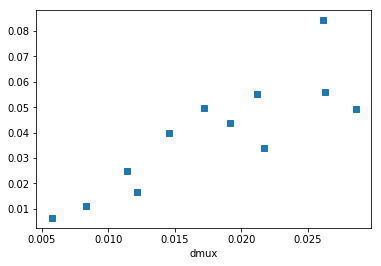

In [32]:
# verify that the error in x scales as 1/sqrt(signal) ~ 1/sqrt(SN)
plt.plot(1./np.sqrt(t["A"]),t["dmux"],'s')
plt.xlabel('1./sqrt(A)')
plt.xlabel('dmux')

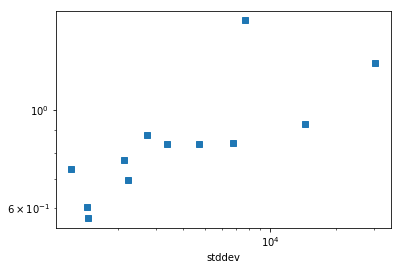

In [33]:
# check if the stddev scales with A
plt.plot((t["A"]),t["stddev"],'s')
plt.xlabel('A')
plt.xlabel('stddev')
plt.xscale('log')
plt.yscale('log')

# Area for Neven

## Results from Max

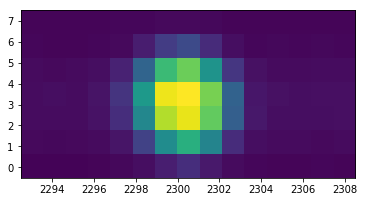

In [64]:
plt.imshow(subim,vmin=0, vmax=subim.max(),origin="bottom",extent=lrextent)

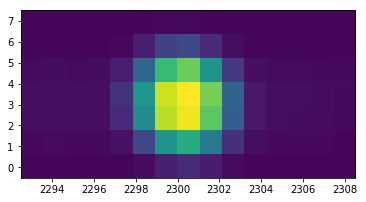

In [65]:
plt.imshow(lowres_model,vmin=0, vmax=subim.max(),origin="bottom",extent=lrextent)

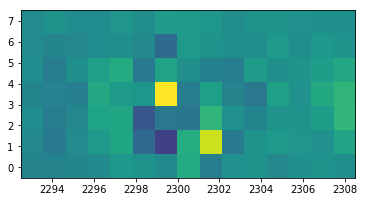

In [66]:
plt.imshow(subim-lowres_model,vmin=-subim.max()/20., vmax=subim.max()/20.,origin="bottom",extent=lrextent)
f.tight_layout()

In [67]:
# I picked this as this is basically value of last few pixels on the right
background=25

In [68]:
np.sum(np.abs((subim-lowres_model).ravel()))/np.sum(subim)

0.042412255402715211

## Galsim Run

In [32]:
#import statments
from __future__ import absolute_import, division, print_function

import socket
import lmfit
import galsim
galsim.GSParams.maximum_fft_size=12000
import numpy as np
np.set_printoptions(suppress=True)
import emcee
import time



import astropy
from astropy.io import fits

import lsst.afw
from lsst.afw.cameraGeom import PupilFactory
from lsst.afw.geom import Angle, degrees
from lsst.afw import geom
from lsst.afw.geom import Point2D
from matplotlib.colors import LogNorm

import matplotlib
%config InlineBackend.rc = {}
matplotlib.rcParams.update({'font.size': 22})
#matplotlib.rc_file("../../templates/matplotlibrc")
import matplotlib.pyplot as plt
%matplotlib inline

#np.seterr(divide='ignore', invalid='ignore')

In [33]:
##__all__ = ['PupilFactory', 'Pupil']

class Pupil(object):
    """!Pupil obscuration function.
    """

    def __init__(self, illuminated, size, scale):
        """!Construct a Pupil

        @param[in] illuminated  2D numpy array indicating which parts of
                                the pupil plane are illuminated.
        @param[in] size         Size of pupil plane array in meters.  Note
                                that this may be larger than the actual
                                diameter of the illuminated pupil to
                                accommodate zero-padding.
        @param[in] scale        Sampling interval of pupil plane array in
                                meters.
        """
        self.illuminated = illuminated
        self.size = size
        self.scale = scale

class PupilFactory(object):
    """!Pupil obscuration function factory for use with Fourier optics.
    """

    def __init__(self, pupilSize, npix,input_angle,illumminatedFrac):
        """!Construct a PupilFactory.

        @params others
        @param[in] npix       Constructed Pupils will be npix x npix.
        """
        self.pupilSize = pupilSize
        self.npix = npix
        self.input_angle=input_angle
        self.illumminatedFrac=illumminatedFrac
        self.pupilScale = pupilSize/npix
        u = (np.arange(npix, dtype=np.float64) - (npix - 1)/2) * self.pupilScale
        self.u, self.v = np.meshgrid(u, u)

    def getPupil(self, point):
        """!Calculate a Pupil at a given point in the focal plane.

        @param point  Point2D indicating focal plane coordinates.
        @returns      Pupil
        """
        raise NotImplementedError(
            "PupilFactory not implemented for this camera")

    @staticmethod
    def _pointLineDistance(p0, p1, p2):
        """Compute the right-angle distance between the points given by `p0`
        and the line that passes through `p1` and `p2`.

        @param[in] p0  2-tuple of numpy arrays (x,y coords)
        @param[in] p1  2-tuple of scalars (x,y coords)
        @param[in] p2  2-tuple of scalars (x,y coords)
        @returns       numpy array of distances; shape congruent to p0[0]
        """
        x0, y0 = p0
        x1, y1 = p1
        x2, y2 = p2
        dy21 = y2 - y1
        dx21 = x2 - x1
        return np.abs(dy21*x0 - dx21*y0 + x2*y1 - y2*x1)/np.hypot(dy21, dx21)

    def _fullPupil(self):
        """Make a fully-illuminated Pupil.

        @returns Pupil
        """
        
        illuminated = np.ones(self.u.shape, dtype=np.bool)
        return Pupil(illuminated, self.pupilSize, self.pupilScale)

    def _cutCircleInterior(self, pupil, p0, r):
        """Cut out the interior of a circular region from a Pupil.

        @param[in,out] pupil  Pupil to modify in place
        @param[in] p0         2-tuple indicating region center
        @param[in] r          Circular region radius
        """

        r2 = (self.u - p0[0])**2 + (self.v - p0[1])**2
        pupil.illuminated[r2 < r**2] = False

    def _cutCircleExterior(self, pupil, p0, r):
        """Cut out the exterior of a circular region from a Pupil.

        @param[in,out] pupil  Pupil to modify in place
        @param[in] p0     2-tuple indicating region center
        @param[in] r      Circular region radius
        """
        r2 = (self.u - p0[0])**2 + (self.v - p0[1])**2
        pupil.illuminated[r2 > r**2] = False
        
    """def _cutSquare(self,pupil, p0, r,angle):
        Cut out the interior of a circular region from a Pupil.

        @param[in,out] pupil  Pupil to modify in place
        @param[in] p0         2-tuple indicating region center
        @param[in] r          half lenght of the length of square side
        @param[in] angle      angle that the camera is rotated
      
        x21 = p0[0]-r/2
        x22 = p0[0]+r/2
        y21 = p0[1]-r/2
        y22 = p0[1]+r/2
        print("I am not sure that central square moves properly when moving and rotating on focal plane!!!!!")
        #pupil.illuminated[np.logical_and((self.u<x22) & (self.u>x21),(self.v<y22) & (self.v>y21))] = False
        angleRad = angle
        pupil.illuminated[np.logical_and((self.u*np.cos(-angle)+self.v*np.sin(-angleRad)<x22) & \
                          (self.u*np.cos(-angleRad)+self.v*np.sin(-angleRad)>x21),\
                          (self.v*np.cos(-angleRad)-self.u*np.sin(-angleRad)<y22) & \
                          (self.v*np.cos(-angleRad)-self.u*np.sin(-angleRad)>y21))] = False
  """
    def _cutSquare(self,pupil, p0, r,angle):
        """Cut out the interior of a circular region from a Pupil.

        @param[in,out] pupil  Pupil to modify in place
        @param[in] p0         2-tuple indicating region center
        @param[in] r          half lenght of the length of square side
        @param[in] angle      angle that the camera is rotated
        """
        x21 = -r/2
        x22 = +r/2
        y21 = -r/2
        y22 = +r/2
        #print("We are using HSC parameters for movement on focal plane!!!")
        #pupil.illuminated[np.logical_and((self.u<x22) & (self.u>x21),(self.v<y22) & (self.v>y21))] = False
        angleRad = angle
        pupil.illuminated[np.logical_and(((self.u-p0[0])*np.cos(-angle)+(self.v-p0[1])*np.sin(-angleRad)<x22) & \
                          ((self.u-p0[0])*np.cos(-angleRad)+(self.v-p0[1])*np.sin(-angleRad)>x21),\
                          ((self.v-p0[1])*np.cos(-angleRad)-(self.u-p0[0])*np.sin(-angleRad)<y22) & \
                          ((self.v-p0[1])*np.cos(-angleRad)-(self.u-p0[0])*np.sin(-angleRad)>y21))] = False    
        
        
    def _cutRay(self, pupil, p0, angle, thickness):
        """Cut out a ray from a Pupil.

        @param[in,out] pupil  Pupil to modify in place
        @param[in] p0         2-tuple indicating ray starting point
        @param[in] angle      Ray angle measured CCW from +x.
        @param[in] thickness  Thickness of cutout
        """
        angleRad = angle.asRadians()
        # the 1 is arbitrary, just need something to define another point on
        # the line
        p1 = (p0[0] + 1, p0[1] + np.tan(angleRad))
        d = PupilFactory._pointLineDistance((self.u, self.v), p0, p1)
        pupil.illuminated[(d < 0.5*thickness) &
                          ((self.u - p0[0])*np.cos(angleRad) +
                           (self.v - p0[1])*np.sin(angleRad) >= 0)] = False        

class PFSPupilFactory(PupilFactory):
    """!Pupil obscuration function factory for PFS 
    """
    def __init__(self, pupilSize, npix,input_angle,illumminatedFrac):
        """!Construct a PupilFactory.

        @param[in] visitInfo  VisitInfo object for a particular exposure.
        @param[in] pupilSize  Size in meters of constructed Pupils.
        @param[in] npix       Constructed Pupils will be npix x npix.
        """
        PupilFactory.__init__(self, pupilSize,npix,input_angle,illumminatedFrac)
        
        hra = self._horizonRotAngle()
        hraRad = hra.asRadians()
        rot = np.array([[np.cos(hraRad), np.sin(hraRad)],
                        [-np.sin(hraRad), np.cos(hraRad)]])

        # Compute spider shadow parameters accounting for rotation angle.
        # Location where pairs of struts meet near prime focus.
        unrotStartPos = [np.array([0., 0]),
                         np.array([0., 0.]),
                         np.array([0, 0])]
        # Half angle between pair of struts that meet at Subaru prime focus
        # ring.
        strutAngle =60*degrees
        alpha = strutAngle - 60.0*degrees
        unrotAngles = [90*degrees + alpha,
                       210*degrees - alpha,
                       330*degrees + alpha]
        # Apply rotation and save the results
        self._spiderStartPos = []
        self._spiderAngles = []
        for pos, angle in zip(unrotStartPos, unrotAngles):
            self._spiderStartPos.append(np.dot(rot, pos))
            self._spiderAngles.append(angle - hra)

    def _horizonRotAngle(self):
        """!Compute rotation angle of camera with respect to horizontal
        coordinates from self.visitInfo.

        @returns horizon rotation angle.
        
        observatory = self.visitInfo.getObservatory()
        lat = observatory.getLatitude()
        lon = observatory.getLongitude()
        radec = self.visitInfo.getBoresightRaDec()
        ra = radec.getRa()
        dec = radec.getDec()
        era = self.visitInfo.getEra()
        ha = (era + lon - ra).wrap()
        alt = self.visitInfo.getBoresightAzAlt().getLatitude()

        # parallactic angle
        sinParAng = (np.cos(lat.asRadians()) * np.sin(ha.asRadians()) /
                     np.cos(alt.asRadians()))
        cosParAng = np.sqrt(1 - sinParAng*sinParAng)
        if dec > lat:
            cosParAng = -cosParAng
        parAng = Angle(np.arctan2(sinParAng, cosParAng))

        bra = self.visitInfo.getBoresightRotAngle()
        #return (bra - parAng).wrap()
        """
        parAng = Angle(self.input_angle)
        return parAng.wrap()

    def getPupil(self, point):
        """!Calculate a Pupil at a given point in the focal plane.

        @param point  Point2D indicating focal plane coordinates.
        @returns      Pupil
        """
        #subaruRadius = self.telescopeDiameter/2
        subaruRadius = (self.pupilSize/2)*self.illumminatedFrac

        #hscFrac = self.hscFrac  # linear fraction
        # radius of PSF camera shadow in meters - deduced from Figure 9 in Smee et al. (2014)
        #hscRadius = hscFrac * subaruRadius

        #slitFrac = self.slitFrac 
        #subaruSlit = slitFrac*subaruRadius
        # meters - current value is basically random. As I am not 
        #sure what is the size that I should be using (sic!) I am using fraction 
        #strutFrac = self.strutFrac 
        #subaruStrutThick = strutFrac*subaruRadius
        
        #slitFrac_dy = self.slitFrac_dy 


        
        # See DM-8589 for more detailed description of following parameters
        # d(lensCenter)/d(theta) in meters per degree
        #lensRate = 0.0276 * 3600 / 128.9 * subaruRadius
        # d(cameraCenter)/d(theta) in meters per degree
        hscRate = 2.62 / 1000 * subaruRadius
        # Projected radius of lens obstruction in meters
        #lensRadius = subaruRadius * 138./128.98


        hscPlateScale = 380  
        thetaX = point.getX() * hscPlateScale 
        thetaY = point.getY() * hscPlateScale 

        pupil = self._fullPupil()
        # Cut out primary mirror exterior
        self._cutCircleExterior(pupil, (0.0, 0.0), subaruRadius)
        # Cut out camera shadow
        camX = thetaX * hscRate
        camY = thetaY * hscRate
        #self._cutCircleInterior(pupil, (camX, camY), hscRadius)
        #self._cutSquare(pupil, (camX, camY), hscRadius,self.input_angle)
        # Cut outer edge where L1 is too small
        #lensX = thetaX * lensRate
        #lensY = thetaY * lensRate
        
        #No vignetting for the spectroscope 
        #self._cutCircleExterior(pupil, (lensX, lensY), lensRadius)
        # Cut out spider shadow
        #for pos, angle in zip(self._spiderStartPos, self._spiderAngles):
        #    x = pos[0] + camX
        #    y = pos[1] + camY
        #    self._cutRay(pupil, (x, y), angle, subaruStrutThick)
        #    
        #self._cutRay(pupil, (2,slitFrac_dy), Angle(-np.pi),subaruSlit) 
        #self._cutRay(pupil, (0.6,2), Angle(-np.pi/2),0.2*subaruSlit) 
        return pupil

In [34]:
### ZernikeFitter
class ZernikeFitter_PFS(object):
    
    """!Class to create  donut images in PFS
    The model is constructed using GalSim, and consists of the convolution of
    an OpticalPSF and an input fiber image.  The OpticalPSF part includes the
    specification of an arbitrary number of zernike wavefront aberrations. 
    The centroid parameters are also free parameters.
    Note that to create the images, the parameters must be initialized with the
    `.initParams` method.
    
    This code uses lmfit to initalize the parameters. This is a relic of the code
    in which this class was used to actually fit the parameters
    """
    def __init__(self, image=None,image_var=None,pixelScale=None,
                 jacobian=None,nonUniformEffect=None,diam_sic=None,npix=None,illumminatedFrac=None,**kwargs):
        """
        @param image        image to analyze
        @param image_var    variance image
        @param pixelScale   pixel scale in arcseconds (this is spectroscop)
        @param jacobian     An optional 2x2 Jacobian distortion matrix to apply
                            to the forward model.  Note that this is relative to
                            the pixelScale above.  Default is the identity matrix.
        """
        if image is None:
            image=np.ones((41,41))
            self.image = image
        else:
            self.image = image
        if image_var is None:
            image_var=np.ones((41,41))
            self.image_var=image_var
        else:
            self.image_var = image_var
        #pixel scale choosen so that one pixel = 3/8 arcsec, taken from Smee et al., 2014
        # Note that this is a spectroscop and not an normal optical telescope,
        #so this is not real physical quantity
        pixelScale=geom.Angle(0.000001818)
        pixelScale=geom.radToArcsec(pixelScale)
        self.pixelScale=pixelScale
        flux = float(np.sum(image))
        self.flux=flux
        if jacobian is None:
            jacobian = np.eye(2, dtype=np.float64)
        self.jacobian = jacobian
        # Again, wavelength - this is a spectroscop
        wavelength=800 #in units of nm
        self.wavelength=wavelength
        
        if diam_sic is None:
            diam_sic=3.3
            self.diam_sic=diam_sic
        else:
            self.diam_sic=diam_sic
        
        if npix is None:
            npix=128
            self.npix=npix
        else:
            self.npix=npix
            
        if illumminatedFrac is None:
            illumminatedFrac=0.96
            self.illumminatedFrac=illumminatedFrac
        else:
            self.illumminatedFrac=illumminatedFrac
            
        if nonUniformEffect is None:
            nonUniformEffect==False
        else:
            self.nonUniformEffect=nonUniformEffect
            
        self.kwargs = kwargs
    
    def initParams(self, zmax=4, z4Init=None, centroidInit=None,fiber_rInit=None,flux_multInit=None,
                  Kolmogrov_r_Init=None,trace_valueInit=None,background_valueInit=None):
        """Initialize lmfit Parameters object.
        @param zmax                 Total number of Zernike aberrations used
        @param z4Init               Initial Z4 aberration value in waves.
        @param centroidInit         2-tuple for the position of the center of the spot in the image.
        @param hscFracInit          Fraction of the pupil obscuraded by the camera ()
        @param strutFracInit        Fraction of the pupil obscuraded by the single strut
        @param focalPlanePositionInit 2-tuple for position of the central obscuration(camera) in the focal plane
        @param diam_sicInit         Size of the telescope in meters
        @param fiber_rInit          Factor that determines the size of the input fiber
        """
        # Note that order of parameters here must be consistent with order of
        # parameters in the fitDonut schema.
        self.zmax=zmax
        params = lmfit.Parameters()
        #params.add('flux', self.flux,
        #           min = fluxRelativeRange[0]*self.flux,
        #           max = fluxRelativeRange[1]*self.flux)
        if z4Init is None:
            params.add('z4', 0.0)
        else:
            params.add('z4', z4Init)
            
        for i in range(5, self.zmax+1):
            params.add('z{}'.format(i), 0.0)
            
        if centroidInit is None:
            params.add('dx', 0.0)
            params.add('dy', 0.0)
        else:
            params.add('dx', centroidInit[0])
            params.add('dy', centroidInit[1])   
            
            
        if fiber_rInit is None:
            params.add('fiber_r', 1)
        else:
            params.add('fiber_r', fiber_rInit)  
            
        if flux_multInit is None:
            params.add('flux_mult', 1)
        else:
            params.add('flux_mult', flux_multInit)    
                    
            
        if Kolmogrov_r_Init is None:
            params.add('Kolmogrov_r', 10)
        else:
            params.add('Kolmogrov_r', Kolmogrov_r_Init)  
            
        if trace_valueInit is None:
            params.add('trace_value', 0)
        else:
            params.add('trace_value', trace_value_Init)  
     
        if background_valueInit is None:
            params.add('background_value', 0)
        else:
            params.add('background_value', background_value_Init)              
                
        self.params = params
        
    def _getOptPsf(self,params):

        aberrations_init=[0.0,0.0,0.0,0.0]
        aberrations = aberrations_init

        diam_sic=self.diam_sic
        npix=self.npix
        illumminatedFrac=self.illumminatedFrac
        
        
        for i in range(4, self.zmax + 1):
            aberrations.append(params['z{}'.format(i)])
        #print(npix)
        Pupil_Image=PFSPupilFactory(diam_sic,npix,
                                    np.pi/2,illumminatedFrac)
        point=Point2D(0,0)
        pupil=Pupil_Image.getPupil(point)
            
        aper = galsim.Aperture(
            diam =  pupil.size,
            pupil_plane_im = pupil.illuminated.astype(np.int16),
            pupil_plane_scale = pupil.scale,
            pupil_plane_size = None)    
            
            
        big_fft_params = galsim.GSParams(maximum_fft_size=19240) 
        return galsim.OpticalPSF(lam=self.wavelength,diam=aper.diam, 
                                 aberrations = aberrations,aper=aper,gsparams=big_fft_params,pad_factor=1.5)
    
    def create_trace(self,best_img,norm_of_trace):
        data_shifted_right=np.zeros(np.shape(best_img))
        for shift in range(1,best_img.shape[1]):
            data_shifted = np.concatenate((norm_of_trace*best_img[:,shift:best_img.shape[1]], np.zeros((best_img.shape[0],shift))), 1) 
            data_shifted_right += data_shifted

        data_shifted_left=np.zeros(np.shape(best_img))
        for shift in range(1,best_img.shape[1]):
            data_shifted = np.concatenate((np.zeros((best_img.shape[0],shift)),norm_of_trace*best_img[:,0:best_img.shape[1]-shift]), 1) 
            data_shifted_left += data_shifted

        return data_shifted_right+data_shifted_left+best_img
    
    def constructModelImage_PFS(self,params=None,shape=None,pixelScale=None,jacobian=None,nonUniformEffect=False):
        """Construct model image from parameters
        @param params      lmfit.Parameters object or python dictionary with
                           param values to use, or None to use self.params
        @param pixelScale  pixel scale in arcseconds to use for model image,
                           or None to use self.pixelScale.
        @param jacobian    An optional 2x2 Jacobian distortion matrix to apply
                           to the forward model.  Note that this is relative to
                           the pixelScale above.  Use self.jacobian if this is
                           None.
        @param shape       (nx, ny) shape for model image, or None to use
                           the shape of self.maskedImage
        @returns           numpy array image with the same flux as the input image
        """
        if params is None:
            params = self.params
        if shape is None:
            shape = self.image.shape
        if pixelScale is None:
            pixelScale = self.pixelScale
        if jacobian is None:
            jacobian = self.jacobian   
        #params.add('flux', flux,
        #       min = fluxRelativeRange[0]*flux,
        #       max = fluxRelativeRange[1]*flux)


        #This creates opticalpsf
        if nonUniformEffect==False:
            # 1 component
            try:
                v = params.valuesdict()
            except AttributeError:
                v = params
                
            optPsf=self._getOptPsf(v)
            optPsf = optPsf.shift(v['dx'], v['dy'])
            wcs = galsim.JacobianWCS(*list(pixelScale*jacobian.ravel()))
            gal = galsim.TopHat(flux=1, radius=(3/8)*(3/2)*v['fiber_r'])
            
           # atmPsf = galsim.Kolmogorov(lam=self.wavelength, r0=v['Kolmogrov_r'])
            #smooth_psf = galsim.Convolve(gal, atmPsf)
            
            big_fft_params = galsim.GSParams(maximum_fft_size=10240)
            final = galsim.Convolve([gal, optPsf],gsparams=big_fft_params)
            modelImg = final.drawImage(
            nx = shape[1],
            ny = shape[0],
            wcs = wcs)
            multiplicative_factor=self.flux*v['flux_mult']
            return_img_before_trace=multiplicative_factor*modelImg.array
            return_img_after_trace=self.create_trace(return_img_before_trace,v['trace_value'])
            return return_img_after_trace+v['background_value']
        else:
            # 3 components
            try:
                v = params.valuesdict()
            except AttributeError:
                v = params
            
                        
            v['illumminatedFrac']=0.96
            optPsf1=self._getOptPsf(v)
            optPsf1 = optPsf1.shift(v['dx'], v['dy'])
            v['illumminatedFrac']=0.986
            optPsf2=self._getOptPsf(v)
            optPsf2 = optPsf2.shift(v['dx'], v['dy'])
            v['illumminatedFrac']=1
            optPsf3=self._getOptPsf(v)
            optPsf3 = optPsf3.shift(v['dx'], v['dy'])
            
            wcs = galsim.JacobianWCS(*list(pixelScale*jacobian.ravel()))
            gal1 = galsim.TopHat(flux=0.32, radius=(3/8)*(3/2)*v['fiber_r'])
            gal2 = galsim.TopHat(flux=0.334, radius=(3/8)*(3/2)*v['fiber_r'])
            gal3 = galsim.TopHat(flux=0.346, radius=(3/8)*(3/2)*v['fiber_r'])
            
            final1 = galsim.Convolve([gal1, optPsf1])
            final2 = galsim.Convolve([gal2, optPsf2])
            final3 = galsim.Convolve([gal3, optPsf3])
            
            modelImg1 = final1.drawImage(nx = shape[0],ny = shape[1],wcs = wcs)
            modelImg2 = final2.drawImage(nx = shape[0],ny = shape[1],wcs = wcs)
            modelImg3 = final3.drawImage(nx = shape[0],ny = shape[1],wcs = wcs)
            
            modelImg=np.add(np.add(modelImg1.array,modelImg2.array),modelImg3.array)
            
            multiplicative_factor=self.flux*v['flux_mult']
            #I did not implement trace or adding background in nonUniform model
            return multiplicative_factor*modelImg

    
    def _chi_PFS(self, params):
        """Compute 'chi' image: (data - model)/sigma
        @param params  lmfit.Parameters object.
        @returns       Unraveled chi vector.
        """
        modelImg = self.constructModelImage_PFS(params)
        sigma = np.sqrt(self.image_var)
        chi = (self.image - modelImg)/sigma
        chi_without_nan=[]
        chi_without_nan = chi.ravel()[~np.isnan(chi.ravel())]
        print("chi**2/d.o.f. is:"+str(np.mean((chi_without_nan)**2)))
        return chi_without_nan
       
# I think I do not need anything below
    def best_image_Neven(self, params):
        """
        @param params  lmfit.Parameters object.
        @returns       Unraveled chi vector.
        """
        modelImg = self.constructModelImage_Neven(params)
        return modelImg
    
    def residual_image_Neven(self, params):
        """

        """
        modelImg = self.constructModelImage_Neven(params)
        return (self.image - modelImg)
    
    def fit_emcee(self):
        """Do the fit using emcee
        @returns  result as an lmfit.MinimizerResult.
        """
        print("Doing fit using emcee")
        mini = lmfit.Minimizer(self._chi_PFS, self.params)
        self.result = mini.emcee(nwalkers=64,burn=100, steps=200, thin=1, 
                                 is_weighted=True,ntemps=1,workers=1,**self.kwargs)
        return self.result 
    
    def fit_LM(self):
        """Do the fit using Levenberg-Marquardt 
        @returns  result as an lmfit.MinimizerResult.
        """
        print("Doing fit using Levenberg-Marquardt")
        self.result = lmfit.minimize(self._chi_PFS, self.params,**self.kwargs)
        return self.result
    
    def report(self, *args, **kwargs):
        """Return a string with fit results."""
        return lmfit.fit_report(self.result, *args, **kwargs) 

### Analysis, first

In [629]:
scidata=subim
vardata=np.sqrt(subim)

single_image_analysis=ZernikeFitter_PFS(scidata,vardata)
single_image_analysis.initParams(zmax=11)

x=[1,0.2,0,0,0,0,0,0,0,0,1,1,1]

single_image_analysis.params['z4'].set(x[0])
single_image_analysis.params['z5'].set(x[1])
single_image_analysis.params['z6'].set(x[2])
single_image_analysis.params['z7'].set(x[3])
single_image_analysis.params['z8'].set(x[4])
single_image_analysis.params['z9'].set(x[5])
single_image_analysis.params['z10'].set(x[6])
single_image_analysis.params['z11'].set(x[7])
single_image_analysis.params['dx'].set(x[8])
single_image_analysis.params['dy'].set(x[9])
single_image_analysis.params['fiber_r'].set(x[10])
single_image_analysis.params['flux_mult'].set(x[11])
single_image_analysis.params['Kolmogrov_r'].set(x[12])   
single_image_analysis.params['trace_value'].set(0.1)  
single_image_analysis.params['background_value'].set(1000)  

best_img=single_image_analysis.constructModelImage_PFS(single_image_analysis.params)
    

In [631]:
best_img[0]

array([ 1022.84441531,  1022.94890677,  1023.22803739,  1024.0009871 ,
        1026.81569874,  1043.46769217,  1088.6097863 ,  1093.32187775,
        1048.85347179,  1028.12989619,  1024.45097487,  1023.48826773,
        1023.06861461,  1022.89028065,  1022.81841049])

In [431]:
number_of_par=14
walkers_mult=4
nwalkers=number_of_par*walkers_mult
parz4Init=np.random.normal(0,0.1,nwalkers)
parz5Init=np.random.normal(0,0.1,nwalkers)
parz6Init=np.random.normal(0,0.1,nwalkers)
parz7Init=np.random.normal(0,0.1,nwalkers)
parz8Init=np.random.normal(0,0.1,nwalkers)
parz9Init=np.random.normal(0,0.1,nwalkers)
parz10Init=np.random.normal(0,0.1,nwalkers)
parz11Init=np.random.normal(0,0.1,nwalkers)
pardxInit=np.random.normal(0,1,nwalkers)
pardyInit=np.random.normal(0,1,nwalkers)
parfiberrInit=np.random.normal(1,0.1,nwalkers)
parfluxmultInit=np.random.normal(1,0.1,nwalkers)
parKolmInit=np.random.normal(1,0.1,nwalkers) 
partraceInit=np.random.uniform(0.0,0.001,nwalkers)
par_together=np.column_stack((parz4Init,parz5Init,parz6Init,parz7Init,parz8Init,parz9Init,parz10Init,parz11Init,
                  pardxInit,pardyInit,
                  parfiberrInit,parfluxmultInit,
                  parKolmInit,partraceInit))
parInit=par_together.reshape(nwalkers,number_of_par)  

In [432]:
def lnlike_Neven(x,sci_image,var_image):
    single_image_analysis.params['z4'].set(x[0])
    single_image_analysis.params['z5'].set(x[1])
    single_image_analysis.params['z6'].set(x[2])
    single_image_analysis.params['z7'].set(x[3])
    single_image_analysis.params['z8'].set(x[4])
    single_image_analysis.params['z9'].set(x[5])
    single_image_analysis.params['z10'].set(x[6])
    single_image_analysis.params['z11'].set(x[7])
    single_image_analysis.params['dx'].set(x[8])
    single_image_analysis.params['dy'].set(x[9])
    single_image_analysis.params['fiber_r'].set(x[10])
    single_image_analysis.params['flux_mult'].set(x[11])
    single_image_analysis.params['Kolmogrov_r'].set(x[12])   
    single_image_analysis.params['trace_value'].set(x[13])   

    modelImg=single_image_analysis.constructModelImage_PFS(single_image_analysis.params)
    if np.min(modelImg)<0:
        return -np.inf
    image=sci_image
    sigma = np.sqrt(var_image)
    chi = (image - modelImg)/sigma
    chi_without_nan=[]
    chi_without_nan = chi.ravel()[~np.isnan(chi.ravel())]
    res=-(1/2)*(np.sum(chi_without_nan**2))
    print(np.mean(np.abs(chi_without_nan)))
    return res

In [434]:
lnlike_Neven([1,0.2,0,0,0,0,0,0,0,0,1,1,1,0.01],scidata,vardata)

128
13.0846276043


-31861.327328577394

In [429]:
np.random.uniform(0,0.1)

0.017683255343192573

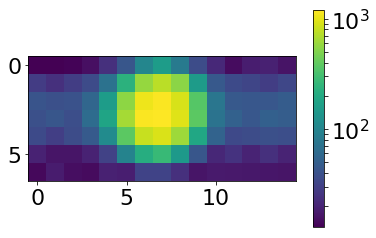

In [436]:
plt.imshow(scidata,norm=LogNorm())
plt.colorbar()

In [437]:
nthreads=4
sci_image=scidata
var_image=vardata
sampler = emcee.EnsembleSampler(parInit.shape[0], parInit.shape[1], lnlike_Neven,
                                threads=nthreads,args=[sci_image,var_image])

128
128
128
128
36.868379401
128
63.9266552926
128
62.9121171664
128
54.4308721293
128
42.1033688348
128
98.9547078793
128
86.828038898
128
76.6744686293
128
63.6540762866
128
83.4237066565
128
64.4370347362
128
59.4067104973
128
46.8735999226
128
119.695440935
75.1347333434
128
128
37.9750739965
128
117.861463343
128
54.3241881256
128
101.962256374
128
146.382464077
128
79.4553784482
128
37.540801438
128
101.986327599
78.7338991585
128
128
37.6329107476
128
121.041225492
128
79.5639129677
128
121.909408394
128
65.0320201289
128
94.6966886869
128
105.987975991
128
112.191122197
128
96.6366408781
128
49.9252850708
128
67.1430152079
80.8956233754
128
128
81.5077270038
128
60.4856539536
128
92.6512123166
128
127.167507788
128
72.4113467201
128
123.042068541
128
75.1232214261
128
81.0495899583
128
116.478057237
128
94.0933606628
128
96.9271133334
79.987700737
77.7291606108
128
56.7187180961
128
57.6211385307
128
91.9989473566
128
125.843271417
128
83.1570909028
128
89.8311090025
70.0515345

132.246155813
128
128
77.6496625209
43.1947188848
128
128
38.2583655465
128
128
89.8771313522
128
128
37.955928474
72.6541148236
128
128
33.4349474235
128
38.0197619861
128
45.8491472866
128
38.1578376243
37.6436469078
68.3479863038
128
128
128
38.180405585
128
107.385592859
128
52.7721130658
56.6111634583
128
128
51.3416447267
128
85.0830134088
86.4695518035
128
48.2236061094
128
63.9396832966
128
84.2212581162
68.7475852637
128
128
128
128
95.0593566397
128
128
63.6157928963
128
56.4179444319
128
128
36.9241514382
128
128
38.3124688185
128
81.8104794471
128
35.8616069542
128
128
59.8904184702
128
58.3527114891
128
37.7937800081
128
128
38.25588728
128
128
38.04675771
128
128
37.8901961519
128
128
53.1169178494
128
37.8935089904
86.9108959504
63.8174558774
128
52.8438094298
128
37.767089658
37.3611220091
128
128
128
128
38.0918731028
102.410517757
38.305504056
63.9495868673
128
128
128
128
38.2017380754
128
128
24.0024488433
128
128
32.9242218283
128
37.4106444805
128
128
128
128
38.5

128
27.1143268434
128
108.832462135
128
128
128
128
95.5440416227
128
40.576404863
128
50.3212807924
128
128
108.724331518
128
41.0879651291
128
27.8061409081
38.0279594218
128
128
128
66.3888114095
128
46.7080239264
128
128
59.0847907519
128
37.444166728
128
128
75.657566872
128
52.7367956353
128
128
52.3048710132
128
32.0513878196
128
106.352584716
128
58.505263597
128
51.1398835873
51.5903594051
128
37.547299912
128
57.9211460879
102.039641684
128
128
128
128
37.3843229099
38.5593666277
128
56.2121004174
115.679019943
128
128
128
37.970364393
128
37.0559040638
128
124.325446875
128
128
37.4486364221
128
128
128
30.0918341868
128
47.728149234
128
37.336008963
128
35.4826835027
38.5778452356
128
128
128
87.8852973417
128
128
38.0217721242
128
38.2483249769
128
128
49.7112694801
46.0969982105
45.3445518383
128
52.0485075623
128
37.9463185361
128
128
128
128
37.8159401902
128
38.1973944708
38.3498764735
128
128
37.9721970947
128
38.3461742463
128
128
19.6666198358
128
128
30.8661530175


37.8374810771
128
128
45.7667911595
128
128
36.7903267969
128
128
30.1166740229
128
128
129.206178136
128
35.2509883918
128
79.7155216746
128
128
65.5974161427
73.415485757
35.603415217
128
91.4826286881
128
38.1727294539
47.5648945605
128
128
128
128
38.3115975602
128
38.361891615
49.3605772618
34.9089421735
128
128
128
37.7035259057
128
128
37.7621482614
128
128
128
128
128
112.331956137
128
53.660793966
128
91.381423762
29.1941183562
128
128
38.0097892972
128
38.1069380998
128
45.2666128558
128
128
52.5130966604
128
40.2582320418
128
53.2149413554
128
33.6427697221
104.817707344
128
128
141.148719019
128
128
128
128
37.7854732059
128
128
38.2141262053
36.6612220599
128
128
38.3364251519
128
128
28.1124383507
128
128
24.4679148182
128
108.957410868
75.3116131649
37.3996501392
128
128
128
128
69.7368489974
128
128
57.5579396911
128
29.0395992375
128
128
128
56.7785181264
128
128
37.4930886737
128
74.994203714
37.657564963
128
36.9912287551
128
22.5675009696
80.5232917634
128
128
128
1

128
38.1869567286
128
128
38.2692007614
128
35.4324453406
128
23.1827454091
128
86.9762237495
128
39.9918337497
128
116.469740033
128
21.2856911882
128
37.7131365561
128
128
37.3856774027
128
128
37.3567424816
128
128
128
61.7011500128
84.0483665239
128
128
87.0699373004
128
128
128
128
128
37.5431840536
128
128
128
114.918475134
128
128
128
128
128
73.1708170031
37.600436607
37.1406885736
128
128
128
40.6494754609
128
37.4111488898
128
128
128
60.2158460275
128
48.1863570904
128
128
117.589765552
128
43.5577119564
128
51.2269095624
128
38.0230194886
128
57.5290658096
128
41.1380265576
128
128
128
128
62.9883186158
128
94.8525184144
92.108563645
91.924494322
128
128
128
57.9064127071
128
128
47.7112325015
125.649198548
128
128
63.7099483271
128
28.041113646
128
76.3490414191
128
128
56.1916852987
128
128
37.0810611424
94.9842521767
128
128
128
38.186339705
37.3607546541
128
128
128
62.85955912
128
33.9556569489
40.5885007916
75.7743718244
128
55.9166506888
128
128
128
128
128
128
37.75

128
104.048879075
128
128
33.3406712758
128
36.7576348886
128
66.0111702893
32.4908853566
128
37.8969722598
128
28.1406841946
41.9712322998
128
128
128
128
43.1504402478
128
128
82.6272859338
128
128
37.7530901071
128
41.0374650307
128
38.3231633323
128
63.8738360799
128
38.0748418412
128
71.4892858453
128
40.9652352677
128
128
128
128
38.9298722271
103.638341813
128
128
37.926670872
128
128
75.421020879
141.751669797
128
128
30.8389090458
128
128
35.0465831621
21.1357953896
128
83.2234982436
128
37.2956523563
128
128
128
128
128
36.9924591454
128
128
128
128
127.701946677
128
37.7005071179
128
128
91.8015926872
128
37.8599400352
128
40.6425335116
128
128
128
42.509110346
71.2226487136
128
128
26.6635147162
128
36.9423101163
128
46.8295006787
37.7966971081
128
128
58.4570222724
128
128
128
67.0862397154
59.1963864315
26.2869881339
128
128
26.0212121058
31.3163352252
128
128
128
128
39.0134386914
128
101.050222275
37.6354320281
128
128
23.6370105429
128
128
91.4591111724
128
128
38.3500

128
34.2303149329
67.7050538212
128
128
38.0347780373
128
128
128
128
35.3582580658
37.7483140252
128
128
95.5282675495
37.1543695247
128
128
128
38.345204452
128
174.765648278
20.8186860156
128
128
45.4319939074
128
38.9358999248
128
128
37.3444255914
128
128
37.3005641358
128
37.8906989764
19.2934013694
128
128
40.1921955665
128
21.2607135046
128
128
18.3211363124
128
24.7462742638
128
115.720615562
36.7723303744
128
44.2196798935
25.0852825294
128
37.5166942008
128
31.2096054882
128
128
128
128
31.5239519905
128
38.3059229083
37.0687372979
128
128
25.4904125657
128
128
37.1690550801
128
128
128
96.9733821741
37.5730572231
128
128
22.1481259839
128
128
33.840749284
128
22.363443281
128
38.4865285737
128
128
36.8827409643
128
53.4845428526
128
128
37.1482919
128
34.6319988905
128
26.9235568479
128
36.7654919689
69.0795137297
15.6519092648
128
22.8325329135
128
36.7151892657
37.2917828688
128
128
128
128
34.9375009489
128
128
128
37.9844962576
128
36.9469580058
128
38.3412870764
128
37

97.4487380176
128
17.6629228647
128
128
14.7649779626
128
15.2975196056
128
9.6099079155
128
31.8416961559
128
45.8043031004
128
128
30.1974739999
12.9642371744
128
128
128
128
128
128
103.173784125
128
30.8002691824
128
36.6547585215
128
128
36.3333178067
40.9444775109
128
128
36.5506222593
128
29.8467824098
128
128
38.0547268748
128
14.6666035221
128
23.0263553025
128
128
40.9790048454
128
48.4689258255
128
37.754453245
128
37.332155015
128
128
38.0044930805
128
73.2095898584
31.6529340425
128
17.8069917744
128
128
44.0841968404
128
128
128
128
128
37.7694350587
128
128
128
37.436068738
128
128
38.6704338347
128
128
41.0283481403
128
92.2166832802
128
128
128
37.2148500788
128
128
37.9226410884
128
23.7388981367
128
29.5314339251
128
52.9872847439
128
128
19.8334111664
128
128
31.8470411819
128
37.1076119901
38.1536026527
40.2021739407
128
34.4695085403
128
26.0342412368
91.3189030804
128
128
128
128
54.0455846859
128
128
66.1690580297
128
30.3998394672
128
36.9835236322
128
36.88466

128
66.7385515344
42.830460915
128
128
128
128
128
37.4390287487
128
36.5470833189
128
92.1005946554
128
38.0829790124
128
17.3442396033
128
14.9415559389
128
13.1303979122
128
128
76.4134332568
35.8420476086
128
37.957017884
128
33.613681926
128
128
128
128
34.6234909292
128
128
26.419085734
41.5016176782
128
128
69.8177957501
128
128
128
35.6951735592
128
36.6938448773
128
59.4340244462
128
37.265955141
128
128
20.7584396043
128
128
128
108.205790376
128
128
128
81.276436588
37.7611798063
128
128
26.7927909072
128
128
13.9061357747
128
32.7958969629
128
128
128
128
128
128
128
80.2180124914
128
128
128
128
63.2317888547
144.528015573
128
128
27.5661261399
128
120.107206542
128
93.8156340658
128
100.805859569
128
36.9934510737
128
36.5437963066
128
128
128
128
70.02951208
128
30.6056471114
36.3447670916
128
128
128
128
37.6137245762
38.3412324709
31.2028041948
128
82.5637349341
128
16.0730174283
128
128
128
128
27.3933246137
128
75.1631816201
128
76.01390276
85.933783486
128
128
42.27

128
95.0856362287
128
83.9098915374
12.8513327204
128
128
23.9452832432
90.4454089445
128
128
36.9233313966
128
91.1607745347
128
128
38.136509372
128
128
128
73.1162421945
128
37.9577669512
128
11.5471953532
14.314708824
128
128
128
128
43.9428616417
64.4980044687
39.3467156472
128
25.1321445529
128
15.5534605452
128
128
128
128
48.1027470745
128
40.6818611563
128
20.2135210085
128
128
128
159.164683985
128
38.3521976965
128
49.4702267059
128
37.0747267776
128
30.4677686857
128
27.2939149936
128
37.159311304
128
31.7662996564
128
38.6962943362
128
64.1829984191
128
53.4398119471
128
128
128
128
128
30.8419253841
128
36.8079644667
128
59.5574826474
11.683145067
128
49.7843512928
128
128
128
128
128
30.2129255539
128
128
95.9949766235
44.9619703017
128
128
128
128
128
36.2600454119
128
26.2980853977
128
91.1970848085
128
37.6838816862
36.913960415
128
128
68.8272345929
128
128
38.2190441577
128
37.7937861213
128
28.2669235323
128
128
37.7773339323
128
128
115.504698034
128
128
57.340310

128
128
53.6371366477
128
128
94.0206591243
17.3067203399
14.5194188984
128
42.3465335986
128
37.7981391714
128
128
128
128
108.837482898
96.4777912907
128
119.457266613
128
128
128
106.882020055
128
128
9.27070819786
37.8264751345
128
128
128
74.3147632832
128
128
37.8361590977
128
128
37.7349187512
128
37.1742047286
128
74.9319151982
128
17.3066734825
128
38.200953827
128
128
123.92479044
128
9.95870991247
128
29.2771717271
128
37.346193294
44.4553050419
128
128
11.3742942952
50.1753624901
128
128
128
128
38.2631546833
128
13.8722542335
128
128
20.4904716387
128
37.0007576518
128
77.8592117889
128
36.3955730449
128
36.8044504496
128
128
101.9928695
46.5394720967
128
128
128
61.2130343533
128
9.94607638225
77.6474947568
128
128
35.5590985578
128
128
47.2379664874
128
128
128
53.2621410176
128
128
21.4909891903
9.75047344604
128
28.809471674
128
37.7825606122
37.3058491549
128
128
128
128
52.1606871542
128
111.402824829
41.0004171135
128
128
128
35.7303346162
128
14.1858589042
128
128


128
19.9001512033
128
32.9861699554
92.8804062567
128
128
128
37.242665614
128
128
128
52.5153959012
128
128
22.4142217641
50.0859932618
128
128
49.786589701
128
128
128
128
44.2761334725
128
36.9261465746
128
128
129.333117863
128
65.5344598482
58.2473635385
83.9155158619
128
128
128
128
128
38.1322101391
128
42.9360464041
128
128
128
128
128
16.4280337874
128
49.7676444919
128
80.5514553211
128
128
128
9.01039565854
128
30.7088489965
128
38.1471757401
24.5924733729
128
34.3232931143
128
13.9353166978
128
128
128
128
10.881163103
128
128
128
128
51.7732209399
36.3216043834
128
128
38.4981498851
110.222141479
128
128
40.2537048418
128
128
11.9701195649
37.6660325334
128
128
84.3793301714
49.8841828196
128
128
128
128
68.4872376521
128
72.1332757879
128
56.1488476677
128
128
53.6067364696
128
19.3511962714
128
59.8547313404
25.5861405995
128
11.7256498802
128
102.169153416
128
128
128
128
30.4029437337
128
128
128
37.1629154301
128
42.5469308518
128
128
128
128
128
38.7522637263
128
37.

128
128
51.603579531
25.1718292878
128
128
18.1252029679
128
128
128
128
35.2315003211
128
128
128
68.2977425334
128
18.8692686505
128
39.2013236333
128
128
128
128
128
128
128
128
38.3683615813
128
128
128
128
128
40.9575063369
128
35.9974923227
128
128
36.6591389706
128
78.3021782946
128
128
30.8027585433
128
15.106350487
128
128
12.3100541933
128
36.833765494
128
92.9303126927
128
34.6503581128
128
37.4567712657
76.0303500156
27.4558028939
128
38.8614912754
128
128
128
128
128
42.9843505654
128
15.1136155134
17.130508262
128
128
128
33.6539606319
128
77.060530304
128
128
128
30.7242898135
128
12.5058772751
128
110.809269966
128
30.4993108527
128
128
128
27.3922699873
128
128
128.839118944
128
39.5560791397
128
160.497359287
128
53.6336981675
128
86.3625654531
128
39.035618905
128
26.0585983124
14.8183224046
128
36.0633857435
128
38.0125582376
37.5645361313
128
128
128
128
128
128
58.9398240738
128
128
73.4863513152
128
128
52.6739598109
128
9.32442481755
128
128
128
128
128
42.35874

128
169.47512266
128
128
130.896201081
128
36.9721811992
128
54.396542755
128
22.1039236647
128
128
33.5690401784
128
37.0463138614
128
66.4579953197
128
128
31.117482795
128
12.4838383736
128
15.2342723279
128
38.144908056
128
34.1251362786
128
104.437066881
128
128
38.6270100496
128
37.6144543697
128
71.0179976964
128
9.53957868871
20.9798329769
128
128
128
128
41.9828448796
30.2261780656
9.53855266962
23.6554346996
128
128
128
128
32.6790197294
128
51.0280197409
36.6067118287
128
49.7397634455
128
128
31.4529870817
128
128
119.612684732
128
128
77.3111610113
128
60.7216610148
128
16.0836291985
128
22.2581995418
128
128
40.875924995
128
128
128
18.0901890878
128
33.7307365481
128
72.1476721454
9.63992335709
128
29.7424724338
128
128
128
128
128
33.0137030133
40.3666719372
254.385852547
128
128
128
128
36.9279580782
128
37.513861466
128
71.0360086302
74.5963109347
128
128
35.101585689
128
128
104.001210014
128
128
128
128
58.6661640816
128
128
18.6240118686
128
37.9627550545
128
33.02

15.8411851577
128
19.2348022217
128
37.4457361916
128
128
128
128
30.2921705111
128
36.7740781308
37.9557431497
128
128
128
189.658843826
128
128
128
22.3850565717
128
128
34.4377672136
128
77.8234786111
118.775242804
128
128
31.1431701953
128
27.4218315843
128
30.8472933811
128
128
128
38.2365860486
128
128
9.9615239708
128
8.74568224836
128
105.727532006
128
38.3252799667
18.3647314369
128
39.4972841641
128
8.4435470578
32.9002854144
128
128
128
128
30.1985220326
128
128
38.3337886612
128
128
154.346737057
128
128
128
128
56.8483085231
128
8.17729476319
27.0534384677
128
128
39.1037022633
128
9.97716792746
128
8.35797319425
128
46.1471384411
128
128
128
59.7079707135
128
128
128
18.6233092113
128
67.3675111102
128
45.1183400637
51.4182397781
45.1547619308
128
13.9219350246
128
80.6557964478
128
128
128
128
128
128
37.7847004858
128
128
38.0006228423
128
128
38.4848385165
128
113.345461365
128
128
37.9293198081
128
39.3534323578
128
128
30.8062599295
33.4436560512
128
128
31.125377620

128
128
128
128
27.5480489551
128
8.94677225664
13.0768495317
128
17.3871031976
128
128
128
128
128
34.8163868594
128
47.3186624024
128
128
37.6065756363
128
128
67.0627599411
128
122.445524469
128
8.81157412702
128
17.0291489493
128
37.3712401287
128
33.9160191375
128
128
56.0111279337
128
41.6851070647
90.3508225687
128
37.4707780611
128
128
26.3454624582
128
128
57.0624626319
128
9.74811714756
128
106.01861772
128
115.346247163
128
135.270357581
48.543474584
19.6428465167
128
128
9.00694304002
9.71278077795
128
128
128
128
38.366733263
8.94429038866
128
128
9.19563883877
128
128
40.1179037432
128
31.3124358728
128
128
128
26.3199578413
128
59.7256464396
128
39.2579005263
128
128
128
116.407400751
128
10.3954951339
128
128
128
45.0480361935
128
128
128
128
69.5003561153
128
32.0804620539
40.4063329577
9.24293707969
128
17.3668240498
128
128
128
128
128
30.4714015035
128
49.8804123644
128
37.6696453187
128
128
37.5327625728
128
128
8.76968888434
128
76.7709736537
128
14.3181840523
128

46.3913226487
128
128
128
128
128
47.2352967422
128
81.2804228467
128
128
128
37.3455790627
128
107.244338308
128
128
128
41.5310993978
128
35.1622789258
128
35.6481192608
34.4399045776
128
128
128
34.1668477974
128
126.895339923
128
128
10.4651905482
128
128
37.134011057
128
128
16.5906326127
128
65.4489819666
93.1129784651
128
110.514037356
37.6761987249
128
128
128
128
128
128
128
88.48309736
128
38.3059759519
128
128
32.4258474379
128
128
38.4378537429
128
38.1580746628
128
30.9092779526
128
49.0981972239
128
8.33725496365
128
128
16.2327805174
128
128
128
22.498503011
128
36.9060217514
128
128
128
205.705592798
128
65.9137258917
128
32.2403832263
128
22.4253209052
8.33565469415
8.53641399277
128
56.8584448916
128
38.1963655524
128
128
128
128
128
128
37.3323638032
128
128
37.9148880786
128
38.2976250311
128
128
128
46.3562562772
128
48.9445013832
128
128
128
73.7360048074
128
32.4567940123
128
30.7967312942
128
19.3286587062
128
128
11.5870397922
128
23.7111735215
128
33.872889888

8.54841671265
128
25.7079662424
128
128
36.8744983797
128
128
128
128
55.3009152549
128
83.8961020824
128
128
128
128
36.1186582581
128
102.338691417
35.6610740261
128
128
34.4871927078
128
97.5523201657
128
32.9066925553
128
46.8722230327
128
65.6727466771
128
130.050056905
128
37.3481993151
128
128
41.8297535224
128
128
128
8.49636115962
128
128
28.0199492805
128
37.764643765
128
33.5050939526
128
8.87290433911
8.32927216402
128
128
128
128
40.3255936733
128
128
38.314806552
128
128
36.6517886397
128
128
128
92.6783727833
128
128
10.9238849246
128
42.2433571739
128
128
9.62854452806
128
21.7464604985
128
36.3628245803
128
29.9197538005
128
36.973474559
128
128
128
128
19.3761988669
128
128.855902211
128
10.7718771243
15.0632110073
39.0032658545
128
103.496765238
128
43.3482728938
46.3852663872
128
128
128
128
128
128
128
128
128
38.1702744455
15.5332730009
128
128
128
128
16.1339674313
128
128
83.3273190375
128
30.2274726001
128
128
32.2096437972
128
14.6592147132
128
30.1389415689
1

36.351677298
128
128
8.17868486865
128
11.6251672932
128
36.097201697
10.3420014298
8.09732087356
128
128
128
37.0388924671
128
128
128
39.4597349245
128
18.7788483086
128
8.31785033565
15.2742147551
128
30.9445916075
128
14.9470973762
128
37.3432650001
128
128
128
128
59.0245823095
128
45.5785942842
45.9636905587
128
128
128
37.7603585493
128
45.1193442881
128
92.7988026769
128
128
33.3990643802
128
128
19.7501936243
128
36.6587311823
128
128
128
128
20.9023451749
128
69.8705188963
128
128
23.1352304168
128
16.7753456196
128
30.078639958
128
32.5304337247
128
50.2105009189
36.965408514
30.440580761
128
128
9.46664875387
8.34689486785
128
128
128
128
20.6559950304
128
9.71896872949
128
128
128
36.6342376559
128
49.6907930232
36.3512885612
128
128
128
8.17097036741
52.7943245425
128
128
36.3894716912
128
128
8.69773516461
128
63.1460196432
128
128
128
48.5716548252
128
128
128
128
33.2585494571
64.4962287235
128
128
44.6618996325
8.32850873057
30.8591453581
128
128
128
128
128
128
84.55

128
92.4010702558
128
38.3509538594
8.15030370528
128
128
128
29.6163448986
128
69.9630768573
96.7581135532
128
128
106.630795076
128
9.56265148023
128
25.2409778238
128
128
8.67670906444
128
75.3576380448
128
25.7259987862
128
11.7943300841
128
37.3399132771
128
128
128
37.6554191192
128
43.3141483727
128
31.0051189826
128
15.1137619765
29.4692166695
18.4331379299
128
13.2422444973
128
128
128
128
128
118.968663936
128
57.8002787242
128
50.3789638266
128
128
128
128
16.7565492661
35.4342774884
128
128
14.0796913209
128
128
41.6381190802
128
36.4681607487
128
128
38.3444447095
128
128
7.96488916544
128
128
36.8897234461
128
57.9419400319
128
52.1290879211
128
17.6937088957
128
92.1745272371
128
30.2053815044
60.4130865223
43.4247973688
128
32.5290826088
128
8.75038136744
29.6940544383
128
128
128
128
30.0142732194
128
44.3836317973
128
128
128
128
128
37.1732285177
128
128
29.5055976359
128
15.8584920238
128
14.4642943867
128
128
60.2521824829
128
128
63.3238827181
128
9.35896509592
12

128
8.87900875618
128
25.2459143124
128
55.3748751151
128
26.669369406
128
30.7736400514
114.51971484
18.8442288769
128
125.741455339
128
36.6750287837
128
128
128
128
33.6510529848
128
128
8.71619792786
26.8452101464
128
128
29.57687876
128
32.8062055612
128
37.4980504194
128
128
128
11.1095166759
128
8.46348104277
128
128
9.2132169197
128
9.04690596572
9.65268897714
128
128
128
155.027912748
128
128
128
223.50086815
128
18.9232353974
128
115.607635675
92.6118237307
128
112.576221997
128
26.4146975748
128
60.7149800887
128
128
128
128
90.0213030183
128
37.9714018202
128
128
128
35.2560099385
128
38.2637520542
128
128
25.4946630182
128
95.2810683427
128
128
29.4955825824
128
27.4513861875
128
29.9854055133
128
36.3110136349
128
41.8618189685
128
128
21.4413223011
128
128
128
8.1741261031
128
62.3980325188
128
48.9487522156
128
30.0379320823
128
32.9458674731
128
8.51618708725
128
128
128
128
29.1521162966
83.2193498885
22.1059381392
128
128
128
128
31.4576358592
128
128
38.1574583977
1

128
128
128
117.565825726
128
14.3040867424
128
40.7139197621
53.4017518823
128
128
128
128
35.0196731519
128
122.271266167
128
128
18.7289736646
128
36.9013930998
128
36.714492204
8.11289845188
128
128
128
12.9443667757
128
30.0747062287
60.0574104414
128
128
56.6479597039
11.595007856
128
128
128
128
30.1962977544
128
56.0030507173
8.12323661653
128
128
8.74578996455
128
30.1563241126
128
150.226301891
128
37.6900310074
128
128
31.4139301441
128
8.00917979798
128
55.9925637283
128
10.4266491703
128
77.9483855601
128
9.56661967572
128
29.9199650872
128
128
37.3594560251
128
128
128
128
23.1444102805
128
128
15.9299905861
57.738472701
128
128
111.503274653
128
128
128
128
128
128
128
128
37.9218254853
128
128
128
128
20.5372686048
128
128
37.3182687542
128
25.9902816224
128
194.953182889
128
29.8180564267
128
32.5200132865
128
9.00566474969
128
10.9795865767
128
128
22.6108059041
128
8.15680910475
128
30.7464722599
128
128
29.731761392
106.222915297
128
30.6833480562
128
27.3748278747


30.2900025401
128
46.2052433275
128
45.9063638447
128
161.596950594
128
70.4443668447
128
128
36.4468961074
128
9.08668346648
128
15.4401624411
128
128
128
26.4531289628
128
50.7138692802
128
128
128
55.1357894778
128
12.4757908112
128
117.111654662
128
128
8.3608372106
128
23.5382908184
128
30.0892244106
128
37.0088463042
35.155043639
128
128
58.5111291413
38.8154701859
128
128
128
128
30.5865899769
128
91.4841990233
128
8.6263301495
8.11686489046
128
128
29.7732029723
128
29.3117265581
128
94.5147168733
128
128
30.8840913678
128
128
128
35.3660219234
128
8.64400172627
128
44.4215038242
128
8.21509350285
128
128
48.7334307974
128
128
37.703446151
128
56.8258496206
128
121.435897659
20.7436508995
128
128
44.7628173526
28.4018634485
37.7602001705
128
8.14378687382
128
37.2303334293
128
128
128
128
128
128
29.6408365036
128
128
175.697026668
128
128
34.938589685
128
128
29.1647266655
128
31.4633958266
128
128
23.6376863134
128
136.800070547
128
38.042963788
128
29.3979516155
128
30.13178

128
67.633889906
128
128
128
128
30.5346122881
128
8.61932243936
38.6266016122
8.14106614274
128
128
128
58.2001589824
128
37.3720899113
128
38.299216363
128
40.0729188567
128
29.4510413323
128
86.2242948673
128
139.284617695
128
36.7451953305
128
28.500207545
128
128
7.9668923134
128
128
37.0243765971
128
128
77.7840364724
128
40.3284721575
128
36.3154941026
128
30.3034837459
128
14.1139684551
8.01268005857
64.5254459066
128
128
40.909596198
128
128
128
128
37.0670094206
128
57.5563594877
128
128
128
25.9883463102
128
35.1418337036
128
112.47564773
128
128
128
128
128
33.1826794835
128
128
128
47.426917094
128
32.4508589571
128
11.7014938254
128
128
119.124730274
29.5317017898
128
128
112.196746523
128
40.0801915487
128
36.2800492562
128
64.9861504601
128
11.2713958868
7.89810446608
128
128
128
128
128
8.30956025648
8.22239833966
128
128
78.4257930016
128
39.9980375407
128
128
90.2481199551
128
128
128
13.7837646787
128
128
35.0401839005
128
57.6515420356
128
35.9499747748
128
128
128

128
40.2989137104
128
128
128
40.6841457631
128
63.979126864
128
128
16.271663755
22.4990144741
54.0927543008
128
14.8872205702
128
49.683373925
128
128
128
128
128
128
37.4587572199
128
128
128
74.9223337102
128
97.8814711977
128
128
13.5483063446
128
30.6570972545
128
30.2124298374
128
28.5254972858
128
128
38.240219098
128
162.780944249
128
54.8760534856
128
28.1797768741
169.900397455
128
128
38.0978872514
128
31.5378104301
128
27.1725885627
128
128
30.0896718974
128
46.7311531109
128
37.779894874
8.39137501928
128
128
128
128
143.437960294
128
128
35.0706431399
128
128
128
128
36.4263947842
128
34.5449214822
128
128
128
7.58990535889
128
128
8.21797790148
128
128
13.8443964344
128
128
128
128
128
128
54.7547577546
128
128
7.59706748785
12.6503287923
128
36.3766182896
128
128
128
128
128
128
110.68199961
128
128
128
51.4342826209
128
35.0742330479
128
8.76596331468
128
128
128
49.232953259
128
38.4109279844
128
11.2217317936
128
29.8010432951
128
33.4720975642
128
128
35.9450536974

128
128
128
128
35.1781820999
37.979016707
128
128
38.3683646392
128
95.9481882748
128
37.1278881816
128
128
45.2391047824
128
33.071600773
128
128
30.8614471369
128
11.1162398836
128
30.397967027
128
128
8.27861432255
128
128
84.5490708999
128
8.14676350278
128
8.36180537845
128
128
27.792543295
128
128
23.129588042
17.2583954723
128
61.8560097711
128
24.2863193707
128
128
128
128
55.0954929314
128
99.7002374151
128
128
128
128
128
205.29158819
128
128
29.6100520471
128
14.5735060373
128
128
128
10.8391398621
128
64.8353662103
128
128
128
38.0980159621
44.4869745773
128
128
186.506074903
128
128
128
40.1556953129
128
47.3943856201
100.81585682
128
7.93816152745
128
37.8045686039
128
128
128
128
38.2090922873
128
29.2681415324
128
128
128
128
19.9784288543
128
128
128
16.5715808801
128
41.4277692858
128
128
8.30742831137
128
128
33.5478770639
30.2550733559
128
128
7.89247184706
128
40.8483145013
128
128
72.2424183343
128
38.1904701483
128
54.3033744057
128
128
69.5122215403
29.01200542

128
128
37.0017379774
128
29.4519286235
128
128
62.4469418731
31.037760684
128
128
128
128
128
11.4917705482
128
29.0060817631
128
128
32.6340285255
128
128
30.0300993821
128
54.0669101639
128
128
128
128
38.1692438659
128
128
22.8544780229
128
51.2956718037
128
36.7093731212
128
128
128
128
128
55.5627001487
128
19.5286506429
91.1014789318
14.88253612
128
128
128
38.8519937551
128
29.1767321122
128
60.1477046697
128
128
128
15.4039523826
128
7.24776351731
128
36.1948577774
128
35.4269115136
128
128
7.71930497042
128
53.5816713736
128
128
128
128
128
16.9366432637
128
30.5687019086
128
7.48561661771
59.2244816688
99.4963959668
128
22.8168482609
128
39.4774749167
81.7350479387
128
128
128
128
128
89.0624575685
128
29.675622593
128
128
42.9176043896
128
35.2464818388
128
128
34.9168874084
128
108.369733934
128
35.6218823235
128
128
6.65467655042
128
29.5695562169
128
128
62.5491971897
128
7.88621577677
128
43.5541401849
128
128
17.6858011704
128
23.7257302412
128
90.6257175502
128
18.346

128
28.7777131054
128
66.0951495913
128
128
151.952549771
37.8664417061
128
128
128
128
102.093326389
128
36.4306753748
34.9460034726
128
128
128
128
69.3904950601
77.5344289105
128
128
128
66.9276218662
128
27.8803371169
128
128
16.4604093514
128
31.5978341037
128
30.1181878862
128
44.0513329437
128
128
128
128
7.72726132941
128
37.2384434527
128
35.1172652985
128
67.9148468477
128
29.0130681566
128
128
9.48918743607
7.6729949601
128
128
128
128
128
8.868724831
128
128
29.7092641536
128
139.397169177
128
128
128
128
29.6140546547
128
15.0928115211
128
36.6289925406
128
128
14.495081317
128
7.81727110216
128
128
52.4185357539
128
35.4438397201
128
49.5575879034
128
213.570879414
128
128
21.8304808756
128
128
35.2696127937
9.2995884443
8.75073691152
128
26.5950295539
128
44.9040062231
128
128
128
128
128
128
94.0209845003
128
128
37.6692980809
128
128
20.3560511504
128
69.0510891551
128
21.8012947197
128
32.4779146416
128
128
9.79911160909
128
30.0328193551
128
128
128
35.4233110542
128

36.3203390863
128
128
128
128
92.1064850618
128
36.5806633489
38.5549098864
128
128
82.8423044145
128
34.7575152346
128
128
9.25655969871
128
128
10.8704677268
128
45.9992317094
128
28.9679829041
128
138.726466086
128
128
91.326374177
128
172.78910774
128
128
72.4543107263
128
15.8017819251
128
7.60365518731
128
8.29555883334
128
184.001879832
128
20.4395984277
128
29.5805689617
15.1736048217
128
29.8075248898
128
8.30974673071
8.03505338392
128
128
128
128
29.115304041
128
128
128
20.6996370109
128
148.461576545
128
128
128
38.368364574
128
29.9403537348
128
11.0446739603
128
8.90015281358
128
35.3034192354
128
47.9384892462
128
128
119.92422769
128
8.06812075177
128
44.3870027291
128
33.8717179273
128
35.2397642591
128
128
29.0826352003
128
45.7246953743
128
16.1616599223
16.3518629769
47.8774728834
128
9.21109827488
128
47.9335833371
128
128
128
128
81.0664472032
128
47.9841438074
29.6408879235
128
128
168.319922326
128
35.1203678277
128
35.0634634492
128
99.1706633009
128
128
29.55

128
84.7668779871
128
24.5328090394
128
81.3177544598
128
20.1547110217
128
128
43.3316836736
128
37.7991844523
128
128
17.0899157437
128
20.8606439474
128
7.75712273075
128
75.2584621128
128
128
128
128
128
89.8422485998
128
66.1648554777
128
128
128
38.3518033844
128
69.2168618372
128
181.785801348
54.5125522513
128
128
21.1271917038
128
153.396064484
128
8.83441288729
128
128
128
30.7271581024
128
7.60163821517
128
128
10.6447999951
128
128
49.1129724932
128
48.6418828027
128
128
19.8310939646
128
29.1287966029
128
29.4502109382
128
18.9846708143
84.2345868156
128
128
128
128
128
46.4651851915
7.97735001204
128
128
38.6034163315
128
128
128
36.419297644
61.4570019991
128
128
128
76.8245530866
128
128
29.8467985683
128
128
23.6547250875
7.60962112651
128
128
8.1138942641
128
39.4981367585
128
128
37.7931233328
128
128
128
12.6336095898
79.5560424875
128
153.768269297
7.42220311638
128
18.5996655474
128
128
128
128
128
41.2251905411
128
36.3035776974
128
128
29.6236624831
128
38.34783

128
8.43193780802
128
128
8.12193411675
128
30.1569935932
128
128
128
128
100.284363864
128
157.721419696
128
8.05466764829
128
34.8956834447
128
54.5317985481
128
128
128
7.72331870089
128
52.7842871438
128
128
37.5824629375
128
128
28.995404307
128
35.9326862685
128
92.5362209802
32.1777493386
95.6316406881
128
128
128
128
128
128
47.694159931
128
30.3824588011
128
128
128
34.7505587914
128
190.995204471
128
14.7816634049
128
128
128
128
49.4960567857
128
128
128
128
15.5911913506
128
29.6439459697
128
26.2096142441
128
64.9789393994
128
7.54011417167
128
90.3797708429
128
128
10.175837442
128
46.7869634605
29.06449066
11.7750459751
128
128
7.20607962272
128
128
128
128
31.0957882428
128
38.3618343825
128
7.73507404874
7.62000189499
128
128
128
128
38.3659107561
128
128
29.6316584726
128
128
128
128
8.26750909741
128
128
62.1733735487
128
128
37.0082140824
128
128
128
128
128
30.1768343505
128
78.4261549512
28.1877938809
9.16894540101
128
43.9299637784
128
55.7562975458
128
128
128
1

128
32.3743087549
128
28.7104429282
27.7890200651
128
128
128
128
38.3165070865
30.1361662368
9.87601627756
128
128
128
128
37.7983715656
128
51.5112261664
128
29.7028025559
29.2167039153
128
128
128
131.576396504
35.0593147553
128
128
128
128
17.0140761058
128
50.0849664531
7.54303934329
128
128
35.3383713447
128
128
101.973673647
36.0708428871
128
128
21.1718119893
128
128
35.3354335864
19.969105179
128
60.3274502104
128
62.4356862368
128
128
128
128
31.5672531501
128
199.306888753
128
34.7201429584
128
38.3683646437
128
128
18.5273184106
128
38.0340555631
128
35.0192970267
128
128
155.06411566
128
128
29.1851984388
128
33.5796779907
128
61.9184762895
128
128
64.7962109437
128
128
128
7.77855438075
52.3386001113
128
128
128
85.0016691244
128
29.9550748616
17.8580956731
49.7139134249
128
29.0800595974
128
7.18149964058
36.8534500735
128
128
128
128
15.4328494315
90.8198570336
34.9723475149
128
128
128
29.4919349838
128
35.980239927
128
34.9612473821
128
38.3603752698
128
30.3185412377

7.55101805703
128
128
189.796720459
128
18.6451815127
128
30.0705270198
128
128
110.931346637
128
128
29.8818332279
128
91.344756278
128
128
106.512404444
128
44.1115362129
128
7.38672146229
128
128
10.6042265007
128
230.425836696
128
31.1620858687
27.2293064783
18.5369568326
128
128
6.89899514662
7.92088576776
128
128
128
128
128
78.8160317672
128
38.3494739998
128
7.86358651129
128
55.7259433616
128
35.2149033993
45.7049490037
128
128
41.0492328931
128
30.4780544919
128
128
7.96045370441
128
128
128
36.6486064966
128
8.29654414833
128
128
47.5308745502
128
128
41.0013908141
128
128
46.0900761444
128
128
7.9470680252
29.4748485911
128
8.96885766206
128
61.4123094105
38.2899701486
128
128
128
128
128
36.043335656
128
37.0665705984
128
128
38.3374833736
128
162.59572512
128
47.9953356747
128
7.10353662254
128
128
29.2558115594
128
98.203400432
128
12.6468355889
128
128
29.4430526234
128
29.3155935666
128
28.6816088547
128
31.6739612526
128
95.5437354182
128
11.9464892322
128
128
128
35.

128
282.793196653
128
29.9183978601
113.02304767
128
128
38.3519348738
128
78.192299248
128
196.442583726
7.13970817312
128
128
128
39.1842022657
128
128
72.0279055167
128
128
128
29.7883006362
128
29.1587730223
128
27.562729585
128
19.3373838397
128
128
20.5046861965
128
12.1281181556
128
32.3759591533
128
21.1827702313
36.8897970876
128
128
9.79831896579
128
128
128
128
128
39.1208644762
128
128
128
31.7113769453
128
47.0393074216
128
128
33.3864615667
128
19.9166122272
128
128
7.28807599275
128
128
128
7.39890349507
128
128
128
77.8731749506
128
68.5608535702
128
128
128
136.832250079
128
40.4292114076
128
82.1805260704
128
29.7234950186
128
128
128
128
128
128
128
128
128
47.568502184
128
36.9608541758
128
128
128
10.697890893
128
30.4324681105
128
53.7019798702
128
29.2136018469
128
31.3016129994
128
29.3785451397
128
128
128
10.8144732747
128
128
7.46755719465
128
18.694665124
128
7.87385398708
128
106.663264056
128
41.3432812885
35.6503821538
30.0688464006
128
19.4581987662
128


128
34.411117518
34.4911832677
128
128
34.5918757788
128
8.88396900371
128
29.2967407148
59.6100457263
128
128
50.8380875277
128
30.6511817912
128
128
128
128
128
42.0558503595
7.58451802625
128
128
128
26.9864382903
128
164.36285356
128
10.4714379002
35.2894239535
106.25131213
128
28.9858763657
128
28.566729745
10.2791172372
128
128
128
128
47.112306569
128
128
7.92621746415
128
128
30.3364060031
128
128
34.1192119059
128
128
59.4150083061
128
34.3055236044
128
19.507902895
128
34.3696641193
128
7.23287398323
128
128
33.6520196319
128
7.54756373466
128
33.0117171077
128
128
37.513631577
128
128
58.8784064805
128
24.6134874968
7.40074736758
128
90.1122830306
128
128
35.3335160097
46.2245226557
128
128
128
128
128
34.3551135256
128
128
128
45.30421045
128
128
131.222524537
128
105.974467482
128
31.6659884584
128
128
67.8279777405
128
29.4574033214
128
30.3846524299
128
54.3481587132
128
128
27.9721764697
128
8.7691527549
128
45.9626629711
128
134.912459394
128
7.33081429892
128
7.811270

128
36.404802174
128
24.3816263935
128
7.61813432185
128
32.9878171203
128
128
128
37.1662819509
128
29.5555595172
128
128
27.0186078208
24.3664480558
128
128
128
128
128
128
160.78659013
128
128
37.2819754438
128
59.2150504412
128
148.890902362
128
195.761313654
7.10885151034
128
128
37.5803706379
128
29.3702799943
128
12.9472804388
128
29.4006476171
128
65.3448617743
128
32.0297219468
128
29.7963720027
128
9.7445075837
128
128
52.4976529601
128
128
45.7981145367
128
84.2822130506
128
56.6816887729
128
92.6798006329
128
40.8482051641
128
15.954359527
128
11.8185339764
36.4040022392
128
128
128
128
54.5164841768
128
29.5853356409
128
8.00753426282
128
91.6660494228
128
136.591956622
128
29.5659708799
128
33.8805152328
128
30.387207264
128
42.1961883654
128
8.640790756
128
137.479842653
128
128
128
36.0981340688
128
33.1089181623
128
12.3134917697
128
33.5839171717
128
128
34.2954410098
128
128
15.0352549985
128
36.6070239843
55.1883272873
128
11.1916439338
128
26.2407508934
128
40.5933

128
36.4399650369
128
6.90692773246
41.1091769594
128
128
128
128
8.08421143207
128
38.3289979861
128
68.1653899685
20.8915758878
128
128
38.0408088987
128
99.7288323737
128
128
33.6746467077
128
128
81.7629797139
128
75.9154329043
128
32.6892094958
128
109.125336578
128
34.8001048055
128
8.01530809619
128
30.7080598716
128
200.008976617
128
128
180.143537613
128
34.1532215142
128
19.1503318814
128
29.3051075235
128
55.0520641496
25.388555248
128
26.1373550198
128
128
128
128
128
128
128
128
128
212.949498264
128
38.1417528721
128
12.8537301084
128
128
10.1639326705
128
34.6355427633
128
55.8198565138
128
146.580733802
128
30.828525764
128
70.8030199587
128
31.0661849223
128
6.98503966261
128
26.0501285521
128
7.58574462483
128
128
128
128
128
35.1914734551
12.8232197889
128
28.9835499656
128
10.1809662607
27.4654667425
128
128
128
128
29.6660279547
128
7.34269970105
128
38.360127744
10.5100693631
128
128
128
37.9828301797
128
128
128
29.7063620174
128
128
36.6435248664
128
128
20.5200

128
189.546596103
128
29.4643742045
10.7445961243
128
128
6.41669565641
7.8705730036
128
128
128
128
47.4963052822
33.0395733812
128
128
43.6867384606
7.42703495288
128
128
30.4605925012
128
36.4069116226
128
128
32.9424956268
128
29.454154322
128
30.0450293893
128
7.19375696519
128
232.201064883
128
66.3150008062
128
128
7.62821369895
128
128
45.5045496158
128
128
58.7726297394
128
128
128
42.4555318828
128
23.776704733
117.836229203
155.357080801
128
13.5275351813
128
34.5887692551
128
128
128
128
128
32.4608163862
128
36.8814465638
128
33.9544880042
128
128
227.326512599
128
9.13935320505
128
128
9.10958952413
128
30.3756113565
128
48.6894879302
128
32.6443960924
128
166.766039882
128
30.2587379039
128
128
11.4284633772
128
62.1854725357
128
85.586550404
128
114.924198642
128
57.7216334031
128
128
128
41.4741627666
11.9536311023
128
128
95.1324396823
72.0101772516
128
128
128
128
15.49246337
128
48.2946554695
128
128
95.5305177499
128
38.2026347532
128
180.458543061
128
128
29.66990

128
73.8654306087
128
94.0737423943
128
10.3260460012
128
34.7072541171
106.74120536
13.570708284
128
29.5421960269
128
19.7012349346
18.0491239963
128
128
128
128
47.1977909348
128
10.4265456832
128
128
128
29.7618089623
128
61.0987198995
128
37.8344175511
128
29.7169997846
128
51.3699278068
128
81.7767845794
128
112.692341446
128
49.7456093449
128
30.3597699026
128
128
7.27853954075
128
37.3962338573
128
50.2098909613
128
213.353691226
128
128
128
17.4250096283
128
29.3813555261
128
80.4166469
97.4476200974
55.1186083014
128
128
52.1439303417
128
128
128
128
128
35.4328560908
128
37.1756662517
128
128
36.9987084611
34.2745760229
128
128
7.0478706656
128
34.4403958413
128
22.6938257064
128
82.7575586266
128
29.5226565603
128
128
128
29.3346277036
50.4639381523
128
128
128
13.4215538994
128
7.11918735192
83.8407009711
128
128
128
23.8013050352
128
29.3789463115
11.9601019823
128
128
128
18.5918319886
128
128
128
128
128
19.4333574087
128
29.7991443018
128
61.9526918105
128
29.754676426

128
128
128
106.19374708
128
85.9132002047
128
7.05563987261
128
128
8.13177113975
128
65.14426715
128
9.54401050585
128
128
30.1454102683
128
128
7.55451390506
128
128
17.6699790898
128
7.79148886296
128
128
34.2264022547
128
36.4667824177
128
29.5211110934
128
27.0757954741
8.49738917536
128
128
137.898785927
128
128
128
128
31.9313369675
128
6.84990138148
128
117.670062465
12.4487899167
128
128
173.326140626
128
38.2433178974
128
128
128
29.6725039669
128
36.0323265291
128
7.55598547299
128
32.8110343878
128
7.85145099558
128
10.4281757954
128
7.5198264488
128
128
128
128
159.217018679
67.3897467949
128
128
128
9.25156293935
128
7.21847327155
36.1800462038
128
128
78.1703990881
128
128
128
128
29.6793079233
128
128
138.393150449
128
128
36.4330220386
128
128
58.7851963238
128
34.8256007686
128
8.1064641429
128
48.009471333
128
38.4592688275
128
124.085713498
128
128
10.771741858
128
128
29.4232328595
128
8.43185905558
128
47.0814792768
128
128
41.6564774029
128
18.6487213729
128
128

128
23.6551867079
128
128
36.0958804236
128
29.5497006801
128
60.5202107108
128
128
30.3005863627
128
128
128
128
9.05232910917
128
33.0251521104
128
16.7225332139
128
123.485955006
128
128
27.390708338
29.4940917116
128
34.1058641805
26.7655600192
128
29.6961907516
128
16.8177633919
128
128
128
128
32.7562269758
128
7.91975495826
128
65.0904372884
128
38.3391852572
128
29.7051550153
128
170.521280661
128
128
49.6088401179
128
36.5319064738
128
128
13.8710196832
128
128
128
7.51232659338
128
128
70.3690573589
128
70.377554944
128
128
128
128
128
9.32188870049
128
37.1843850698
26.4622466984
128
8.68085666228
128
128
128
128
128
36.3014481133
128
128
128
128
38.1406183597
128
34.4534956534
128
15.0921512223
128
128
128
128
16.0774929068
128
30.082122251
128
160.947661815
128
30.326814525
128
29.4465900602
128
6.97404526149
128
8.63519858913
128
128
38.5044970886
128
103.136824907
128
128
31.0437138346
128
16.3522804749
34.095086222
29.6419862567
128
11.7890033788
128
6.48867215338
128
1

128
128
23.0884523623
128
29.8824494219
128
30.921498552
128
7.17267715647
128
38.2410567059
128
128
34.1161048144
128
15.18670637
128
29.1143409733
128
74.7715263828
128
146.030220639
74.8248721601
128
67.0908097363
128
128
54.6055403089
13.4652923788
128
128
128
128
128
7.20804862604
19.2171448845
128
128
128
29.7765989113
128
38.0928288767
128
33.5119681062
128
128
31.0229525357
128
128
29.6296175035
128
32.2774352489
128
7.61261380373
128
58.7107462282
128
24.5027937453
128
128
128
128
128
128
8.72831808153
128
45.2176030711
128
29.5607248191
36.485266452
128
35.2330302447
128
33.4518654303
128
128
128
128
39.0183954821
128
29.7789396618
128
66.1857130166
128
128
75.5667861834
128
9.87621710915
68.4499276326
128
128
128
128
29.693552222
128
128
6.90118386734
128
128
30.1765030259
128
7.58574823238
128
29.4086664224
128
8.7589384822
128
7.28631655609
128
16.8044783708
128
128
14.3018621072
128
29.5241996805
128
34.0718518985
78.8057295486
9.73019971429
128
29.7461336436
128
157.6979

7.87263238731
128
128
128
128
128
34.3969257567
128
7.64557539714
128
128
38.2810198703
128
29.7839724313
128
128
128
30.5355038184
128
23.5375583918
128
19.0914885993
128
128
7.85480744537
128
128
21.8033161614
128
64.2520308366
128
58.2044158879
128
128
73.0619354438
128
128
128
28.5585281488
128
109.453095151
18.5464476861
128
10.8225093928
128
44.5791290267
128
128
128
128
29.8118504506
49.0568154272
128
128
125.086881997
128
58.0857148156
128
45.4091703376
128
141.588636219
128
128
128
29.5747601183
128
19.1626146284
128
60.8956068158
128
181.736334369
128
128
36.8354854823
128
7.18671838647
128
46.1177319887
128
40.9264600779
128
32.5126838948
128
128
128
6.87541603731
128
25.3605428991
128
128
46.4399106114
128
7.15161843233
128
128
128
128
47.8357963808
128
60.4763005526
128
38.2006589991
128
80.3302581028
128
211.982577619
128
29.7827176444
128
33.2246304566
128
128
29.950121511
128
8.18892835152
128
128
83.9541716062
128
73.0135563604
128
33.4444722606
128
8.46015755161
128
1

128
42.9833337705
128
33.3687521009
128
30.5416385347
128
7.61218672672
128
8.89753289311
128
32.2822871634
128
24.3641322037
128
21.7575762678
128
128
10.2902443616
128
128
29.6360454989
128
6.3162744933
11.3574977075
128
128
128
128
36.185279318
128
17.0440338163
128
86.1984136835
128
29.9003967958
128
58.3500570289
128
191.324504143
128
128
29.6312470174
128
128
59.0252612799
128
14.8063921515
128
128
7.33594385003
128
128
128
128
128
47.3517886532
128
128
128
8.02208132198
128
7.21699653416
128
35.5676184497
6.27707271931
128
54.8033021691
128
38.2990859338
128
128
128
128
128
176.96485071
128
128
128
97.0097279836
128
38.3526436491
128
128
128
33.8680830932
34.8958682568
128
128
9.03110815472
128
128
31.1092269043
128
160.93375306
128
31.7925428346
128
156.251752031
128
30.2036321433
128
128
7.51824915784
128
128
61.0274304993
128
9.21131545564
128
168.722784437
128
128
6.30407251611
128
128
128
128
128
29.5804393089
128
61.3003504549
128
19.1505780113
128
33.8651135491
128
29.459

/Users/nevencaplar/lsst/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/galsim/1.4.3.lsst1/lib/python/galsim/phase_psf.py:1120: UserWarning: The calculated stepk (0.977591) for PhaseScreenPSF is smaller than what was used to build the wavefront (0.981677). This could lead to aliasing problems. Increasing pad_factor is recommended.
  "Increasing pad_factor is recommended.")


128
128
128
128
27.0218947984
6.47338939313
128
128
128
128
53.9756611495
128
68.4328447759
128
12.3473176969
128
138.142853325
128
38.4918301143
128
35.1284588826
128
37.8240566812
128
128
29.5012601553
128
57.1932716094
128
7.22272224602
8.09747611618
6.06282551358
128
128
236.116320152
128
128
128
128
102.623218848
29.6335362507
128
128
128
128
38.3464942847
52.5073881366
128
128
128
128
128
8.01921642667
128
30.5926610551
128
14.2823450498
128
30.006192196
128
29.6455408219
128
128
128
9.93538510745
128
7.43875335675
128
128
34.8317762138
128
150.823434935
128
60.0904601061
128
50.0360318888
100.617425072
128
128
18.7983676352
128
128
128
128
29.6131282179
128
38.2858192773
128
128
28.1495100773
128
29.7480714513
128
38.3408524928
128
128
128
30.2416931711
128
8.34033822251
128
18.0713873959
128
128
7.19656063772
128
209.453150146
128
10.5593781687
128
62.2693999686
128
84.0361082581
128
49.2469176439
128
128
128
128
29.5890876591
128
15.8532670531
77.7548667029
128
37.7998447749
1

128
30.2516957734
128
71.5446732684
17.3385084569
128
128
128
128
17.3346449766
128
37.3205817381
128
128
11.2004913224
128
51.9499751053
128
43.1974279434
128
150.392211028
128
32.9522132331
128
11.7452555257
128
111.639801043
128
128
33.4162830563
128
128
16.5991983467
7.14355616462
128
128
128
128
128
37.8417876167
128
128
36.0087857077
128
121.084437321
128
15.5358188917
29.5018247172
128
29.2226524376
128
144.989110058
128
128
128
128
33.7982063145
128
128
128
128
128
128
35.3394113075
128
128
12.0494766145
29.5940002739
128
128
57.4987732909
128
11.1084171176
128
30.0970517836
128
37.966084433
128
128
6.62157302033
128
38.0426168725
128
61.8743371164
128
7.51741918393
128
128
128
31.5847348448
128
17.772452693
34.8357367718
28.4579683102
128
30.2198413023
128
37.2669287753
128
128
128
128
128
6.91502155521
128
6.7025489808
128
128
146.446552577
128
128
29.3684840243
128
128
29.5501850269
128
91.2832104882
128
26.3981577524
128
128
7.11339360314
128
75.6270576743
128
128
128
32.27

128
128
128
177.448607045
128
158.075453499
29.5859855831
38.3194688501
128
128
128
29.6490915378
128
51.4191537965
128
49.9735482706
47.7331440388
128
128
128
9.92443902641
128
7.53359561274
128
128
20.7531028412
128
140.885430388
128
58.4648145839
128
15.0002001145
128
128
128
128
128
8.17013927327
128
128
53.8954743805
61.7648926886
128
8.11599670273
128
128
128
128
128
36.8321837264
128
33.7114113106
128
128
188.890976615
128
34.3839697204
128
6.94073772973
128
128
35.9571477743
128
25.3375844895
128
30.4622100636
128
213.147579824
128
78.4819267965
128
128
30.897661623
128
29.5608910643
128
90.1541037482
128
19.1544253596
128
111.704264699
128
7.17667236584
128
6.98183430598
128
6.54941679106
128
128
14.5715123315
32.036148281
18.8515171426
128
31.0287354636
128
128
128
128
128
24.8194615738
128
128
38.0767744718
128
128
30.5005968351
128
29.5440101468
128
85.5331156096
128
128
15.5340757525
128
36.7338200776
128
39.8685630037
128
70.2742391015
128
11.130725012
128
128
128
128
47.

128
62.9759731749
16.8920135873
128
29.8293586032
128
35.0705484476
7.57306272973
128
128
128
128
128
29.3151439646
71.5999978609
128
128
128
106.965749619
128
43.0835326647
128
38.3452021161
128
33.6885468533
128
29.4435831773
128
31.0753445895
128
6.05425214066
128
128
7.6677031281
128
133.361386609
128
128
57.3450582865
128
32.0369085325
128
128
37.344126585
128
32.2285366446
128
8.01575845681
128
54.0379758734
128
7.06152774976
19.6787578865
128
8.05673493885
128
31.547289783
46.6395249569
128
128
128
128
128
128
36.7521564999
128
44.0952378208
128
36.4370714151
128
128
37.8463711444
128
128
128
42.6055416808
128
41.3215961945
128
5.98695459264
128
32.7171676081
128
29.6355759457
128
128
128
13.7238690034
128
35.0244233259
128
128
128
26.7979838221
128
128
249.374888269
8.39074047081
128
204.167518364
128
32.1148531522
7.09666937466
128
128
128
128
128
115.146622297
128
17.8129532347
128
36.155654698
128
33.5828681049
128
128
37.1316299747
128
128
128
128
263.963017519
128
128
32.6

128
46.1847117517
128
128
38.3651478216
128
128
8.74625751987
26.6898735583
128
29.7926351401
128
11.0264140722
7.10085034834
128
128
128
128
128
36.0958901571
6.56299421935
128
128
44.0090831375
128
38.3070129666
128
128
128
128
29.6552997486
128
128
21.3137488629
34.7514839348
128
128
29.8133168035
128
146.459928201
128
128
128
41.3709168285
128
128
33.3664067683
128
128
35.1753355455
128
32.2590451231
128
8.1566106461
32.5847114744
93.4754826525
128
8.26900163545
128
103.960925319
128
128
128
128
29.980468073
128
128
43.9088721286
128
128
128
128
137.068001044
128
128
29.575972698
128
8.01552726602
128
128
57.3205799748
128
128
128
22.2092199948
128
128
21.0547087779
128
128
7.02514446096
32.1605794184
128
128
19.4033140384
128
128
33.8765687247
41.2329665859
128
29.6758015643
128
19.1440392008
10.4093779551
128
128
128
128
62.2434006169
128
128
15.4347430642
41.5207944805
128
128
74.6823041604
128
128
128
128
8.18234769973
128
6.18587291177
128
128
34.6848900249
128
254.35948757
12

128
59.5248290874
128
38.0776769472
298.766350592
20.5761848914
128
128
36.3166905116
128
128
128
128
12.4669382662
128
128
6.47082939361
128
30.5155989045
128
128
69.9767058748
128
33.8173075943
128
128
30.2054886875
128
6.09757779234
128
11.4630836405
128
34.6019002264
128
7.50893016155
52.7408228759
128
128
5.99212131278
128
128
41.4989816808
128
41.1657975652
128
128
128
30.0925099292
128
138.481746249
128
55.535576189
59.2677489864
128
19.674277648
128
31.9883014513
128
128
128
128
128
92.6881720725
128
76.6045134277
128
128
128
42.804830719
128
33.0273286034
128
128
128
128
155.011907855
128
132.810347534
128
29.5698254462
128
29.6544658869
128
128
18.1164282831
128
28.8370383732
42.9510283615
128
128
7.21997790934
128
32.8987133381
128
128
128
32.143355076
8.18750790616
128
128
7.2313847457
128
128
128
128
128
38.2083674366
156.154891635
128
128
25.950483216
128
29.9762553172
128
128
128
128
29.8166158212
128
16.5929434495
128
84.2811868803
128
35.0178210405
128
128
128
31.68125

13.9464076696
128
128
134.396872084
35.6849510167
128
29.687082472
128
54.2031407697
7.03578188718
128
128
128
128
51.6112143653
128
128
96.4019839735
128
59.8061093484
128
39.8121965598
128
128
59.9050406036
128
128
50.076570669
128
6.38240392763
128
128
110.954492298
128
15.0871257303
128
24.3984797886
128
146.927035803
128
128
65.892253908
128
248.099174914
37.4886078681
128
128
128
29.6479606759
128
7.84935378282
8.22858579523
128
12.755563244
7.47926334423
128
15.8611912253
128
122.149168796
128
128
128
128
36.2145778366
128
91.0436981719
128
128
128
96.4001741708
128
128
128
128
128
32.0206802227
30.1465447621
128
128
36.2676254853
128
128
30.7837037813
128
128
19.0267369405
128
9.24672429413
128
148.887873427
110.672247396
128
128
6.74045049863
128
20.4443269128
128
34.3097050758
128
11.3130130936
128
128
128
128
128
128
29.5962015559
128
7.1057451718
38.364432385
128
128
34.3073878172
128
29.6300151679
128
29.5576834422
128
38.3574421544
128
128
191.515944512
128
8.03005582358


6.99147099146
128
128
128
128
128
19.6686390645
128
30.7479620272
128
128
29.6280720958
128
35.7522339101
128
128
128
128
128
8.62017362227
128
38.4683883175
128
7.00828676689
128
27.0246767615
128
128
51.8342387216
128
128
128
128
128
29.6624311755
128
33.9635397391
128
21.1902348822
8.07005784327
21.7748361582
128
25.100773944
128
32.3052274126
181.190235855
128
128
128
128
34.9951126364
128
94.5733988677
128
37.5447921869
128
128
38.1627043355
128
128
32.0587933946
128
128
10.4712049658
128
30.1163081698
128
128
128
29.7577411042
128
29.4825332592
128
36.5688237484
128
128
13.8354356327
128
7.15346998295
128
32.9528138675
128
6.69693459281
128
128
29.8218836367
128
140.504140795
15.3043644887
128
29.5677582213
128
6.89471756096
12.4904114391
128
128
128
128
76.4207770385
128
29.5456118881
128
36.6296489022
128
38.3011477003
128
29.6308429407
128
38.1875531832
128
128
37.7346728122
128
128
81.3952400345
5.27675022602
128
128
128
56.03489894
128
34.3674626799
14.5241055522
128
128
6.0

128
30.1684068435
128
128
193.730997671
128
8.55211225198
128
8.18254708067
128
145.932827001
128
33.8179691674
128
128
13.2347566621
128
42.2512797278
128
14.1780919178
128
29.757803333
128
8.27837311994
7.19893732694
128
128
128
128
6.84574346598
128
29.4830432506
128
11.3543779555
128
128
128
136.664461715
128
33.1712530742
128
128
131.364734728
128
128
10.983271148
128
128
22.9653016922
128
11.6164319493
128
128
23.5480338733
128
225.852436005
128
128
34.1005815685
128
128
17.7952250764
128
29.6384506559
128
26.589993705
7.02079560015
5.75884666241
128
128
128
128
128
128
128
33.3069465539
128
128
29.5787959202
128
38.0183759041
7.47215647036
128
128
128
128
30.170155353
128
128
128
6.08159791595
128
30.2700785492
128
31.3315931171
128
31.6739187991
128
128
128
282.878724056
128
6.75014150013
128
128
5.94637894133
128
24.8898313706
128
32.5103189421
158.247089357
100.588783521
128
30.0488873403
128
55.4215276472
7.26739233624
128
128
128
128
6.43256364702
128
128
34.9671554439
128


128
128
8.20539021613
25.1338721595
128
21.7422674237
128
33.1039445092
128
128
128
128
128
29.4105240948
128
128
32.0398711826
128
51.2406743219
128
128
128
128
8.63945597857
128
29.506587598
128
5.48881670622
128
128
39.8786723763
128
195.790982219
128
31.8881951028
128
9.06075005099
128
35.2119846041
128
64.2194747936
128
27.2392682276
128
128
128
74.5477609077
128
8.05944577201
128
128
36.337312226
128
128
128
128
6.3451270747
128
38.3073951387
128
5.8763141102
128
29.4385764892
128
29.0572874827
38.1761857725
128
128
29.7700948279
128
33.4106382313
128
29.4827073743
128
5.42855768423
128
30.0325747075
128
128
7.26189971815
128
17.7208776614
128
49.9868924781
128
128
128
42.9021571359
128
31.2420516081
128
180.917061099
128
29.7755882293
128
128
23.8663349935
6.49790992149
8.67516659393
128
39.8171719583
128
128
128
128
128
29.8822866459
128
64.6330290513
128
128
80.2369075694
128
161.865444109
128
35.4189122465
128
7.07148434627
128
128
29.8007554317
128
9.17189753247
128
30.98344

7.06992846802
128
33.0084454849
128
33.5321424453
128
128
35.7536959548
128
128
36.584275126
128
30.1699712768
128
54.7328391399
128
128
14.4946211715
128
52.0683976051
9.04644089412
128
128
11.0576048462
128
29.382100916
128
128
28.2528336812
29.9702051337
128
11.0017499468
128
128
128
128
128
6.67718761387
128
61.4430623623
128
128
29.34254751
128
38.328278289
128
128
128
128
128
5.43188954205
128
128
37.3640620072
128
33.3343106479
128
6.96699896555
128
33.8723991679
128
15.9660911109
128
32.4291631027
128
31.9273314962
128
128
128
20.6581895546
128
16.3786306873
128
19.7477948613
196.429984939
6.24187146715
128
13.8302724584
128
44.8097666508
128
128
128
128
128
37.0144122523
128
32.2558155563
128
128
14.2533650504
123.235380203
128
128
82.8637833417
128
128
29.5796109822
128
128
5.40468818386
128
29.7737223821
128
41.1649263341
128
128
128
128
13.3676569685
128
32.5919894287
128
28.6763247049
128
6.89665523403
128
5.40321795586
128
8.75997100404
128
12.4688516089
128
128
43.928658

128
23.8845331222
33.8849953422
128
128
5.61127183799
128
67.3732458906
128
128
42.6173959011
128
128
35.371967853
128
58.9773064606
128
20.4478116029
5.54673699678
128
12.9446017269
128
208.512023969
128
128
128
128
128
33.7644038773
128
38.3678873616
128
128
167.941436
128
9.46801787316
128
38.2505433741
128
128
31.903897706
128
21.6835651085
128
13.8867732379
128
29.9966802025
128
31.5105022938
128
36.6125561517
128
6.55170860035
128
128
38.2991115843
128
128
16.1349147623
128
7.99739811582
128
13.5461795408
128
82.0920050218
128
128
109.559490089
128
6.90374297903
128
128
128
128
37.6257248927
128
201.999768908
60.4298734823
128
60.2178714114
128
128
30.4974925136
128
214.989102717
128
128
128
50.8719758859
128
17.1019527545
128
16.566634333
33.2688366076
128
128
128
128
128
81.004182315
128
32.5697762852
128
40.3785271454
128
120.387547359
128
128
79.5759354916
128
58.9347216972
128
15.4262723226
29.9575654324
157.122589838
128
13.5396162851
128
263.428473707
38.2457938253
128
128

128
259.966768704
26.5140058151
128
128
14.7042792685
20.6499339161


In [438]:
nsteps=600
for i, result in enumerate(sampler.sample(parInit, iterations=nsteps)):
    print('z11: '+"{0:5.1%}\r".format(float(i) / nsteps)),

z11:  0.0%
z11:  0.2%
z11:  0.3%
z11:  0.5%
z11:  0.7%
z11:  0.8%
z11:  1.0%
z11:  1.2%
z11:  1.3%
z11:  1.5%
z11:  1.7%
z11:  1.8%
z11:  2.0%
z11:  2.2%
z11:  2.3%
z11:  2.5%
z11:  2.7%
z11:  2.8%
z11:  3.0%
z11:  3.2%
z11:  3.3%
z11:  3.5%
z11:  3.7%
z11:  3.8%
z11:  4.0%
z11:  4.2%
z11:  4.3%
z11:  4.5%
z11:  4.7%
z11:  4.8%
z11:  5.0%
z11:  5.2%
z11:  5.3%
z11:  5.5%
z11:  5.7%
z11:  5.8%
z11:  6.0%
z11:  6.2%
z11:  6.3%
z11:  6.5%
z11:  6.7%
z11:  6.8%
z11:  7.0%
z11:  7.2%
z11:  7.3%
z11:  7.5%
z11:  7.7%
z11:  7.8%
z11:  8.0%
z11:  8.2%
z11:  8.3%
z11:  8.5%
z11:  8.7%
z11:  8.8%
z11:  9.0%
z11:  9.2%
z11:  9.3%
z11:  9.5%
z11:  9.7%
z11:  9.8%
z11: 10.0%
z11: 10.2%
z11: 10.3%
z11: 10.5%
z11: 10.7%
z11: 10.8%
z11: 11.0%
z11: 11.2%
z11: 11.3%
z11: 11.5%
z11: 11.7%
z11: 11.8%
z11: 12.0%
z11: 12.2%
z11: 12.3%
z11: 12.5%
z11: 12.7%
z11: 12.8%
z11: 13.0%
z11: 13.2%
z11: 13.3%
z11: 13.5%
z11: 13.7%
z11: 13.8%
z11: 14.0%
z11: 14.2%
z11: 14.3%
z11: 14.5%
z11: 14.7%
z11: 14.8%
z11: 15.0%

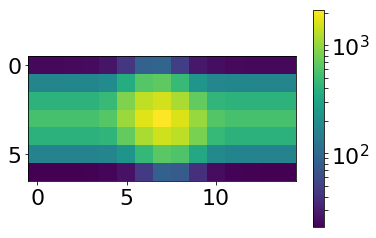

In [440]:
plt.imshow(best_img,norm=LogNorm())
plt.colorbar()

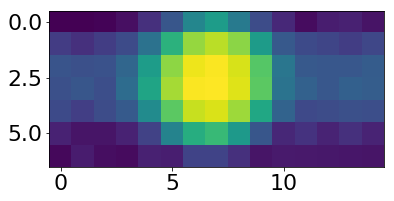

In [441]:
plt.imshow(sci_image,norm=LogNorm())

In [443]:
chi=sampler.flatlnprobability*(-2/(14*7-14))

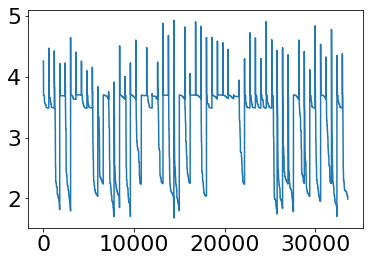

In [460]:
plt.plot(np.log10(sampler.flatlnprobability*(-2/(14*7-14))))

In [445]:
x=sampler.flatchain[chi==np.min(chi)][0]

In [446]:
x

array([ 0.17847919, -0.3668873 , -0.05414852, -0.1891682 , -0.28525657,
        0.12094714,  0.10394832,  0.32122484, -0.04874674, -0.10207927,
        1.27622496,  0.86955898,  0.5775538 ,  0.01179301])

In [465]:
scidata=subim
vardata=np.sqrt(subim)

single_image_analysis=ZernikeFitter_PFS(scidata,vardata)
single_image_analysis.initParams(zmax=11)

single_image_analysis.params['z4'].set(x[0])
single_image_analysis.params['z5'].set(x[1])
single_image_analysis.params['z6'].set(x[2])
single_image_analysis.params['z7'].set(x[3])
single_image_analysis.params['z8'].set(x[4])
single_image_analysis.params['z9'].set(x[5])
single_image_analysis.params['z10'].set(x[6])
single_image_analysis.params['z11'].set(x[7])
single_image_analysis.params['dx'].set(x[8])
single_image_analysis.params['dy'].set(x[9])
single_image_analysis.params['fiber_r'].set(x[10])
single_image_analysis.params['flux_mult'].set(x[11])
single_image_analysis.params['Kolmogrov_r'].set(x[12])   
single_image_analysis.params['trace_value'].set(0.0005)   

best_img=single_image_analysis.constructModelImage_PFS(single_image_analysis.params)

128


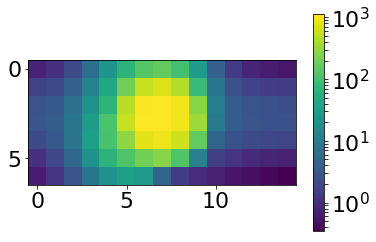

In [466]:
plt.imshow(best_img,norm=LogNorm())
plt.colorbar()

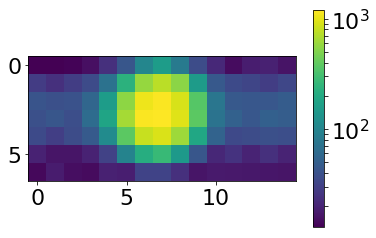

In [451]:
plt.imshow(subim,norm=LogNorm())
plt.colorbar()

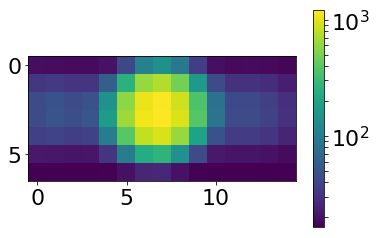

In [452]:
plt.imshow(lowres_model,norm=LogNorm())
plt.colorbar()

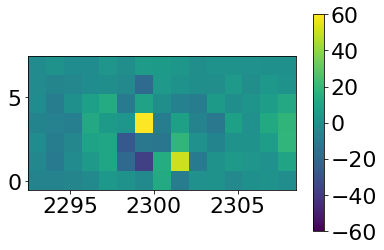

In [453]:
plt.imshow(subim-lowres_model,vmin=-subim.max()/20., vmax=subim.max()/20.,origin="bottom",extent=lrextent)
plt.colorbar()
f.tight_layout()

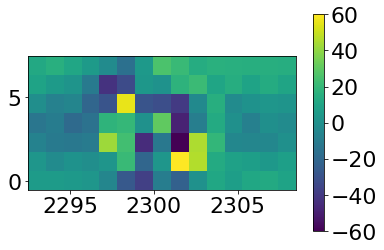

In [455]:
plt.imshow(subim-best_img,vmin=-subim.max()/20., vmax=subim.max()/20.,origin="bottom",extent=lrextent)
plt.colorbar()
f.tight_layout()

In [457]:
np.sum(np.abs((subim-lowres_model).ravel()))/np.sum(subim)

0.042412255402715211

In [459]:
np.sum(np.abs((subim-best_img).ravel()))/np.sum(subim)

0.090339991343720741

## Implement fiber trace algorithm

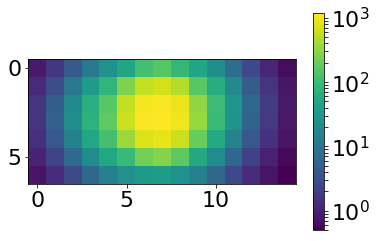

In [226]:
plt.imshow(np.transpose(best_img),norm=LogNorm())
plt.colorbar()

In [299]:
best_img_trans=np.transpose(best_img)

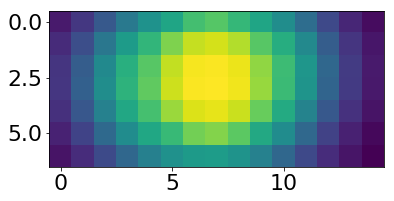

In [300]:
plt.imshow(best_img_trans,norm=LogNorm())

In [301]:
np.shape(best_img_trans)

(7, 15)

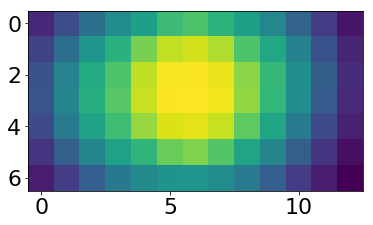

In [243]:
plt.imshow(best_img_trans[:,1:14],norm=LogNorm())

In [330]:
data_shifted_right=np.zeros(np.shape(best_img_trans))
for shift in range(1,15):
    data_shifted = np.concatenate((0.1*best_img_trans[:,shift:15], np.zeros((7,shift))), 1) 
    data_shifted_right += data_shifted

7

In [ ]:
data_shifted_left=np.zeros(np.shape(best_img_trans))
for shift in range(1,15):
    data_shifted = np.concatenate((np.zeros((7,shift)),0.1*best_img_trans[:,0:15-shift]), 1) 
    data_shifted_left += data_shifted

In [388]:
best_img_trans.shape

(7, 15)

In [393]:
def create_trace(best_img,norm_of_trace):
    data_shifted_right=np.zeros(np.shape(best_img))
    for shift in range(1,best_img.shape[1]):
        data_shifted = np.concatenate((norm_of_trace*best_img[:,shift:best_img.shape[1]], np.zeros((best_img.shape[0],shift))), 1) 
        data_shifted_right += data_shifted
    
    data_shifted_left=np.zeros(np.shape(best_img))
    for shift in range(1,best_img.shape[1]):
        data_shifted = np.concatenate((np.zeros((best_img.shape[0],shift)),norm_of_trace*best_img[:,0:best_img.shape[1]-shift]), 1) 
        data_shifted_left += data_shifted
        
    return data_shifted_right+data_shifted_left+best_img

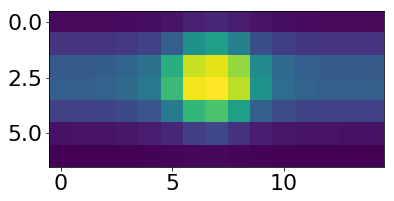

In [439]:
plt.imshow(create_trace(best_img_trans,0.1))

## How does the fiber output actually look like

In [ ]:
# Does it even matter?

## Parallel emcee

In [57]:
number_of_par=14
walkers_mult=8
nwalkers=number_of_par*walkers_mult
parz4Init=np.random.normal(0,0.1,nwalkers)
parz5Init=np.random.normal(0,0.1,nwalkers)
parz6Init=np.random.normal(0,0.1,nwalkers)
parz7Init=np.random.normal(0,0.1,nwalkers)
parz8Init=np.random.normal(0,0.1,nwalkers)
parz9Init=np.random.normal(0,0.1,nwalkers)
parz10Init=np.random.normal(0,0.1,nwalkers)
parz11Init=np.random.normal(0,0.1,nwalkers)
pardxInit=np.random.normal(0,1,nwalkers)
pardyInit=np.random.normal(0,1,nwalkers)
parfiberrInit=np.random.normal(1,0.1,nwalkers)
parfluxmultInit=np.random.normal(1,0.1,nwalkers)
partraceInit=np.random.uniform(0.0,0.001,nwalkers)
parbackgroundInit=np.random.uniform(0.0,100,nwalkers)
par_together=np.column_stack((parz4Init,parz5Init,parz6Init,parz7Init,parz8Init,parz9Init,parz10Init,parz11Init,
                  pardxInit,pardyInit,
                  parfiberrInit,parfluxmultInit,
                  partraceInit,parbackgroundInit))
parInit=par_together.reshape(nwalkers,number_of_par)  

In [58]:
sci_image=subim
var_image=np.ones(subim.shape)

In [59]:
def lnlike_Neven(x,zmax,sci_image,var_image):
   # z4
    if x[0]>1:
        return -np.inf
    if x[0]<-1:
        return -np.inf  

   # dx
    if x[8]>2:
        return -np.inf
    if x[8]<-2:
        return -np.inf  
    
   # dy
    if x[9]>2:
        return -np.inf
    if x[9]<-2:
        return -np.inf      
    
    # fiber_r
    if x[10]<0:
        return -np.inf
    if x[10]>100:
        return -np.inf
    
    # flux_mult
    if x[11]<0:
        return -np.inf
    if x[11]>100:
        return -np.inf
    
    # trace_value
    if x[12]<0:
        return -np.inf
    if x[12]>0.05:
        return -np.inf
    
    # background_value
    if x[13]<0:
        return -np.inf
    if x[13]>100:
        return -np.inf    
    
    single_image_analysis.params['z4'].set(x[0])
    single_image_analysis.params['z5'].set(x[1])
    single_image_analysis.params['z6'].set(x[2])
    single_image_analysis.params['z7'].set(x[3])
    single_image_analysis.params['z8'].set(x[4])
    single_image_analysis.params['z9'].set(x[5])
    single_image_analysis.params['z10'].set(x[6])
    single_image_analysis.params['z11'].set(x[7])
    single_image_analysis.params['dx'].set(x[8])
    single_image_analysis.params['dy'].set(x[9])
    single_image_analysis.params['fiber_r'].set(x[10])
    single_image_analysis.params['flux_mult'].set(x[11])
    single_image_analysis.params['trace_value'].set(x[12])   
    single_image_analysis.params['background_value'].set(x[13])  

    modelImg=single_image_analysis.constructModelImage_PFS(single_image_analysis.params)
    if np.min(modelImg)<0:
        return -np.inf
    image=sci_image
    sigma = np.sqrt(var_image)
    chi = (image - modelImg)/sigma
    chi_without_nan=[]
    chi_without_nan = chi.ravel()[~np.isnan(chi.ravel())]
    res=-(1/2)*(np.sum(chi_without_nan**2))
    #print(np.mean(np.abs(chi_without_nan)))
    return res

In [31]:
#single_image_analysis=ZernikeFitter_PFS(sci_image,var_image,pos=parInit1,npix=160)
#single_image_analysis.initParams(zmax)  
#lnlike_Neven([10,0,0,0,4,0,0,0,0,0,0,7,1,1,1],11,sci_image,var_image)

In [60]:
def logp(x):
    return 0.0

In [ ]:
nT=4
nthreads=4
zmax=11
parInit1=parInit
parInit2=parInit
parInit3=parInit
parInit4=parInit
parInitnT=np.array([parInit1,parInit2,parInit3,parInit4])
single_image_analysis=ZernikeFitter_PFS(sci_image,var_image,pos=parInit1,npix=160)
single_image_analysis.initParams(zmax)  

sampler = emcee.PTSampler(parInitnT.shape[0],parInitnT.shape[1], parInitnT.shape[2], lnlike_Neven,logp,
                threads=nthreads,loglargs=[zmax,sci_image,var_image])

nsteps=2000

for i, result in enumerate(sampler.sample(parInitnT, iterations=nsteps)):
    print('z11PT: '+"{0:5.1%}\r".format(float(i) / nsteps)),

/Users/nevencaplar/anaconda2/lib/python2.7/site-packages/emcee/ptsampler.py:335: RuntimeWarning: invalid value encountered in subtract
  - lnprob[:, jupdate::2]
/Users/nevencaplar/anaconda2/lib/python2.7/site-packages/emcee/ptsampler.py:340: RuntimeWarning: invalid value encountered in less
  accepts = logrs < logpaccept
/Users/nevencaplar/anaconda2/lib/python2.7/site-packages/emcee/ptsampler.py:402: RuntimeWarning: invalid value encountered in subtract
  - dbeta * logl[i - 1, i1perm[asel]]


z11PT:  0.0%
z11PT:  0.1%


/Users/nevencaplar/anaconda2/lib/python2.7/site-packages/emcee/ptsampler.py:384: RuntimeWarning: invalid value encountered in subtract
  paccept = dbeta * (logl[i, iperm] - logl[i - 1, i1perm])
/Users/nevencaplar/anaconda2/lib/python2.7/site-packages/emcee/ptsampler.py:389: RuntimeWarning: invalid value encountered in greater
  asel = (paccept > raccept)


z11PT:  0.1%
z11PT:  0.1%
z11PT:  0.2%
z11PT:  0.2%
z11PT:  0.3%
z11PT:  0.4%
z11PT:  0.4%
z11PT:  0.4%
z11PT:  0.5%
z11PT:  0.5%
z11PT:  0.6%
z11PT:  0.7%
z11PT:  0.7%
z11PT:  0.8%
z11PT:  0.8%
z11PT:  0.9%
z11PT:  0.9%
z11PT:  0.9%
z11PT:  1.0%
z11PT:  1.1%
z11PT:  1.1%
z11PT:  1.1%
z11PT:  1.2%
z11PT:  1.2%
z11PT:  1.3%
z11PT:  1.4%
z11PT:  1.4%
z11PT:  1.5%
z11PT:  1.5%
z11PT:  1.6%
z11PT:  1.6%
z11PT:  1.7%
z11PT:  1.7%
z11PT:  1.8%
z11PT:  1.8%
z11PT:  1.8%
z11PT:  1.9%
z11PT:  1.9%
z11PT:  2.0%
z11PT:  2.1%
z11PT:  2.1%
z11PT:  2.1%
z11PT:  2.2%
z11PT:  2.2%
z11PT:  2.3%
z11PT:  2.4%
z11PT:  2.4%
z11PT:  2.5%
z11PT:  2.5%
z11PT:  2.5%
z11PT:  2.6%
z11PT:  2.6%
z11PT:  2.7%
z11PT:  2.8%
z11PT:  2.8%
z11PT:  2.9%
z11PT:  2.9%
z11PT:  2.9%
z11PT:  3.0%
z11PT:  3.0%
z11PT:  3.1%
z11PT:  3.1%
z11PT:  3.2%
z11PT:  3.2%
z11PT:  3.3%
z11PT:  3.4%
z11PT:  3.4%
z11PT:  3.5%
z11PT:  3.5%
z11PT:  3.5%
z11PT:  3.6%
z11PT:  3.6%
z11PT:  3.7%
z11PT:  3.8%
z11PT:  3.8%
z11PT:  3.9%
z11PT:  3.9%

In [34]:
best_img=single_image_analysis.constructModelImage_PFS(single_image_analysis.params)

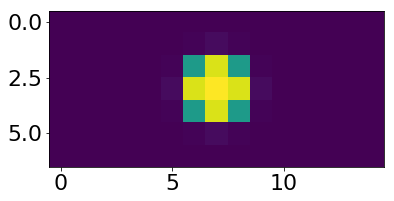

In [35]:
plt.imshow(best_img)

In [119]:
sci_image.shape

(7, 15)

In [50]:
chichain11PT=sampler.lnlikelihood*(-2/((14*7)**2-(13+1)))

In [51]:
chi0=chichain11PT[0]

In [52]:
chain=sampler.chain
chain0=chain[0]

In [53]:
x11PT_output=chain0[chi0==np.min(chi0)][0]

In [54]:
np.min(chi0)

0.054892078198124673

In [55]:
x11PT_output

array([ -0.26744976,  -0.13389071,  -0.21507386,   0.01289399,
         0.02567995,   0.02667201,  -0.00320855,  -0.46646974,
        -0.06331598,  -0.15079959,   1.17678325,   0.89202566,
         0.00083237,  23.05659577])

In [85]:
scidata=subim
vardata=np.sqrt(subim)+20

single_image_analysis=ZernikeFitter_PFS(scidata,vardata)
single_image_analysis.initParams(zmax=11)
x=x11PT_output

single_image_analysis.params['z4'].set(x[0])
single_image_analysis.params['z5'].set(x[1])
single_image_analysis.params['z6'].set(x[2])
single_image_analysis.params['z7'].set(x[3])
single_image_analysis.params['z8'].set(x[4])
single_image_analysis.params['z9'].set(x[5])
single_image_analysis.params['z10'].set(x[6])
single_image_analysis.params['z11'].set(x[7])
single_image_analysis.params['dx'].set(x[8])
single_image_analysis.params['dy'].set(x[9])
single_image_analysis.params['fiber_r'].set(x[10])
single_image_analysis.params['flux_mult'].set(x[11])
single_image_analysis.params['trace_value'].set(x[12]*10)   
single_image_analysis.params['background_value'].set(x[13])   

best_img=single_image_analysis.constructModelImage_PFS(single_image_analysis.params)

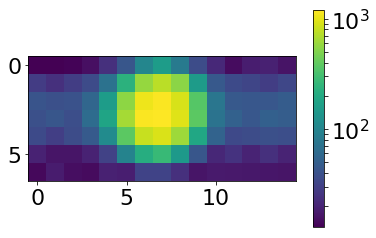

In [64]:
plt.imshow(subim,norm=LogNorm())
plt.colorbar()

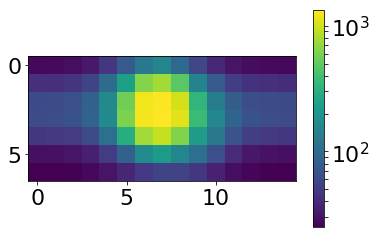

In [86]:
plt.imshow(best_img,norm=LogNorm())
plt.colorbar()

In [67]:
dsubim

array([[ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.]], dtype=float32)

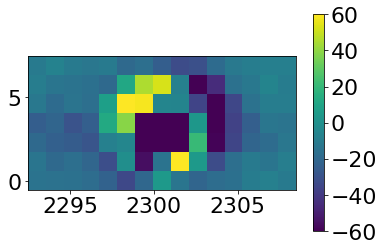

In [87]:
plt.imshow(subim-best_img,vmin=-subim.max()/20., vmax=subim.max()/20.,origin="bottom",extent=lrextent)
plt.colorbar()
f.tight_layout()

In [80]:
print("Max dif:"+str(np.sum(np.abs((subim-lowres_model).ravel()))/np.sum(subim)))
image=sci_image
sigma = np.sqrt(var_image)
chi = (image - lowres_model)/sigma
chi_without_nan=[]
chi_without_nan = chi.ravel()[~np.isnan(chi.ravel())]
res=-(1/2)*(np.sum(chi_without_nan**2))
print(res*(-2/((14*7)**2-(13+1))))

Max dif:0.0424122554027
0.00640260728235


In [88]:
print("My dif:"+str(np.sum(np.abs((subim-best_img).ravel()))/np.sum(subim)))
image=sci_image
sigma = np.sqrt(var_image)
chi = (image - best_img)/sigma
chi_without_nan=[]
chi_without_nan = chi.ravel()[~np.isnan(chi.ravel())]
res=-(1/2)*(np.sum(chi_without_nan**2))
print(res*(-2/((14*7)**2-(13+1))))

My dif:0.166247245113
0.0889448544954


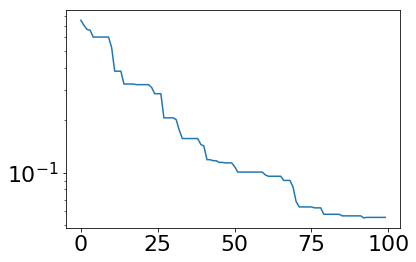

In [61]:
plt.semilogy(np.apply_along_axis(np.min,0,chi0))

In [547]:
np.sum(np.abs((subim-lowres_model)/np.sqrt(subim)))

77.975080194661331

In [62]:
np.sum(np.abs((subim-best_img)/np.sqrt(subim)))

246.24099969855911

In [63]:
best_img

array([[   23.97124831,    24.33229396,    25.50025592,    29.65071802,
           43.73552208,    74.42840923,   120.58646697,   149.82021583,
           94.77060139,    54.75075594,    35.37720017,    27.49975036,
           24.99109649,    24.19920133,    23.90556483],
       [   25.58210874,    26.20046643,    28.59309459,    40.09671092,
           85.51305886,   224.3697793 ,   628.02443052,   762.36515291,
          467.10187904,   134.58900442,    61.26274165,    34.98896362,
           27.75832958,    26.03049113,    25.51192272],
       [   27.5559826 ,    28.36484969,    32.08360499,    52.541959  ,
          133.42021905,   534.97484359,  1202.43876248,  1281.43984413,
         1014.21610826,   310.80075491,   102.2702656 ,    47.1746804 ,
           31.51717089,    28.2947739 ,    27.50945559],
       [   27.76001364,    28.58704882,    32.38061525,    53.05835713,
          133.2992983 ,   578.31190598,  1226.26229573,  1312.60967446,
         1092.26979399,   344.3022914

## How did Max do fiber traces - seems that I am doing it better(!) but I did not model "background" - doing it now above

In [604]:
p_test=p

In [596]:
p_test[0]=0
p_test[1]=0.6
p_test[2]=2310
p_test[3]=3
p_test[4]=1
p_test[5]=1
p_test[6]=1
print(p_test)

[    0.             0.6         2310.             3.             1.             1.
     1.            44.86885563]


In [616]:
p[1]=0.65

In [301]:
X_os,Y_os = oversampleGrid(X,Y,samplef = samplef)
highres_model = peval(p, X_os,Y_os, samplef)
lowres_model =  downsampleData(xx, yy, X_os, Y_os, highres_model)

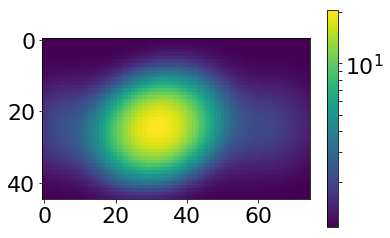

In [302]:
plt.imshow(highres_model,norm=LogNorm())
plt.colorbar()

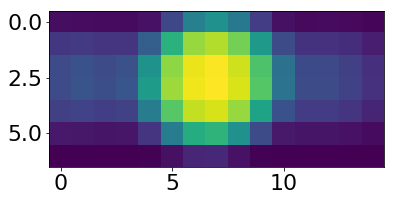

In [619]:
plt.imshow(lowres_model,norm=LogNorm())

In [620]:
np.sum(np.abs((subim-lowres_model)/np.sqrt(subim)))

77.997506486363164

In [621]:
lowres_model[0]

array([  19.01038729,   18.96026927,   18.5197008 ,   18.38879806,
         20.20650535,   41.55667454,  106.19677554,  143.38391408,
         93.04179522,   35.68042468,   19.65240784,   18.36424347,
         18.41295034,   18.275503  ,   17.36972975])

## Creating cutout for Perseus run

In [92]:
np.save("/Users/nevencaplar/Documents/PFS/Max/DataForPerseus/MaxArcSingle",subim)

In [93]:
# Number of free parameters = 19
file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/MaxArcSingle.sh','w') 

file.write("#!/bin/bash")
file.write("\n")
file.write("#SBATCH -N 1 # node count \n")
file.write("#SBATCH --ntasks-per-node=28 \n") 
file.write("#SBATCH -t 23:59:00 \n")
file.write("\n")
file.write("#1. zmax (4,11,22)\n") 
file.write("#2. Obs name (3617)\n") 
file.write("#3. Coordinates (e.g., 73, single number in later)\n") 
file.write("#4. Threads \n") 
file.write("#5. Walkers_mult (at least 2) \n")
file.write("#6. Steps \n") 
file.write("#7. Are you sequentially adding Zernike coef 1 or 0 \n") 
file.write("#8. restart 1 or 0 \n")   
file.write("#9. EM_or_PT  \n")   
file.write("\n")

file.write("python /home/ncaplar/Code/ZernikeForMax.py 11 1 1 28 16 4 1200 PT\n") 
file.close()

In [ ]:
python /home/ncaplar/Code/ZernikeForMax.py 11 1 1 16 4 5 1

## From Perseus

In [ ]:
# Run appropriate image from 3.1 (fiber 266, id=14)

In [424]:
date='Dec08'
chain=np.load('/Users/nevencaplar/Documents/PFS/Fit_Results/'+date+
                 '/chainMaxDec12_11z11PT.npy')
flatchain=np.load('/Users/nevencaplar/Documents/PFS/Fit_Results/'+date+
                 '/flatchainMaxDec12_11z11PT.npy')
likechain=np.load('/Users/nevencaplar/Documents/PFS/Fit_Results/'+date+
                '/likechainMaxDec12_11z11PT.npy')
probchain=np.load('/Users/nevencaplar/Documents/PFS/Fit_Results/'+date+
                '/probchainMaxDec12_11z11PT.npy')

In [425]:
chichain11PT=likechain*(-2/((14*7)**2-(13+1)))
chi0=chichain11PT[0]
chain0=chain[0]
x11PT_output=chain0[chi0==np.min(chi0)][0]

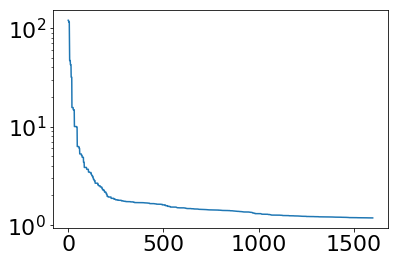

In [426]:
plt.semilogy(np.apply_along_axis(np.min,0,chi0))

In [427]:
x11PT_output

array([  0.21571411,  -0.08341671,   0.03265475,   0.11730856,
        -0.30168659,   0.05105909,  -0.02587044,  -0.39285174,
        -0.04287478,  -0.15202322,   1.28703014,   0.8456541 ,
         0.00697663,  13.71124563])

In [428]:
scidata.shape

(7, 15)

In [429]:
scidata=subim
vardata=np.sqrt(subim)+20

single_image_analysis=ZernikeFitter_PFS(scidata,vardata)
single_image_analysis.initParams(zmax=11)
x=x11PT_output

single_image_analysis.params['z4'].set(x[0])
single_image_analysis.params['z5'].set(x[1])
single_image_analysis.params['z6'].set(x[2])
single_image_analysis.params['z7'].set(x[3])
single_image_analysis.params['z8'].set(x[4])
single_image_analysis.params['z9'].set(x[5])
single_image_analysis.params['z10'].set(x[6])
single_image_analysis.params['z11'].set(x[7])
single_image_analysis.params['dx'].set(x[8])
single_image_analysis.params['dy'].set(x[9])
single_image_analysis.params['fiber_r'].set(x[10])
single_image_analysis.params['flux_mult'].set(x[11])
single_image_analysis.params['trace_value'].set(x[12])   
single_image_analysis.params['background_value'].set(x[13])   

best_img=single_image_analysis.constructModelImage_PFS(single_image_analysis.params)

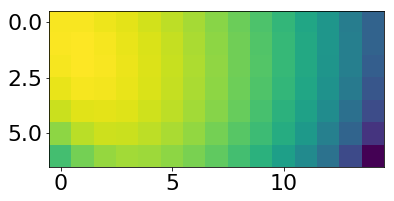

In [430]:
plt.imshow(best_img,norm=LogNorm())

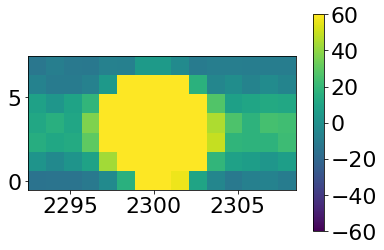

In [431]:
plt.imshow(subim-best_img,vmin=-subim.max()/20., vmax=subim.max()/20.,origin="bottom",extent=lrextent)
plt.colorbar()
f.tight_layout()

In [432]:
np.sum(np.abs((subim-best_img).ravel()))/np.sum(subim)

0.87217567596847978

In [433]:
def simple_definition_best_result(scidata,vardata=None):
    if vardata==None:
        vardata=scidata
    
    scidata_with_noise=scidata+np.random.randn(scidata.shape[0],scidata.shape[1])*np.sqrt(20)+np.random.randn(scidata.shape[0],scidata.shape[1])*np.sqrt((np.abs(vardata)**0.96))
    return np.sum(np.abs((scidata-scidata_with_noise)))/np.sum(scidata_with_noise)

In [434]:
simple_definition_best_result(subim)

0.047941160102795109

In [435]:
res_ideal=[]
for _ in range(10):
    res_ideal.append(simple_definition_best_result(subim))
    
print(np.mean(res_ideal))    

0.0483250735665


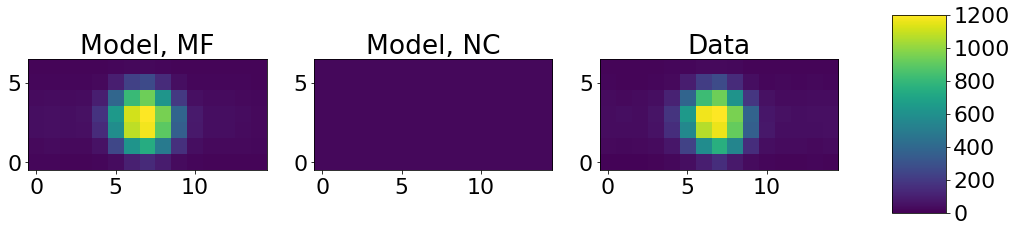

In [436]:
fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(15, 5))
fig.subplots_adjust(left=0.05, bottom=None, right=0.8, top=None,
                wspace=None, hspace=None)
for dat, ax, title in zip([lowres_model,best_img,subim], axes.flat,["Model, MF","Model, NC","Data"]):
    im = ax.imshow(dat,vmin=0,vmax=1200)
    ax.invert_yaxis()
    ax.set_title(title)
    

cax = fig.add_axes([0.85, 0.23, 0.05, 0.55])
fig.colorbar(im, cax=cax)
plt.savefig('/Users/nevencaplar/Documents/PFS/Max/Report1/Fib266Spot14Models.png')
plt.show()   

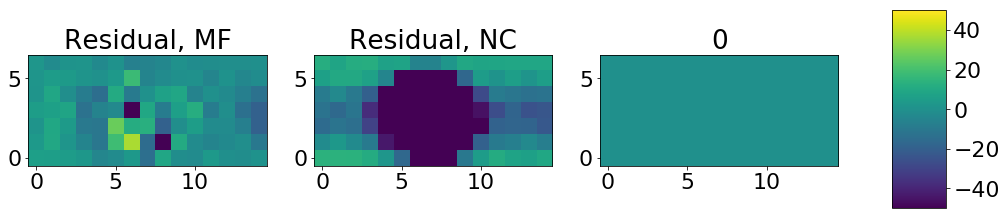

In [437]:
fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(15, 5))
fig.subplots_adjust(left=0.05, bottom=None, right=0.8, top=None,
                wspace=None, hspace=None)
for dat, ax, title in zip([lowres_model-subim,best_img-subim,subim-subim], axes.flat,["Residual, MF","Residual, NC","0"]):
    im = ax.imshow(dat,vmin=-50,vmax=50)
    ax.invert_yaxis()
    ax.set_title(title)
    

cax = fig.add_axes([0.85, 0.23, 0.05, 0.55])
fig.colorbar(im, cax=cax)
plt.savefig('/Users/nevencaplar/Documents/PFS/Max/Report1/Fib266Spot14Residuals.png')
plt.show()   

### Additional images for Max

In [438]:
### ZernikeFitter
class ZernikeFitter_PFS(object):
    
    """!Class to create  donut images in PFS
    The model is constructed using GalSim, and consists of the convolution of
    an OpticalPSF and an input fiber image.  The OpticalPSF part includes the
    specification of an arbitrary number of zernike wavefront aberrations. 
    The centroid parameters are also free parameters.
    Note that to create the images, the parameters must be initialized with the
    `.initParams` method.
    
    This code uses lmfit to initalize the parameters. This is a relic of the code
    in which this class was used to actually fit the parameters
    """
    def __init__(self, image=None,image_var=None,pixelScale=None,
                 jacobian=None,nonUniformEffect=None,diam_sic=None,npix=None,illumminatedFrac=None,**kwargs):
        """
        @param image        image to analyze
        @param image_var    variance image
        @param pixelScale   pixel scale in arcseconds (this is spectroscop)
        @param jacobian     An optional 2x2 Jacobian distortion matrix to apply
                            to the forward model.  Note that this is relative to
                            the pixelScale above.  Default is the identity matrix.
        """
        if image is None:
            image=np.ones((41,41))
            self.image = image
        else:
            self.image = image
        if image_var is None:
            image_var=np.ones((41,41))
            self.image_var=image_var
        else:
            self.image_var = image_var
        #pixel scale choosen so that one pixel = 3/8 arcsec, taken from Smee et al., 2014
        # Note that this is a spectroscop and not an normal optical telescope,
        #so this is not real physical quantity
        pixelScale=geom.Angle(0.000001818/10)
        pixelScale=geom.radToArcsec(pixelScale)
        self.pixelScale=pixelScale
        flux = float(np.sum(image))
        self.flux=flux
        if jacobian is None:
            jacobian = np.eye(2, dtype=np.float64)
        self.jacobian = jacobian
        # Again, wavelength - this is a spectroscop
        wavelength=800 #in units of nm
        self.wavelength=wavelength
        
        if diam_sic is None:
            diam_sic=3.3
            self.diam_sic=diam_sic
        else:
            self.diam_sic=diam_sic
        
        if npix is None:
            npix=128
            self.npix=npix
        else:
            self.npix=npix
            
        if illumminatedFrac is None:
            illumminatedFrac=0.96
            self.illumminatedFrac=illumminatedFrac
        else:
            self.illumminatedFrac=illumminatedFrac
            
        if nonUniformEffect is None:
            nonUniformEffect==False
        else:
            self.nonUniformEffect=nonUniformEffect
            
        self.kwargs = kwargs
    
    def initParams(self, zmax=4, z4Init=None, centroidInit=None,fiber_rInit=None,flux_multInit=None,
                  Kolmogrov_r_Init=None,trace_valueInit=None,background_valueInit=None):
        """Initialize lmfit Parameters object.
        @param zmax                 Total number of Zernike aberrations used
        @param z4Init               Initial Z4 aberration value in waves.
        @param centroidInit         2-tuple for the position of the center of the spot in the image.
        @param hscFracInit          Fraction of the pupil obscuraded by the camera ()
        @param strutFracInit        Fraction of the pupil obscuraded by the single strut
        @param focalPlanePositionInit 2-tuple for position of the central obscuration(camera) in the focal plane
        @param diam_sicInit         Size of the telescope in meters
        @param fiber_rInit          Factor that determines the size of the input fiber
        """
        # Note that order of parameters here must be consistent with order of
        # parameters in the fitDonut schema.
        self.zmax=zmax
        params = lmfit.Parameters()
        #params.add('flux', self.flux,
        #           min = fluxRelativeRange[0]*self.flux,
        #           max = fluxRelativeRange[1]*self.flux)
        if z4Init is None:
            params.add('z4', 0.0)
        else:
            params.add('z4', z4Init)
            
        for i in range(5, self.zmax+1):
            params.add('z{}'.format(i), 0.0)
            
        if centroidInit is None:
            params.add('dx', 0.0)
            params.add('dy', 0.0)
        else:
            params.add('dx', centroidInit[0])
            params.add('dy', centroidInit[1])   
            
            
        if fiber_rInit is None:
            params.add('fiber_r', 1)
        else:
            params.add('fiber_r', fiber_rInit)  
            
        if flux_multInit is None:
            params.add('flux_mult', 1)
        else:
            params.add('flux_mult', flux_multInit)    
                    
            
        if Kolmogrov_r_Init is None:
            params.add('Kolmogrov_r', 10)
        else:
            params.add('Kolmogrov_r', Kolmogrov_r_Init)  
            
        if trace_valueInit is None:
            params.add('trace_value', 0)
        else:
            params.add('trace_value', trace_value_Init)  
     
        if background_valueInit is None:
            params.add('background_value', 0)
        else:
            params.add('background_value', background_value_Init)              
                
        self.params = params
        
    def _getOptPsf(self,params):

        aberrations_init=[0.0,0.0,0.0,0.0]
        aberrations = aberrations_init

        diam_sic=self.diam_sic
        npix=self.npix
        illumminatedFrac=self.illumminatedFrac
        
        
        for i in range(4, self.zmax + 1):
            aberrations.append(params['z{}'.format(i)])
        #print(npix)
        Pupil_Image=PFSPupilFactory(diam_sic,npix,
                                    np.pi/2,illumminatedFrac)
        point=Point2D(0,0)
        pupil=Pupil_Image.getPupil(point)
            
        aper = galsim.Aperture(
            diam =  pupil.size,
            pupil_plane_im = pupil.illuminated.astype(np.int16),
            pupil_plane_scale = pupil.scale,
            pupil_plane_size = None)    
            
            
        big_fft_params = galsim.GSParams(maximum_fft_size=19240) 
        return galsim.OpticalPSF(lam=self.wavelength,diam=aper.diam, 
                                 aberrations = aberrations,aper=aper,gsparams=big_fft_params,pad_factor=1.5)
    
    def create_trace(self,best_img,norm_of_trace):
        data_shifted_right=np.zeros(np.shape(best_img))
        for shift in range(1,best_img.shape[1]):
            data_shifted = np.concatenate((norm_of_trace*best_img[:,shift:best_img.shape[1]], np.zeros((best_img.shape[0],shift))), 1) 
            data_shifted_right += data_shifted

        data_shifted_left=np.zeros(np.shape(best_img))
        for shift in range(1,best_img.shape[1]):
            data_shifted = np.concatenate((np.zeros((best_img.shape[0],shift)),norm_of_trace*best_img[:,0:best_img.shape[1]-shift]), 1) 
            data_shifted_left += data_shifted

        return data_shifted_right+data_shifted_left+best_img
    
    def constructModelImage_PFS(self,params=None,shape=None,pixelScale=None,jacobian=None,nonUniformEffect=False):
        """Construct model image from parameters
        @param params      lmfit.Parameters object or python dictionary with
                           param values to use, or None to use self.params
        @param pixelScale  pixel scale in arcseconds to use for model image,
                           or None to use self.pixelScale.
        @param jacobian    An optional 2x2 Jacobian distortion matrix to apply
                           to the forward model.  Note that this is relative to
                           the pixelScale above.  Use self.jacobian if this is
                           None.
        @param shape       (nx, ny) shape for model image, or None to use
                           the shape of self.maskedImage
        @returns           numpy array image with the same flux as the input image
        """
        if params is None:
            params = self.params
        if shape is None:
            shape = self.image.shape
        if pixelScale is None:
            pixelScale = self.pixelScale
        if jacobian is None:
            jacobian = self.jacobian   
        #params.add('flux', flux,
        #       min = fluxRelativeRange[0]*flux,
        #       max = fluxRelativeRange[1]*flux)


        #This creates opticalpsf
        if nonUniformEffect==False:
            # 1 component
            try:
                v = params.valuesdict()
            except AttributeError:
                v = params
                
            optPsf=self._getOptPsf(v)
            optPsf = optPsf.shift(v['dx'], v['dy'])
            wcs = galsim.JacobianWCS(*list(pixelScale*jacobian.ravel()))
            gal = galsim.TopHat(flux=1, radius=(3/8)*(3/2)*v['fiber_r'])
            
           # atmPsf = galsim.Kolmogorov(lam=self.wavelength, r0=v['Kolmogrov_r'])
            #smooth_psf = galsim.Convolve(gal, atmPsf)
            
            big_fft_params = galsim.GSParams(maximum_fft_size=10240)
            final = galsim.Convolve([gal, optPsf],gsparams=big_fft_params)
            modelImg = final.drawImage(
            nx = shape[1],
            ny = shape[0],
            wcs = wcs)
            multiplicative_factor=self.flux*v['flux_mult']
            return_img_before_trace=multiplicative_factor*modelImg.array
            return_img_after_trace=self.create_trace(return_img_before_trace,v['trace_value'])
            return return_img_after_trace+v['background_value']
        else:
            # 3 components
            try:
                v = params.valuesdict()
            except AttributeError:
                v = params
            
                        
            v['illumminatedFrac']=0.96
            optPsf1=self._getOptPsf(v)
            optPsf1 = optPsf1.shift(v['dx'], v['dy'])
            v['illumminatedFrac']=0.986
            optPsf2=self._getOptPsf(v)
            optPsf2 = optPsf2.shift(v['dx'], v['dy'])
            v['illumminatedFrac']=1
            optPsf3=self._getOptPsf(v)
            optPsf3 = optPsf3.shift(v['dx'], v['dy'])
            
            wcs = galsim.JacobianWCS(*list(pixelScale*jacobian.ravel()))
            gal1 = galsim.TopHat(flux=0.32, radius=(3/8)*(3/2)*v['fiber_r'])
            gal2 = galsim.TopHat(flux=0.334, radius=(3/8)*(3/2)*v['fiber_r'])
            gal3 = galsim.TopHat(flux=0.346, radius=(3/8)*(3/2)*v['fiber_r'])
            
            final1 = galsim.Convolve([gal1, optPsf1])
            final2 = galsim.Convolve([gal2, optPsf2])
            final3 = galsim.Convolve([gal3, optPsf3])
            
            modelImg1 = final1.drawImage(nx = shape[0],ny = shape[1],wcs = wcs)
            modelImg2 = final2.drawImage(nx = shape[0],ny = shape[1],wcs = wcs)
            modelImg3 = final3.drawImage(nx = shape[0],ny = shape[1],wcs = wcs)
            
            modelImg=np.add(np.add(modelImg1.array,modelImg2.array),modelImg3.array)
            
            multiplicative_factor=self.flux*v['flux_mult']
            #I did not implement trace or adding background in nonUniform model
            return multiplicative_factor*modelImg

    def _chi_PFS(self, params):
        """Compute 'chi' image: (data - model)/sigma
        @param params  lmfit.Parameters object.
        @returns       Unraveled chi vector.
        """
        modelImg = self.constructModelImage_PFS(params)
        sigma = np.sqrt(self.image_var)
        chi = (self.image - modelImg)/sigma
        chi_without_nan=[]
        chi_without_nan = chi.ravel()[~np.isnan(chi.ravel())]
        print("chi**2/d.o.f. is:"+str(np.mean((chi_without_nan)**2)))
        return chi_without_nan
       
# I think I do not need anything below
    def best_image_Neven(self, params):
        """
        @param params  lmfit.Parameters object.
        @returns       Unraveled chi vector.
        """
        modelImg = self.constructModelImage_Neven(params)
        return modelImg
    
    def residual_image_Neven(self, params):
        """

        """
        modelImg = self.constructModelImage_Neven(params)
        return (self.image - modelImg)
    
    def fit_emcee(self):
        """Do the fit using emcee
        @returns  result as an lmfit.MinimizerResult.
        """
        print("Doing fit using emcee")
        mini = lmfit.Minimizer(self._chi_PFS, self.params)
        self.result = mini.emcee(nwalkers=64,burn=100, steps=200, thin=1, 
                                 is_weighted=True,ntemps=1,workers=1,**self.kwargs)
        return self.result 
    
    def fit_LM(self):
        """Do the fit using Levenberg-Marquardt 
        @returns  result as an lmfit.MinimizerResult.
        """
        print("Doing fit using Levenberg-Marquardt")
        self.result = lmfit.minimize(self._chi_PFS, self.params,**self.kwargs)
        return self.result
    
    def report(self, *args, **kwargs):
        """Return a string with fit results."""
        return lmfit.fit_report(self.result, *args, **kwargs) 

In [439]:
scidata=subim
vardata=np.sqrt(subim)+20

single_image_analysis=ZernikeFitter_PFS()
single_image_analysis.initParams(zmax=11)
x=x11PT_output

single_image_analysis.params['z4'].set(0)
single_image_analysis.params['z5'].set(x[1])
single_image_analysis.params['z6'].set(x[2])
single_image_analysis.params['z7'].set(x[3])
single_image_analysis.params['z8'].set(x[4])
single_image_analysis.params['z9'].set(x[5])
single_image_analysis.params['z10'].set(x[6])
single_image_analysis.params['z11'].set(x[7])
single_image_analysis.params['dx'].set(x[8])
single_image_analysis.params['dy'].set(x[9])
single_image_analysis.params['fiber_r'].set(0.01)
single_image_analysis.params['flux_mult'].set(x[11])
single_image_analysis.params['trace_value'].set(0)   
single_image_analysis.params['background_value'].set(0)   

best_img=single_image_analysis.constructModelImage_PFS(single_image_analysis.params)

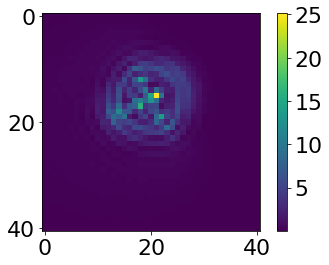

In [440]:
plt.imshow(best_img)
plt.colorbar()

In [441]:
x

array([  0.21571411,  -0.08341671,   0.03265475,   0.11730856,
        -0.30168659,   0.05105909,  -0.02587044,  -0.39285174,
        -0.04287478,  -0.15202322,   1.28703014,   0.8456541 ,
         0.00697663,  13.71124563])

## Creating cutout2 for Perseus run

xmin = 3115,xmax = 3130
x0 = 6,y0 = 4
   A0 =5013.723, BG0 =1.00, mux0 = 3121.000, muy0 = 8.000, sigmax0 = 0.600, sigmay0 = 0.600, sigmaxy0 =0.100, tA0 =40.000
2.92 s to fit.
standard deviation =  1.5882
equal weight RMS =  16.1832
A =7690.832, BG =1.08, mux = 3121.386, muy = 8.889, sigmax = 1.385, sigmay = 1.051, sigmaxy =-0.374, tA =42.305
dA =99.215, dBG =0.02, dmux = 0.025, dmuy = 0.019, dsigmax = 0.026, dsigmay = 0.022, dsigmaxy =0.042, dtA =2.690


/Users/nevencaplar/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:89: RuntimeWarning: invalid value encountered in log


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

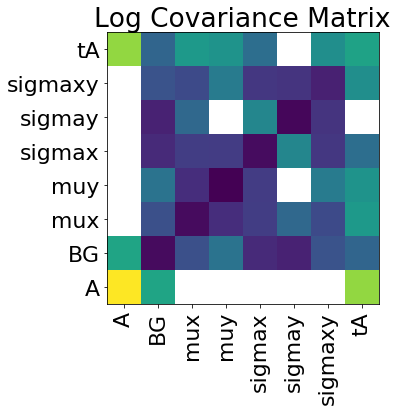

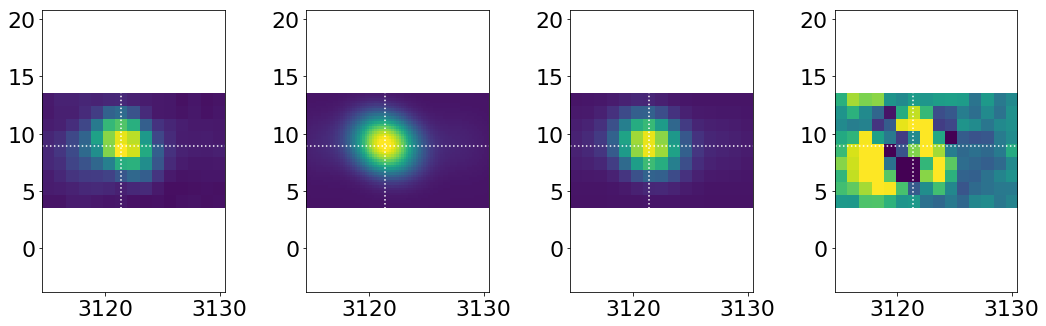

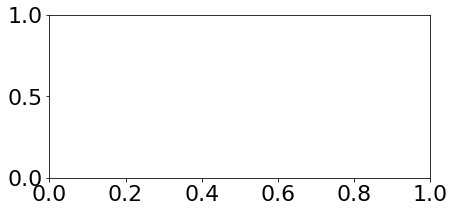

In [80]:
# importing
from scipy.optimize import least_squares
import time
% matplotlib inline

xw = 15
yw = 9
RN = 5. / np.sqrt(11.)
samplef = 5

#156 5562.77


#goodpeaks = [4,5,6,11,13,14,15,16,17,18,19,20,21]
goodpeaks = [4,5,6,13,14,15,16,17,18,19,20,21]

fib = 266
#ipeak = 9
xc,yc = arcpeaks_dict[arcpeaks_dict.keys()[ 21 ]][fib]
#xc,yc = arcpeaks_dict[ 5562.77][fib]
#print xc,yc

ymin,ymax = np.max( [int(round(yc)-yw/2.)+1,0] ),np.min( [int(round(yc)+yw/2.)+1, arc.shape[0]] )
xmin,xmax = np.max( [int(round(xc)-xw/2.)+1,0] ),np.min( [int(round(xc)+xw/2.)+1, arc.shape[1]] )


print("xmin = {},xmax = {}".format(xmin,xmax))
subim = arc[ ymin:ymax,xmin:xmax ]


xx = np.arange(xmin,xmax)
yy = np.arange(ymin,ymax)
X,Y = np.meshgrid(xx,yy)



#P0 = [   6.33 , 10., (xw-1.)/2.+xmin,  (yw-1.)/2.+ymin,   0.6, 0.6,  -0.0, 30.]
#P0 = [   6.33 , 0., (xw-1.)/2.+xmin,  (yw-1.)/2.+ymin,   0.6, 0.6,  -0.0, 30.]
y0,x0 = np.unravel_index(subim.argmax(), subim.shape)
print("x0 = {},y0 = {}".format(x0,y0))

P0 = [   subim.max()*10. , 1., x0+xmin,  y0+ymin,   0.6, 0.6,  0.1, 40.]
#P0 = [   subim.max() , 1., x0+xmin,  y0+ymin,   0.6, 0.6,  -0.0, 0.1]

A0, BG0, mux0, muy0, sigmax0, sigmay0, sigmaxy0, tA0 = P0 
print("   A0 ={:.3f}, BG0 ={:.2f}, mux0 = {:.3f}, muy0 = {:.3f}, sigmax0 = {:.3f}, sigmay0 = {:.3f}, sigmaxy0 ={:.3f}, tA0 ={:.3f}".\
  format(A0, BG0, mux0, muy0, sigmax0, sigmay0, sigmaxy0, tA0))
        

#A =3.920, BG =7.90, mux = 1644.110, muy = 1006.652, sigmax = 0.596, sigmay = 0.411, sigmaxy =-0.045, tA =29.771

#dsubim = np.ones_like(subim)
dsubim = np.sqrt(subim + RN**2.)

bounds = ( [0., 0., 0., 0., 0.1, 0.1, -1., 0.], [np.inf, np.inf, 4000., 2100., 2., 2., 1., np.inf]) 

starttime = time.time()
fit = least_squares(resid,P0, args = (X,Y,subim, dsubim, samplef), bounds=bounds )
endtime = time.time()
print("{:.2f} s to fit.".format(endtime-starttime))

p = fit.x
#p = P0

f = plt.figure(figsize=[15,5])

X_os,Y_os = oversampleGrid(X,Y,samplef = samplef)
highres_model = peval(p, X_os,Y_os, samplef)
lowres_model =  downsampleData(xx, yy, X_os, Y_os, highres_model)

dsubim = np.sqrt(subim + RN**2.)
res = resid(p, X, Y, subim, dsubim, samplef)
print ("standard deviation =  {:.4f}".format(np.std(res)))

dsubim = np.ones_like(subim)
res = resid(p, X, Y, subim, dsubim, samplef)
print ("equal weight RMS =  {:.4f}".format(np.std(res)))



A, BG, mux, muy, sigmax, sigmay, sigmaxy, tA = fit.x 

print("A ={:.3f}, BG ={:.2f}, mux = {:.3f}, muy = {:.3f}, sigmax = {:.3f}, sigmay = {:.3f}, sigmaxy ={:.3f}, tA ={:.3f}".\
      format(A, BG, mux, muy, sigmax, sigmay, sigmaxy, tA))



H = fit.jac.T.dot(fit.jac)
f = plt.figure(figsize=[5,5])

plt.imshow(np.log(1./H), origin='bottom')
plt.title("Log Covariance Matrix")
plt.xticks(np.arange(len(fit.x)), ["A", "BG", "mux", "muy", "sigmax", "sigmay", "sigmaxy", "tA"], rotation=90.)
plt.yticks(np.arange(len(fit.x)), ["A", "BG", "mux", "muy", "sigmax", "sigmay", "sigmaxy", "tA"], rotation=0.)

dA, dBG, dmux, dmuy, dsigmax, dsigmay, dsigmaxy, dtA = np.sqrt( (1./H).diagonal() )
print("dA ={:.3f}, dBG ={:.2f}, dmux = {:.3f}, dmuy = {:.3f}, dsigmax = {:.3f}, dsigmay = {:.3f}, dsigmaxy ={:.3f}, dtA ={:.3f}".\
      format(dA, dBG, dmux, dmuy, dsigmax, dsigmay, dsigmaxy, dtA))


f = plt.figure(figsize=[15,5])
ax1 = plt.subplot(1,4,1)
lrextent = [float(xmin)-.5,float(xmax)+.5,float(ymin)-.5,float(ymax)+.5]
#lrextent = [100,200,100,200]
#print "lrextent", lrextent
plt.imshow( subim,vmin=0, vmax=subim.max(),origin="bottom",extent=lrextent)
plt.axvline(mux,c='w',ls=':')
plt.axhline(muy,c='w',ls=':')

ax2 = plt.subplot(1,4,2, sharex=ax1, sharey=ax1)
#hrextent = [X_os.min()-.5/samplef,X_os.max()+.5/samplef,Y_os.min()-.5/samplef,Y_os.max()+.5/samplef]
hrextent = lrextent
plt.imshow( highres_model,vmin=0, vmax=subim.max()/samplef**2.,origin="bottom",extent=hrextent)
plt.axvline(mux,c='w',ls=':')
plt.axhline(muy,c='w',ls=':')

ax3 = plt.subplot(1,4,3, sharex=ax1, sharey=ax1)
plt.imshow(lowres_model,vmin=0, vmax=subim.max(),origin="bottom",extent=lrextent)
plt.axvline(mux,c='w',ls=':')
plt.axhline(muy,c='w',ls=':')

ax4 = plt.subplot(1,4,4, sharex=ax1, sharey=ax1)
plt.imshow(subim-lowres_model,vmin=-subim.max()/20., vmax=subim.max()/20.,origin="bottom",extent=lrextent)
plt.axvline(mux,c='w',ls=':')
plt.axhline(muy,c='w',ls=':')
f.tight_layout()


f = plt.figure(figsize=[15,3])

ax1 = plt.subplot(1,2,1)
plt.plot(subim[yw/2,:],drawstyle='steps-mid', label="data")
plt.plot(lowres_model[yw/2,:],drawstyle='steps-mid', label="model")
plt.xlabel("X")

plt.subplot(1,2,2, sharey=ax1)
plt.plot(subim[:,xw/2],drawstyle='steps-mid', label="data")
plt.plot(lowres_model[:,xw/2],drawstyle='steps-mid', label="model")
plt.xlabel("Y")

l = plt.legend()
f.tight_layout()

#yshift = fit_yshift(subim, lowres_model, PLOT=False)
#p = A, BG, mux , muy + yshift[0], sigmax, sigmay, sigmaxy, tA 
#highres_model = peval(p, X_os,Y_os, samplef)
#lowres_model =  downsampleData(xx, yy, X_os, Y_os, highres_model)
#res = resid(p, X, Y, subim, dsubim, samplef)
#print ("RMS =  {:.4f}".format(np.std(res)))
#fit_yshift(subim, lowres_model, PLOT=True)

In [84]:
X_os,Y_os = oversampleGrid(X,Y,samplef = samplef)
highres_model = peval(p, X_os,Y_os, samplef)
lowres_model =  downsampleData(xx, yy, X_os, Y_os, highres_model)

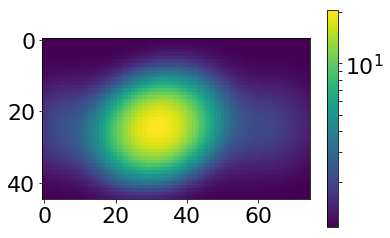

In [85]:
plt.imshow(highres_model,norm=LogNorm())
plt.colorbar()

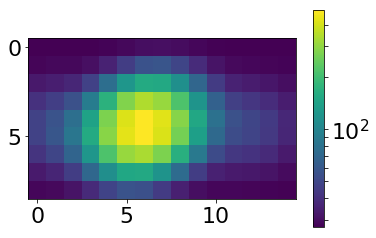

In [86]:
plt.imshow(lowres_model,norm=LogNorm())
plt.colorbar()

In [87]:
np.sum(np.abs((subim-lowres_model)/np.sum(subim)))

0.12181070300617394

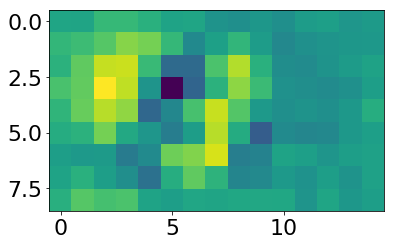

In [81]:
plt.imshow(subim-lowres_model)

In [82]:
np.save("/Users/nevencaplar/Documents/PFS/Max/DataForPerseus/MaxArcSingleCorner",subim)

## Analyzing cutout 2

In [442]:
date='Dec08'
chain=np.load('/Users/nevencaplar/Documents/PFS/Fit_Results/'+date+
                 '/chainMaxDec12Corner_11z11PT.npy')
flatchain=np.load('/Users/nevencaplar/Documents/PFS/Fit_Results/'+date+
                 '/flatchainMaxDec12Corner_11z11PT.npy')
likechain=np.load('/Users/nevencaplar/Documents/PFS/Fit_Results/'+date+
                '/likechainMaxDec12Corner_11z11PT.npy')
probchain=np.load('/Users/nevencaplar/Documents/PFS/Fit_Results/'+date+
                '/probchainMaxDec12Corner_11z11PT.npy')

In [443]:
chichain11PT=likechain*(-2/((14*7)**2-(13+1)))
chi0=chichain11PT[0]
chain0=chain[0]
x11PT_output=chain0[chi0==np.min(chi0)][0]

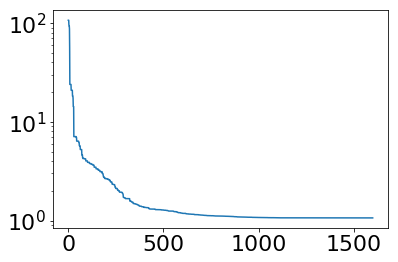

In [444]:
plt.semilogy(np.apply_along_axis(np.min,0,chi0))

In [445]:
x11PT_output

array([  0.08076863,  -1.00340127,  -0.43976008,  -0.24150994,
        -0.49714204,  -0.03642536,  -1.11983876,  -0.33680155,
        -0.36843045,   0.18694715,   1.26133554,   0.6519177 ,
         0.0038898 ,  30.83506932])

In [446]:
scidata=subim
vardata=np.sqrt(subim)+20

single_image_analysis=ZernikeFitter_PFS(scidata,vardata)
single_image_analysis.initParams(zmax=11)
x=x11PT_output

single_image_analysis.params['z4'].set(x[0])
single_image_analysis.params['z5'].set(x[1])
single_image_analysis.params['z6'].set(x[2])
single_image_analysis.params['z7'].set(x[3])
single_image_analysis.params['z8'].set(x[4])
single_image_analysis.params['z9'].set(x[5])
single_image_analysis.params['z10'].set(x[6])
single_image_analysis.params['z11'].set(x[7])
single_image_analysis.params['dx'].set(x[8])
single_image_analysis.params['dy'].set(x[9])
single_image_analysis.params['fiber_r'].set(x[10])
single_image_analysis.params['flux_mult'].set(x[11])
single_image_analysis.params['trace_value'].set(x[12])   
single_image_analysis.params['background_value'].set(x[13])   

best_img=single_image_analysis.constructModelImage_PFS(single_image_analysis.params)

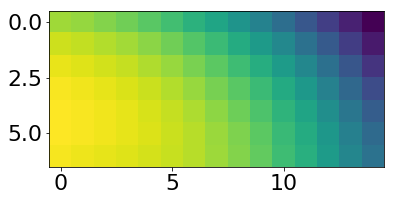

In [447]:
plt.imshow(best_img,norm=LogNorm())

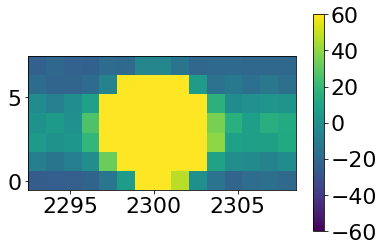

In [448]:
plt.imshow(subim-best_img,vmin=-subim.max()/20., vmax=subim.max()/20.,origin="bottom",extent=lrextent)
plt.colorbar()
f.tight_layout()

In [449]:
np.var(subim-best_img)

84895.738466178242

In [450]:
np.sum(np.abs((subim-best_img).ravel()))/np.sum(subim)

0.85645856882170757

In [451]:
subim_with_noise=subim+np.random.randn(subim.shape[0],subim.shape[1])*np.sqrt(15)+np.random.randn(subim.shape[0],subim.shape[1])*np.sqrt(subim**0.96)

In [452]:
np.sum(np.abs((subim_with_noise-subim).ravel()))/np.sum(subim)

0.045714308522754127

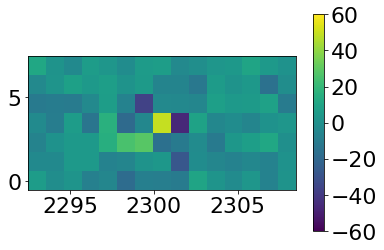

In [453]:
plt.imshow(subim_with_noise-subim,vmin=-subim.max()/20., vmax=subim.max()/20.,origin="bottom",extent=lrextent)
plt.colorbar()

### Additional images for Max

In [454]:
scidata=subim
vardata=np.sqrt(subim)+20

single_image_analysis=ZernikeFitter_PFS()
single_image_analysis.initParams(zmax=11)
x=x11PT_output

single_image_analysis.params['z4'].set(x[0])
single_image_analysis.params['z5'].set(x[1])
single_image_analysis.params['z6'].set(x[2])
single_image_analysis.params['z7'].set(x[3])
single_image_analysis.params['z8'].set(x[4])
single_image_analysis.params['z9'].set(x[5])
single_image_analysis.params['z10'].set(x[6])
single_image_analysis.params['z11'].set(x[7])
single_image_analysis.params['dx'].set(0)
single_image_analysis.params['dy'].set(-0.1)
single_image_analysis.params['fiber_r'].set(0.01)
single_image_analysis.params['flux_mult'].set(x[11])
single_image_analysis.params['trace_value'].set(0)   
single_image_analysis.params['background_value'].set(0)   

best_img=single_image_analysis.constructModelImage_PFS(single_image_analysis.params)

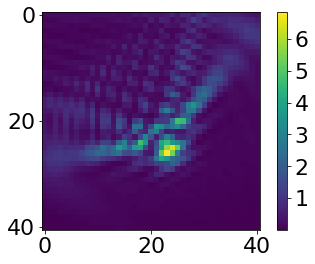

In [455]:
plt.imshow(best_img)
plt.colorbar()

In [456]:
x

array([  0.08076863,  -1.00340127,  -0.43976008,  -0.24150994,
        -0.49714204,  -0.03642536,  -1.11983876,  -0.33680155,
        -0.36843045,   0.18694715,   1.26133554,   0.6519177 ,
         0.0038898 ,  30.83506932])

##  autocorellation function

### Spot 14

In [278]:
test_data=subim-best_img

In [279]:
res=[]
for j1 in range(len(test_data)):
    for j2 in range(len(test_data[j1])):
        for i1 in range(len(test_data)):
            for i2 in range(len(test_data[i1])):
                res.append([int(np.round(np.sqrt((i1-j1)**2+(i2-j2)**2))),((test_data[j1,j2]-np.mean(test_data))*(test_data[i1,i2]-np.mean(test_data)))/(test_data[j1,j2]-np.mean(test_data))**2])
        
res=np.array(res)  
#This is to eliminate double counting
res[:,1]=res[:,1]

In [281]:
acf=[]
for i in range(10):
    acf.append([res[i][0],[np.percentile(x, 25) for x in np.transpose((res[res[:,0]==i]))][1],[np.percentile(x, 50) for x in np.transpose((res[res[:,0]==i]))][1],[np.percentile(x, 75) for x in np.transpose((res[res[:,0]==i]))][1]])
    
acf=np.array(acf)  
acf_realdata=acf

In [310]:
test_data=lowres_model-subim

In [311]:
res=[]
for j1 in range(len(test_data)):
    for j2 in range(len(test_data[j1])):
        for i1 in range(len(test_data)):
            for i2 in range(len(test_data[i1])):
                res.append([int(np.round(np.sqrt((i1-j1)**2+(i2-j2)**2))),((test_data[j1,j2]-np.mean(test_data))*(test_data[i1,i2]-np.mean(test_data)))/(test_data[j1,j2]-np.mean(test_data))**2])
        
res=np.array(res)  
#This is to eliminate double counting
res[:,1]=res[:,1]

In [312]:
acf=[]
for i in range(10):
    acf.append([res[i][0],[np.percentile(x, 25) for x in np.transpose((res[res[:,0]==i]))][1],[np.percentile(x, 50) for x in np.transpose((res[res[:,0]==i]))][1],[np.percentile(x, 75) for x in np.transpose((res[res[:,0]==i]))][1]])
    
acf=np.array(acf)  
acf_MF=acf

In [267]:
acf_many=[]
for l in range(10):
    subim_with_noise=subim+np.random.randn(subim.shape[0],subim.shape[1])*np.sqrt(15)+np.random.randn(subim.shape[0],subim.shape[1])*np.sqrt(subim**0.96)
    test_data=subim_with_noise-subim
    res=[]
    for j1 in range(len(test_data)):
        for j2 in range(len(test_data[j1])):
            for i1 in range(len(test_data)):
                for i2 in range(len(test_data[i1])):
                    res.append([int(np.round(np.sqrt((i1-j1)**2+(i2-j2)**2))),((test_data[j1,j2]-np.mean(test_data))*(test_data[i1,i2]-np.mean(test_data)))/(test_data[j1,j2]-np.mean(test_data))**2])

    res=np.array(res)  
    #This is to eliminate double counting
    res[:,1]=res[:,1]
    acf=[]
    for i in range(10):
        acf.append([res[i][0],[np.percentile(x, 25) for x in np.transpose((res[res[:,0]==i]))][1],[np.percentile(x, 50) for x in np.transpose((res[res[:,0]==i]))][1],[np.percentile(x, 75) for x in np.transpose((res[res[:,0]==i]))][1]])

    acf=np.array(acf)  
    acf_many.append(acf)

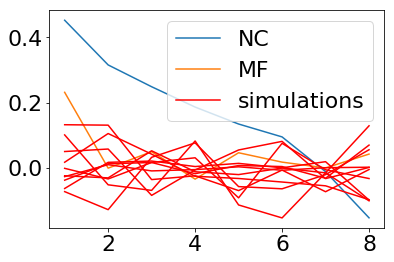

In [314]:
plt.plot(acf_realdata[1:9,0],acf_realdata[1:9,2],label='NC')
plt.plot(acf_MF[1:9,0],acf_MF[1:9,2],label='MF')
plt.plot(acf_many[0][1:9,0],acf_many[0][1:9,2],'r',label='simulations')
plt.plot(acf_many[1][1:9,0],acf_many[1][1:9,2],'r')
plt.plot(acf_many[2][1:9,0],acf_many[2][1:9,2],'r')
plt.plot(acf_many[3][1:9,0],acf_many[3][1:9,2],'r')
plt.plot(acf_many[4][1:9,0],acf_many[4][1:9,2],'r')
plt.plot(acf_many[5][1:9,0],acf_many[5][1:9,2],'r')
plt.plot(acf_many[6][1:9,0],acf_many[6][1:9,2],'r')
plt.plot(acf_many[7][1:9,0],acf_many[7][1:9,2],'r')
plt.plot(acf_many[8][1:9,0],acf_many[8][1:9,2],'r')
plt.plot(acf_many[9][1:9,0],acf_many[9][1:9,2],'r')
plt.legend()


### Spot 21

In [330]:
test_data=subim-best_img

In [331]:
res=[]
for j1 in range(len(test_data)):
    for j2 in range(len(test_data[j1])):
        for i1 in range(len(test_data)):
            for i2 in range(len(test_data[i1])):
                res.append([int(np.round(np.sqrt((i1-j1)**2+(i2-j2)**2))),((test_data[j1,j2]-np.mean(test_data))*(test_data[i1,i2]-np.mean(test_data)))/(test_data[j1,j2]-np.mean(test_data))**2])
        
res=np.array(res)  
#This is to eliminate double counting
res[:,1]=res[:,1]

In [332]:
acf=[]
for i in range(10):
    acf.append([res[i][0],[np.percentile(x, 25) for x in np.transpose((res[res[:,0]==i]))][1],[np.percentile(x, 50) for x in np.transpose((res[res[:,0]==i]))][1],[np.percentile(x, 75) for x in np.transpose((res[res[:,0]==i]))][1]])
    
acf=np.array(acf)  
acf_realdata=acf

In [333]:
test_data=lowres_model-subim

In [335]:
res=[]
for j1 in range(len(test_data)):
    for j2 in range(len(test_data[j1])):
        for i1 in range(len(test_data)):
            for i2 in range(len(test_data[i1])):
                res.append([int(np.round(np.sqrt((i1-j1)**2+(i2-j2)**2))),((test_data[j1,j2]-np.mean(test_data))*(test_data[i1,i2]-np.mean(test_data)))/(test_data[j1,j2]-np.mean(test_data))**2])
        
res=np.array(res)  
#This is to eliminate double counting
res[:,1]=res[:,1]

In [336]:
acf=[]
for i in range(10):
    acf.append([res[i][0],[np.percentile(x, 25) for x in np.transpose((res[res[:,0]==i]))][1],[np.percentile(x, 50) for x in np.transpose((res[res[:,0]==i]))][1],[np.percentile(x, 75) for x in np.transpose((res[res[:,0]==i]))][1]])
    
acf=np.array(acf)  
acf_MF=acf

In [337]:
acf_many=[]
for l in range(10):
    subim_with_noise=subim+np.random.randn(subim.shape[0],subim.shape[1])*np.sqrt(15)+np.random.randn(subim.shape[0],subim.shape[1])*np.sqrt(subim**0.96)
    test_data=subim_with_noise-subim
    res=[]
    for j1 in range(len(test_data)):
        for j2 in range(len(test_data[j1])):
            for i1 in range(len(test_data)):
                for i2 in range(len(test_data[i1])):
                    res.append([int(np.round(np.sqrt((i1-j1)**2+(i2-j2)**2))),((test_data[j1,j2]-np.mean(test_data))*(test_data[i1,i2]-np.mean(test_data)))/(test_data[j1,j2]-np.mean(test_data))**2])

    res=np.array(res)  
    #This is to eliminate double counting
    res[:,1]=res[:,1]
    acf=[]
    for i in range(10):
        acf.append([res[i][0],[np.percentile(x, 25) for x in np.transpose((res[res[:,0]==i]))][1],[np.percentile(x, 50) for x in np.transpose((res[res[:,0]==i]))][1],[np.percentile(x, 75) for x in np.transpose((res[res[:,0]==i]))][1]])

    acf=np.array(acf)  
    acf_many.append(acf)

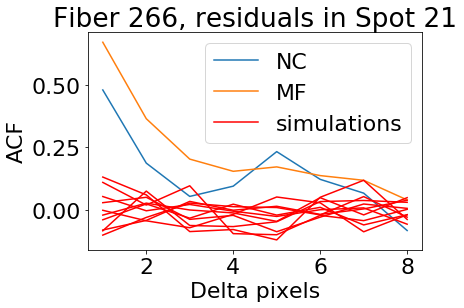

In [344]:
plt.plot(acf_realdata[1:9,0],acf_realdata[1:9,2],label='NC')
plt.plot(acf_MF[1:9,0],acf_MF[1:9,2],label='MF')
plt.plot(acf_many[0][1:9,0],acf_many[0][1:9,2],'r',label='simulations')
plt.plot(acf_many[1][1:9,0],acf_many[1][1:9,2],'r')
plt.plot(acf_many[2][1:9,0],acf_many[2][1:9,2],'r')
plt.plot(acf_many[3][1:9,0],acf_many[3][1:9,2],'r')
plt.plot(acf_many[4][1:9,0],acf_many[4][1:9,2],'r')
plt.plot(acf_many[5][1:9,0],acf_many[5][1:9,2],'r')
plt.plot(acf_many[6][1:9,0],acf_many[6][1:9,2],'r')
plt.plot(acf_many[7][1:9,0],acf_many[7][1:9,2],'r')
plt.plot(acf_many[8][1:9,0],acf_many[8][1:9,2],'r')
plt.plot(acf_many[9][1:9,0],acf_many[9][1:9,2],'r')
plt.legend()
plt.xlabel("Delta pixels")
plt.ylabel("ACF")
plt.title("Fiber 266, residuals in Spot 21")


# Try various models (does not work below this line)

TypeError: m > k must hold

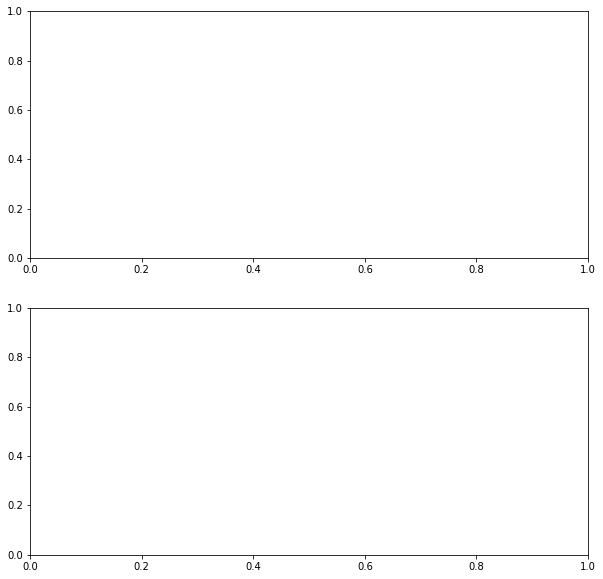

In [34]:
# try fitting splines to individual fibers
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d, splrep, splev
from numpy.polynomial.chebyshev import chebfit, chebval
                                   

f = plt.figure(figsize=(10,10))
ax1 =  plt.subplot(2,1,1)
ax2 =  plt.subplot(2,1,2)

#ii = t['fib'] == 133
#xx,yy = t['wl'][ii],  t['mux'][ii]

#for i in [102,103,104,106]:
#for i in [132]:
    
# try how well the wavelength solution on fiber i fits fiber j
i,j = 65,65
kappa = 1.5

# fit plint to mux(lambda) for fiber i
ii = t['fib'] == i
ii *= t['stddev'] < kappa
xx,yy = t['wl'][ii], t['mux'][ii]

tck = splrep(xx, yy, s=0)
spl_mm =  splev(xx, tck, der=0)

mm = spl_mm

res = mm - yy
rms = np.std(res)
print("RMS = {}".format(rms))


ii = t['fib'] == j
ii *= t['stddev'] < kappa
xx,yy,dyy = t['wl'][ii], t['mux'][ii], t['dmux'][ii]
spl_mm =  splev(xx, tck, der=0)
mm = spl_mm

res = mm - yy
rms = np.std(res)
print("RMS = {}".format(rms))


ax1.plot( xx,yy,'s')
ax1.plot( xx, mm ,'--')
ax2.plot( xx, mm - yy ,'s')
ax2.errorbar( xx, mm - yy ,dyy)

ax1.set_ylabel("x [px]")    
ax2.set_ylabel("res. x [px]")
ax2.set_xlabel("wl [A]")
ax2.axhline(0.)

print t['stddev'][ii]

RMS = 3.14213820271e-13
[ True  True  True  True  True  True  True  True  True  True  True  True]


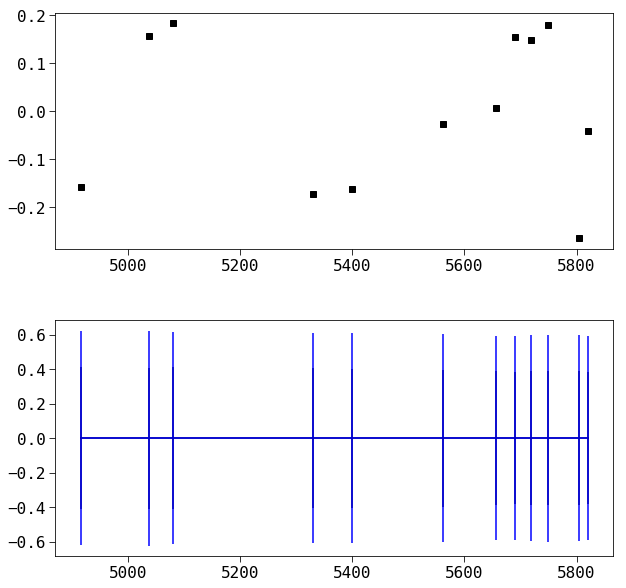

In [177]:
# fit spline to the mean mux across many fibers
from astropy.stats import biweight_midvariance, biweight_location
wls = np.sort ( np.unique(t['wl']) )
fibers = np.sort ( np.unique(t['fib']) )

xx,yy,dyy,dyy2 = [],[],[],[]

ff = np.arange(113,153)

for wl in wls:
    ii = t['fib'] == ff[0]
    for f in ff[1:]:
        ii += t['fib'] == f
        
    ii *= t['wl'] == wl
    #print (sum(ii))
    yy.append( biweight_location(t['mux'][ii]) )
    dyy.append( np.sqrt(biweight_midvariance(t['mux'][ii])) )
    dyy2.append( np.std((t['mux'][ii])) )
    xx.append(wl)

xx = np.array(xx)
yy = np.array(yy)
dyy = np.array(dyy)
dyy2 = np.array(dyy2)
    
tck = splrep(xx, yy, s=0)
mm =  splev(xx, tck, der=0)
res = mm - yy
rms = np.std(res)
print("RMS = {}".format(rms))

f = plt.figure(figsize=(10,10))
ax1 =  plt.subplot(2,1,1)
ax2 =  plt.subplot(2,1,2)

ii = dyy < .75
# poly fitting only to take out low orders
q = np.polyfit(xx,yy,deg=3) 

ax1.plot( xx, (yy) - np.polyval(q,xx) ,'s')

ax2.errorbar( xx[ii], (mm-yy)[ii] ,dyy2[ii] )

ax2.errorbar( xx[ii], (mm-yy)[ii] ,dyy[ii] )
print ii

0.0159868164753


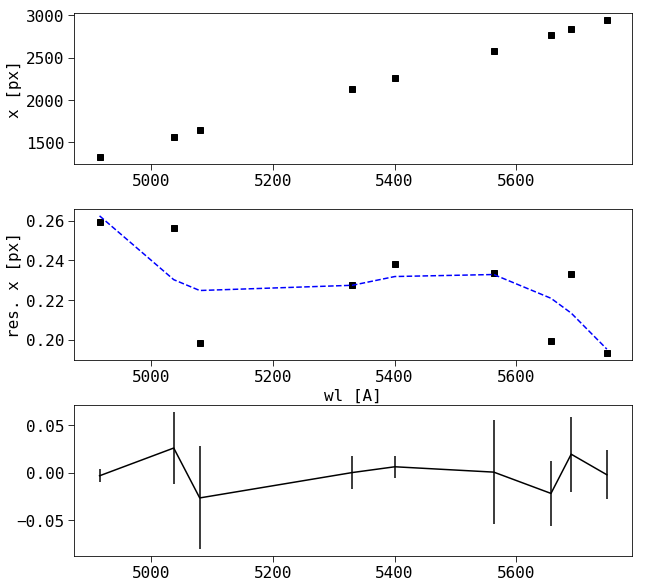

In [206]:
# now check how individual fibers compare against that "mean spline)
f = plt.figure(figsize=(10,10))
ax1 =  plt.subplot(3,1,1)
ax2 =  plt.subplot(3,1,2)
ax3 =  plt.subplot(3,1,3)

ii = t['fib'] == 133
# filter specific wavelengths
ii *= t['wl'] != np.sort( np.unique(t['wl']) )[-1]
ii *= t['wl'] != np.sort( np.unique(t['wl']) )[-2]
ii *= t['wl'] != np.sort( np.unique(t['wl']) )[-4]

#ii *= t['stddev'] < kappa
xx,yy,dyy = t['wl'][ii], t['mux'][ii], t['dmux'][ii]
spl_mm =  splev(xx, tck, der=0)
mm = spl_mm

res = mm - yy

np.polyfit(xx,res, deg =0)

ax1.plot( xx,yy,'s')
#ax1.plot( xx, mm ,'--')


ax2.plot( xx, mm - yy ,'s')
#ax2.errorbar( xx, mm - yy ,dyy)


# poly fitting only to take out low orders
q = np.polyfit(xx, mm - yy, deg=3) 
ax2.plot( xx, np.polyval(q,xx),'--' )
             
#ax2.errorbar( xx, (yy) - np.polyval(q,mm - yy) , dyy, 's')

res2 = (mm - yy) - np.polyval(q,xx)
print np.std(res2)
ax3.errorbar( xx, (mm - yy) - np.polyval(q,xx), dyy  )


ax1.set_ylabel("x [px]")    
ax2.set_ylabel("res. x [px]")
ax2.set_xlabel("wl [A]")
#ax2.axhline(0.)

In [134]:
# try limiting the wavelength range
print wls.tolist()

ii = t['wl'] < 5600.


kappa = 2.5

# on a wavelength by wavelength basis reject outliers in stddev
ii = t['wl'] > 0
wls = np.sort ( np.unique(t['wl']) )
for wl in wls:
    jj = t['wl'] == wl
    m      = ( biweight_location(t['RMS'][jj]) )
    stddev = ( np.sqrt(biweight_midvariance(t['RMS'][jj])) )
    
    kk = np.abs(t['RMS'] - m) > kappa*stddev
    
    ii[jj * kk] = False
    print ("Rejecting {} form mn={} stddev={}".format(np.sum(jj*kk), m, stddev))
    
    

[4916.06982421875, 5037.75, 5080.3798828125, 5330.77978515625, 5400.56005859375, 5562.77001953125, 5656.66015625, 5689.81982421875, 5719.22021484375, 5748.2998046875, 5804.4501953125, 5820.16015625]
Rejecting 98 form mn=29.6313762665 stddev=2.72850420927
Rejecting 5 form mn=4.30661201477 stddev=0.613613596178
Rejecting 0 form mn=3.71170520782 stddev=0.519969009952
Rejecting 22 form mn=7.43015480042 stddev=1.12887350106
Rejecting 39 form mn=13.4539747238 stddev=1.57653949964
Rejecting 4 form mn=3.80396485329 stddev=0.578101530536
Rejecting 6 form mn=5.24814224243 stddev=0.752739907141
Rejecting 6 form mn=4.37793207169 stddev=0.686801365818
Rejecting 21 form mn=4.06617593765 stddev=0.640083462134
Rejecting 38 form mn=7.14865541458 stddev=1.23622494412
Rejecting 24 form mn=7.38489246368 stddev=1.3308928387
Rejecting 56 form mn=17.9630718231 stddev=2.03888602961


In [135]:
ii = t['stddev'] < 2.5
#print("Fitting f,l -> x ...")
m_fl2x       = Model2D(map(fcoord, t['fib'][ii]), t['wl'][ii], t['mux'][ii], deg=7, PLOT=False)

% matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=[20,10])
ax = fig.add_subplot(121, projection='3d')

res = (t['mux'] - m_fl2x(map(fcoord, t['fib']),t['wl'] ))[ii]
#ax.plot(t['fib'][ii], t['wl'][ii], (t['mux'] - m_fl2x(map(fcoord, t['fib']),t['wl'] ))[ii] ,'.')
ax.plot(t['fib'][ii], t['wl'][ii], res ,'.')
plt.ylabel("wl [A]")
plt.xlabel("fiber [#]")

jj = res > 1.


print("Found {} remaining bad fits: ".format(sum(jj)))

#for f,w,x in zip( t['fib'][ii][jj], t['wl'][ii][jj], t['mux'][ii][jj]):
#    print f, w, x

KeyError: 266

## model PSF parameters as 2D Chebychev 

In [101]:
from numpy.polynomial.chebyshev import chebval2d
from astropy.stats import biweight_midvariance, biweight_location
from scipy.optimize import least_squares
    
range = lambda x : x.max()-x.main()

def norm(x, minimum = None, scale = None):
    if minimum == None and scale == None:
        scale   = max(x)-min(x)
        minimum = min(x)
    return (x - minimum)/(scale), minimum, scale


class Model2D():
    def __init__(self, x, y, z, deg, PLOT=False):
        self.C = None
        self.FP_XMIN  = None
        self.FP_YMIN  = None
        self.FP_XSCALE = None
        self.FP_YSCALE = None
        self.fit(x, y, z, deg, PLOT)
        pass

    
    def __call__(self, x, y):
        nx, __, __ = norm(x, minimum = self.FP_XMIN, scale = self.FP_XSCALE)
        ny, __, __ = norm(y, minimum = self.FP_YMIN, scale = self.FP_YSCALE)
        return chebval2d(nx, ny, self.C)


    def fit(self, x, y, z, deg, PLOT, kappa=3.5):
        
        x = np.array(x)
        y = np.array(y)
        z = np.array(z)
        
        self.deg = deg
        nx, self.FP_XMIN, self.FP_XSCALE = norm(x)
        ny, self.FP_YMIN, self.FP_YSCALE = norm(y)


        # model distortion map as 2D chebychev
        def peval(p, nx, ny, deg):
            c = p.reshape( [deg+1,deg+1] )
            return chebval2d(nx, ny, c)

        def resid(p, nx, ny, deg, field):
            res = peval(p, nx, ny, deg) - field
            return res

        #print("   Fitting ...")
        c = np.ones([deg+1,deg+1])
        p0 = c.flatten()
        
        # fit with kappa sigma klipping
        ii = np.ones_like(z,dtype=bool) 
        print("Fitting to {} points.".format(np.sum(ii)))
        cnt = 0
        while True:
            
            fit = least_squares(resid, p0, args=(nx[ii], ny[ii], deg, z[ii]))
            self.C = fit.x.reshape( [deg+1,deg+1] )
            ## better to excercise the actual used code
            #RMS = np.std(resid(fit.x, nx, ny, deg, z))
            res = self(x,y) - z
            RMS = np.std(res[ii])


            v = biweight_midvariance(res[ii])
            m = biweight_location(res[ii])

            jj = np.abs(res) < m + kappa * np.sqrt(v)
            #print("Found total of {} outliers.".format(np.sum(~jj)))
            _ii = (ii * jj)
            cnt += 1
            if np.sum(_ii) == np.sum(ii):
                break
            ii = _ii
        print("Converged after {} iterations. Found total of {} outliers.".format(cnt, np.sum(~jj)))
        
        if PLOT:
            f = plt.figure(figsize=[10,7.5])
            #plt.plot(nx,ny,'x')
            plt.plot(x,y,'x')
            plt.plot(np.array(x)[~ii],np.array(y)[~ii],'rx')
            #for x,y,_z,_zm in zip(nx,ny,z, peval(fit.x, nx, ny, deg) ):
            for _x,_y,_z,_zm in zip(x,y,z, self(x,y) ):
                plt.text(_x,_y,"{:.2f}\n{:.2f}".format(_z,_zm),rotation=90)
                
        
        print("Fit success: {} RMS = {:.3f}".format(fit.success, RMS))
        print("")

deg = 5    
    

# model the fiber coordinate
# define a fiducial wavelength
wl_fid = arcpeaks_dict.keys()[14]
ii = t['wl'] == wl_fid
# the fiber coordinate goes as follows:
# For the n-th fiber the fiber coordinate equals the y-pixel position
# of the arcpeak at the fiducial wavelength 
yy_fid = t['muy'][ii] 

fcoord_dict = {}
for f,y in zip(t['fib'][ii], t['muy'][ii]):
    fcoord_dict[f] = y

fcoord = lambda fib :  fcoord_dict[fib]

# filter specific wavelengths
jj  = t['wl'] != np.sort( np.unique(t['wl']) )[-2]
jj *= t['wl'] != np.sort( np.unique(t['wl']) )[-6]

print("Fitting f,l -> x ...")
m_fl2x       = Model2D(map(fcoord, t['fib'][jj]), t['wl'][jj], t['mux'][jj], deg=deg, PLOT=False)

print("Fitting x,y -> sigmax ...")
m_xy2sigmax  = Model2D(t['mux'][jj], t['muy'][jj], t['sigmax'][jj], deg=deg)
print("Fitting x,y -> sigmay ...")
m_xy2sigmay  = Model2D(t['mux'][jj], t['muy'][jj], t['sigmay'][jj], deg=deg)
print("Fitting x,y -> sigmaxy ...")
m_xy2sigmaxy = Model2D(t['mux'][jj], t['muy'][jj], t['sigmaxy'][jj], deg=deg)
print("Fitting x,y -> f ...")
m_xy2f       = Model2D(t['mux'][jj], t['muy'][jj], map(fcoord, t['fib'][jj]), deg=deg)
print("Fitting x,y -> l ...")
m_xy2l       = Model2D(t['mux'][jj], t['muy'][jj], t['wl'][jj], deg=deg)
print("Fitting f,x -> l ...")
m_fx2l       = Model2D(map(fcoord, t['fib'][jj]), t['mux'][jj], t['wl'][jj], deg=deg)
print("Fitting l,y -> f ...")
m_ly2l       = Model2D(t['wl'][jj], t['muy'][jj], map(fcoord, t['fib'][jj]), deg=deg)
print("Fitting f,l -> sigmax ...")
m_fl2sigmax  = Model2D(map(fcoord, t['fib'][jj]), t['wl'][jj], t['sigmax'][jj], deg=deg)
print("Fitting f,l -> sigmay ...")
m_fl2sigmay  = Model2D(map(fcoord, t['fib'][jj]), t['wl'][jj], t['sigmay'][jj], deg=deg)
print("Fitting f,l -> sigmaxy ...")
m_fl2sigmaxy = Model2D(map(fcoord, t['fib'][jj]), t['wl'][jj], t['sigmaxy'][jj], deg=deg)
print("Fitting f,l -> y ...")
m_fl2y       = Model2D(map(fcoord, t['fib'][jj]), t['wl'][jj], t['muy'][jj], deg=deg)
print("Fitting f,x -> y ...")
m_fx2y       = Model2D(map(fcoord, t['fib'][jj]), t['mux'][jj], t['muy'][jj], deg=deg)


Fitting f,l -> x ...
Fitting to 2678 points.
Converged after 1 iterations. Found total of 0 outliers.
Fit success: True RMS = 0.058

Fitting x,y -> sigmax ...
Fitting to 2678 points.
Converged after 1 iterations. Found total of 0 outliers.
Fit success: True RMS = 0.043

Fitting x,y -> sigmay ...
Fitting to 2678 points.
Converged after 1 iterations. Found total of 0 outliers.
Fit success: True RMS = 0.043

Fitting x,y -> sigmaxy ...
Fitting to 2678 points.
Converged after 1 iterations. Found total of 0 outliers.
Fit success: True RMS = 0.038

Fitting x,y -> f ...
Fitting to 2678 points.
Converged after 1 iterations. Found total of 0 outliers.
Fit success: True RMS = 0.025

Fitting x,y -> l ...
Fitting to 2678 points.
Converged after 1 iterations. Found total of 0 outliers.
Fit success: True RMS = 0.030

Fitting f,x -> l ...
Fitting to 2678 points.
Converged after 1 iterations. Found total of 0 outliers.
Fit success: True RMS = 0.030

Fitting l,y -> f ...
Fitting to 2678 points.
Converge

Fitting to 2678 points.
Converged after 1 iterations. Found total of 0 outliers.
Fit success: True RMS = 0.054



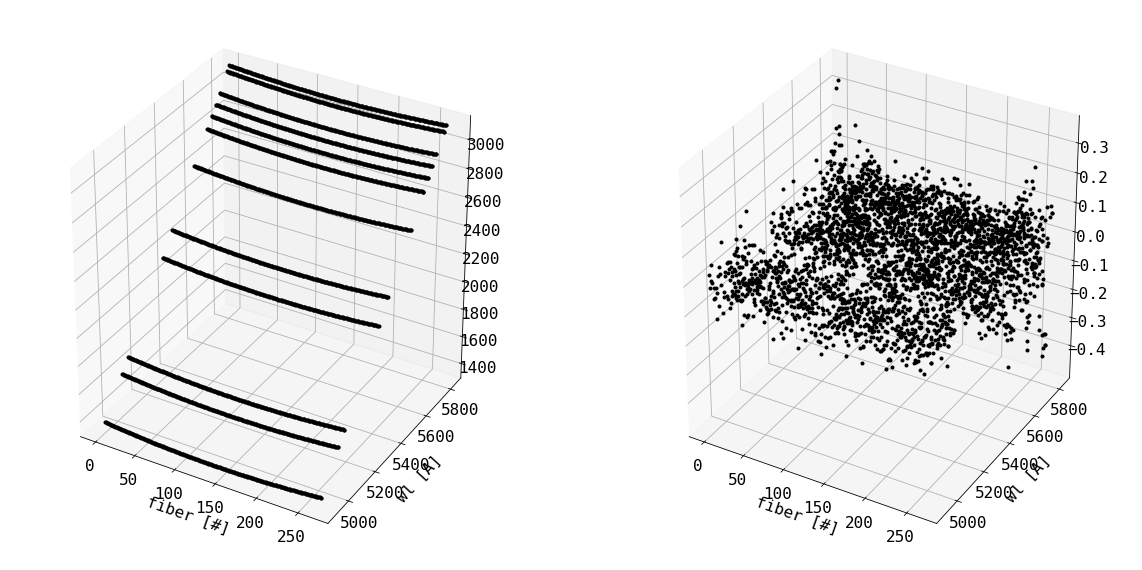

In [102]:
# see how well we are doing
% matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=[20,10])
ax = fig.add_subplot(121, projection='3d')

plt.plot(t['fib'],t['wl'], t['mux'],'.')
plt.ylabel("wl [A]")
plt.xlabel("fiber [#]")

#print("Fitting f,l -> x ...")
m_fl2x       = Model2D(map(fcoord, t['fib'][jj]), t['wl'][jj], t['mux'][jj], deg=7, PLOT=False)

ax = fig.add_subplot(122, projection='3d')
plt.plot(t['fib'], t['wl'], t['mux'] - m_fl2x(map(fcoord, t['fib']),t['wl'] ) ,'.')
plt.ylabel("wl [A]")
plt.xlabel("fiber [#]")

#W,F = np.meshgrid(t['wl'],t['fib'])
# Plot a basic wireframe.
#ax = fig.add_subplot(111, projection='3d')

#plt.zlabel("sigmax")

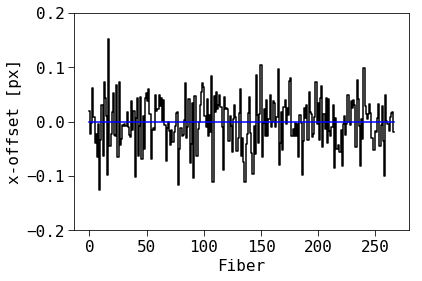

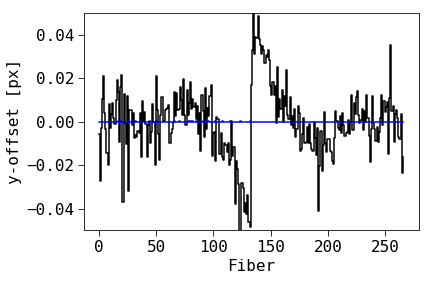

In [110]:
# fit fiber to fiber x,y offsets from model
from astropy.stats import biweight_midvariance, biweight_location
f = plt.figure(figsize=[15,4])

def fitOffsets(t, fcoord, model, param='mux', dparam='dmux', fo=None):
    # fit x offsets on fiber by fiber basis
    foffsets = OrderedDict()
    for f in np.unique(t['fib']):
        ii = t['fib'] == f
        ff =  np.array(map(fcoord, t['fib']))[ii]
        ww = t['wl'][ii]
        xx = t[param][ii]
        dxx = t[dparam][ii]
        if fo != None:
            xx -= fo[f]
        offsets = xx - model( ff, ww )
        moffset = biweight_location(offsets)
        #moffset = np.average(offsets, weights=1./dxx)
        foffsets[f] =  moffset
    return foffsets

# fit fiber to fiber x offsets from model
f = plt.figure()
xoffsets = fitOffsets(t, fcoord, m_fl2x, param='mux', dparam='dmux')
plt.plot(xoffsets.keys(),xoffsets.values(), drawstyle='steps-mid')

# Rerun, confirm that they are zero now
xoffsets2 = fitOffsets(t, fcoord, m_fl2x, param='mux', dparam='dmux', fo=xoffsets)
plt.plot(xoffsets2.keys(),xoffsets2.values(),  drawstyle='steps-mid')

plt.ylim([-.2,.2])
plt.xlabel("Fiber")
plt.ylabel("x-offset [px]")

# fit fiber to fiber y offsets from model
f = plt.figure()
yoffsets = fitOffsets(t, fcoord, m_fl2y, param='muy', dparam='dmuy')
plt.plot(yoffsets.keys(),yoffsets.values(), drawstyle='steps-mid')
plt.ylim([-.2,.2])

# Rerun, confirm that they are zero now
yoffsets2 = fitOffsets(t, fcoord, m_fl2y, param='muy', dparam='dmuy', fo=yoffsets)
plt.plot(yoffsets2.keys(),yoffsets2.values(),  drawstyle='steps-mid')
plt.ylim([-.05,.05])
plt.xlabel("Fiber")
plt.ylabel("y-offset [px]")

# Intersting, I believe the last plot shows a CTE issue


0.016648931792


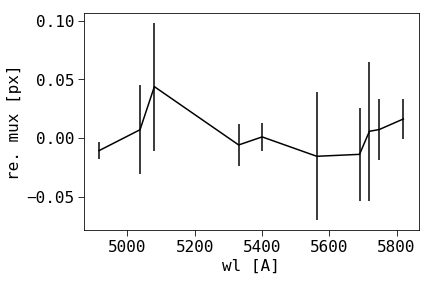

In [111]:
# plot residuals from model 
fib = 133


jj  = t['stddev'] < np.inf
jj *= t['wl'] != np.sort( np.unique(t['wl']) )[-2]
jj *= t['wl'] != np.sort( np.unique(t['wl']) )[-6]
jj *= t['fib'] == fib

rs = t['mux'][jj] - m_fl2x(map(fcoord, t['fib'][jj]), t['wl'][jj]) - xoffsets[fib]

xx,yy,dyy = t['wl'][jj], t['mux'][jj], t['dmux'][jj]

print np.std( rs )

f = plt.figure()
ax = fig.add_subplot(122, projection='3d')

plt.errorbar(t['wl'][jj], rs,t['dmux'][jj])


plt.ylabel("re. mux [px]")
plt.xlabel("wl [A]")


5043.49247408
5404.77232772


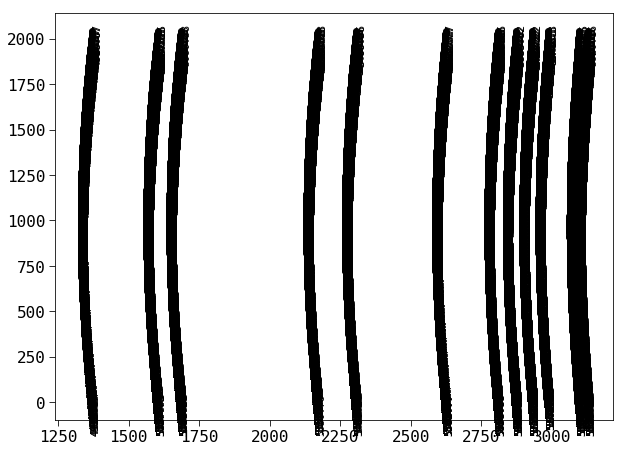

In [145]:
f = plt.figure(figsize=[10,7.5])
plt.plot(t['mux'], map(fcoord, t['fib']) ,'o') 

for x,f,w in zip(t['mux'], map(fcoord, t['fib']), t['wl']):
        plt.text(x,f,w, rotation=90)


print m_fx2l(133,1600)
print m_fx2l(133,2300)

# Spectral extraction routines

In [26]:
def createLowresModels(minx ,maxx, miny, maxy, fib,  wlstep, samplef, yshift=0., wlstart=None, wlstop=None, DEBUG=False, NORM=False, fixXoffset=True, fixYoffset=True):
    xx = np.arange(minx,maxx )
    yy = np.arange(miny,maxy)
    
    if wlstart == None:
        wlstart =  m_fx2l(fcoord(fib),minx)
    if wlstop == None:
        wlstop = m_fx2l(fcoord(fib),maxx)
        
    X,Y = np.meshgrid(xx, yy)
    X_os,Y_os = oversampleGrid( X,Y , samplef=samplef)
    
    ll = np.arange(wlstart,wlstop,wlstep)
    models = []
    lowres_models = []
    for l in ll:
        mux, muy = m_fl2x(fcoord(fib),l) , m_fl2y(fcoord(fib),l) + yshift
        
        if fixXoffset:
            mux -= xoffsets[fib]
        if fixYoffset:
            muy -= yoffsets[fib]
            
        
        sigmax, sigmay = m_fl2sigmax(fcoord(fib),l), m_fl2sigmay(fcoord(fib),l)
        sigmaxy = m_fl2sigmaxy(fcoord(fib),l)
        tA = 0.
        A = 1.
        BG = 0.
        p = A, BG, mux, muy, sigmax, sigmay, sigmaxy, tA
        models.append( peval(p, X_os, Y_os,samplef) )
        
        lrm = downsampleData(xx,yy,X_os,Y_os,models[-1])
        if NORM:
            lrm / sum(lrm.flatten())
        lowres_models.append( lrm )

        if DEBUG:
            print("lambda = {:.3f}".format(l))
            print("fib = {:d}".format(fib))
            print("mux = {:.3f}".format(mux))
            print("muy = {:.3f}".format(muy))
            print("sigmax = {:.3f}".format(sigmax))
            print("sigmay = {:.3f}".format(sigmay))
            print("sigmaxy = {:.3f}".format(sigmaxy))
            print("Model max: {}".format( model.max() ) )
            print("Model any nan: {}".format( np.isnan(model).any() ) )
            print(" ")

    models = np.array(models)
    lowres_models = np.array(lowres_models)
    return lowres_models, models, X_os, Y_os, ll 

In [27]:
def fit_spectrum(subim, models,ll, smoothing, ff0=None, CONSTRAIN_POS = False):
    """
    Uses least_squares nonlinear fitting routine with
    penalisation of second derivative to fit
    model images to spectrum.
    """
    def fpanel(ff):
        p = np.mean( (np.diff( np.diff(ff)))**2. )
        return p
    
    def peval(p,models):
        if CONSTRAIN_POS:
            _p = np.abs(p)
        else:
            _p = p
        return np.sum( np.array( [w*m for w,m in zip(p,models)] ), axis=0 )
    
    def resid(p,models,subim,smoothing):
        model = peval(p,models)
        res = subim - model
        
        panel = fpanel( p ) # calculate panelisation 

        res += smoothing*(panel)
    
        return res.flatten()
    
    # initial guess given? Otherwise start with all ones.
    p0 = ff0
    if ff0 == None:
        p0 = np.ones_like(ll)
    
    fit = least_squares(resid, p0, args=(models,subim,smoothing) )
    
    p = fit.x
    model = peval(p,models)
    res = subim - model 
    RMS = np.std(res)
    print("Fit success: {} RMS = {:.3f} RMS/mean = {:.3f}".format(fit.success, RMS, RMS/np.mean(subim) ))
    
    if CONSTRAIN_POS:
        return np.abs(p), model, RMS
    else:
        return p, model, RMS
    

In [ ]:
# test when smoothing starts to affect RMS 
# erxtract with different smoothing values
ss = np.exp( np.linspace(np.log(5e-5),np.log(5e-2),20.) )
results = []
for s in ss:
    
    ff, model, RMS = fit_spectrum(subim, lowres_models,ll, smoothing=s)
    results.append([s,RMS])
    
results = np.array(results)

f = plt.figure()
ax1 = plt.subplot(2,1,1)
plt.plot( (results[:,0]), (results[:,1]),'o')
plt.xscale('log')
plt.xlabel('smoothing')
plt.ylabel('RMS')

plt.subplot(2,1,2, sharex = ax1)
plt.plot( results[:,0][:-1], np.diff(results[:,1]),'o')
plt.xscale('log')
plt.xlabel('smoothing')
plt.ylabel('dRMS/dsmoothing')

In [147]:
# plot highres trace
def plotTrace(models, xx, yy ,X_os,Y_os, minx, maxx, miny, maxy):
    extent = [minx, maxx, miny, maxy]
    f = plt.figure(figsize = [15,5])
    plt.subplot(2,1,1)
    plt.imshow( np.sum(models,axis=0) , extent=extent, origin="bottom", interpolation='None')
    plt.subplot(2,1,2)
    plt.imshow( downsampleData(xx,yy,X_os,Y_os,np.sum(models,axis=0)) , extent=extent, origin="bottom", interpolation='None')
    f.tight_layout()
    
def plotExtraction(subim, model, ll, ff, wstart, wstop, miny, maxy,sigma=0.55):
    vmax=subim.max()
    vmin=subim.min()
    # plot extraction
    f = plt.figure(figsize = [7,10])
    extent=[ wstart, wstop, miny-0.5,maxy+0.5 ]
    
    ax1 = plt.subplot(4,1,1)
    plt.ylabel("y [px]")
    cax1 = plt.imshow( subim , extent=extent, origin="bottom", interpolation='None',vmin=vmin,vmax=vmax)
    plt.text(.9,.9,"data", ha='right', va='top', transform=ax1.transAxes)
    #cbar = f.colorbar(cax1, orientation='vertical')

    ax2 = plt.subplot(4,1,2, sharex=ax1, sharey=ax1)
    plt.ylabel("y [px]")
    cax2 = plt.imshow( model , extent=extent, origin="bottom", interpolation='None',vmin=vmin,vmax=vmax)
    plt.text(.9,.9, "model", ha='right', va='top', transform=ax2.transAxes)
    #cbar = f.colorbar(cax2, orientation='vertical')
    
    ax3 = plt.subplot(4,1,3, sharex=ax1)
    plt.ylabel("y [px]")

    dA = ll[1]-ll[0]
    xx = np.arange(-100.,100.+dA,dA)
    g = mfutils.gauss(0.,sigma, xx)
    g = g/np.sum(g)
    ibff= fftconvolve(ff,g,mode='same')
        
    plt.plot(ll,ff, drawstyle = 'steps-mid',label="extr. resolution")
    plt.plot(ll,ibff, drawstyle = 'steps-mid',label="sigma = {}".format(sigma))
    l = plt.legend(loc=2)
    l.draw_frame(False)
    plt.text(.9,.9, "spectrum", ha='right', va='top', transform=ax3.transAxes)
    #plt.plot(ll,bff,drawstyle='steps-mid')
    plt.ylabel("flux [arb.]")
    
    mn = biweight_location(ibff)
    v = (biweight_midvariance(ibff))
    plt.ylim([mn-v*5.,mn+v*5.])
    
    ax4 = plt.subplot(4,1,4, sharex=ax1, sharey=ax1)
    cax = plt.imshow( subim-model , extent=extent, origin="bottom", interpolation='None')
    plt.text(.9,.9, "residuals", ha='right', va='top', transform=ax4.transAxes)
    #cbar = f.colorbar(cax, orientation='vertical')
    plt.ylim([miny, maxy])
    plt.xlabel("lambda [A]")
    plt.ylabel("y [px]")
    f.tight_layout()

    


In [ ]:
"""
Uses direct linear least_squares to run forward fit image deconvolution.
Fazit: not actually faster. And doe not allow for smoothing.
"""
from numpy.linalg import lstsq

def fit_spectrumLin(subim, models, ll, PLOT=True, SIGMA_PLOT=0.55):

    def lsqfit(data, models):
        A = np.vstack( [m.flatten() for m in models] ).T
        B = data.flatten()
        print A.shape, B.shape
        ff,res,__,__ = np.linalg.lstsq(A, B)
        return ff


    ff = lsqfit(subim, models)

    bm = np.sum([f*m for f,m in zip(ff, models)], axis=0)
    
    if PLOT:

        f = plt.figure(figsize=[15,10])
        ax1 = plt.subplot(4,2,1)
        cax1 = plt.imshow(subim)
        plt.text(.95,.95, "broad. data",transform=ax1.transAxes, ha='right',va='top',color='w')
        cbar = f.colorbar(cax1, orientation='horizontal')
        ax2 = plt.subplot(4,2,3,sharex=ax1)
        cax2 = plt.imshow(bm)
        plt.text(.95,.95, "broad. fit",transform=ax2.transAxes, ha='right',va='top',color='w')
        cbar = f.colorbar(cax2, orientation='horizontal')
        ax3 = plt.subplot(4,2,5,sharex=ax1)
        cax3 = plt.imshow(subim-bm)
        plt.text(.95,.95, "residuals",transform=ax3.transAxes, ha='right',va='top',color='w')
        cbar = f.colorbar(cax3, orientation='horizontal')


        plt.subplot(4,2,4)
        plt.plot(ff, drawstyle="steps-mid")
        #plt.ylim([0.,1.])

        dA = ll[1]-ll[0]
        xx = np.arange(-10.,10.+dA,dA)
        g = mfutils.gauss(0.,SIGMA_PLOT,xx)
        g = g/np.sum(g)
        ibff= fftconvolve(ff,g,mode='same')

        plt.subplot(4,2,6)
        plt.plot(ibff, drawstyle="steps-mid")
        #plt.ylim([0.,1.])

        f.tight_layout()

    res = subim - bm 
    RMS = np.std(res)
    return ff, bm, RMS   


Extracting fiber 133 ...
Computing y-offset ...
yshift from Gaussfit is 0.233 px
wlc = 5180.0
model muy = 1022.39562403
ydata = 1022.22577175
ymodel = 1021.99247437
miny = 1018
Running extraction ...
(675, 67) (675,)
Time tofit: 3.2051e-03 s

Extracting fiber 134 ...
Computing y-offset ...
yshift from Gaussfit is 0.195 px
wlc = 5180.0
model muy = 1014.81685925
ydata = 1014.62415368
ymodel = 1014.42940824
miny = 1010
Running extraction ...
(675, 67) (675,)
Time tofit: 3.2740e-03 s



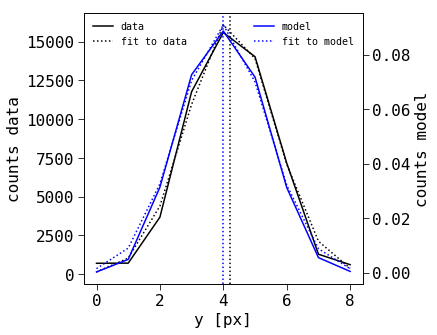

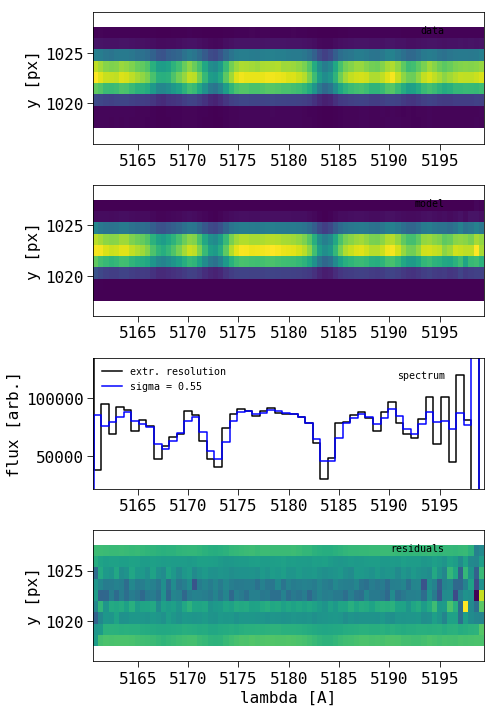

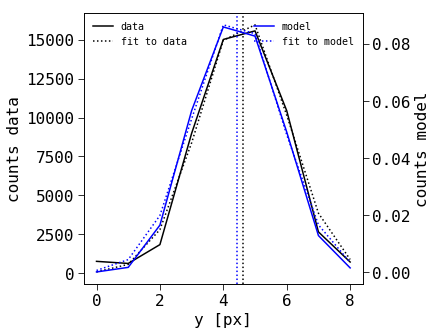

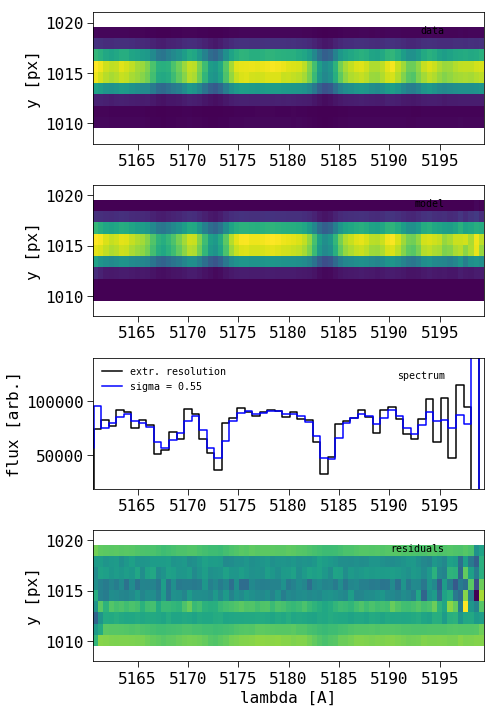

In [171]:
import time
    
def extract(image, fibers, samplef=5, wlstart = 5170., wlstop = 5225., wlc = 5199., xsize = 100, ysize = 9, 
            wlstep = 0.5, fityshift=True, smoothing=0.1, PLOT=True, DEBUG=False, REMOVE_FROM_INPUT=True, fixXoffset=fixXoffset, fixYoffset=fixYoffset, spectra = {}):
    
    for fib in fibers:
        #try:
            print("Extracting fiber {} ...".format(fib)) 
            cx = m_fl2x( fcoord(fib), wlc)
            cy = m_fl2y( fcoord(fib), wlc) 

            minx, maxx = int(cx - xsize/2), int(cx + xsize/2)+1
            miny, maxy = int(cy - ysize/2), int(cy + ysize/2)+1

            subim = image[ miny:maxy,minx:maxx ]
            
            yshift = 0.
            if fityshift:
                print("Computing y-offset ...")

                wlstep_yshift = wlstep*3.
                lowres_models, models, X_os, Y_os, ll = \
                    createLowresModels(minx, maxx, miny, maxy, fib, wlstep_yshift, samplef, wlstart=wlstart, wlstop=wlstop, fixXoffset=fixXoffset, fixYoffset=fixYoffset) 

                model = np.sum(lowres_models,axis=0)
                yshift, ydata, ymodel = fit_yshift(subim, model, PLOT=True)
                
                
                #mux, muy = m_fl2x(fcoord(fib),l)-xoffsets[fib] , m_fl2y(fcoord(fib),l)-yoffsets[fib] + yshift
                    
                print("wlc = {}".format(wlc))
                print("model muy = {}".format(m_fl2y( fcoord(fib), wlc) ))
                
                print("ydata = {}".format(ydata+miny))
                print("ymodel = {}".format(ymodel+miny))
                print("miny = {}".format(miny))

            lowres_models, models, X_os, Y_os, ll = \
                createLowresModels(minx, maxx, miny, maxy, fib, wlstep, samplef, yshift=yshift, wlstart=wlstart, wlstop=wlstop, fixXoffset=fixXoffset, fixYoffset=fixYoffset, DEBUG=False) 
                
            if False:
                # check that residual shift is indeed zero
                model = np.sum(lowres_models,axis=0)
                yshift2, __, __ = fit_yshift(subim, model, PLOT=True)
                
            spectra[fib] = (ll,np.zeros_like(ll)) # in case it fails

            print("Running extraction ...")
            import time
            start_time = time.time()
            #ff, model, RMS = fit_spectrum(subim, lowres_models, ll, smoothing=smoothing)
            ff, model, RMS = fit_spectrumLin(subim, lowres_models, ll, PLOT=False)

            time_to_fit = time.time() - start_time
            print("Time tofit: {:.4e} s".format(time_to_fit))
            spectra[fib] = (ll,ff)
            
            if PLOT:
                plotExtraction(subim, model, ll, ff, m_fx2l( fcoord(fib), minx), m_fx2l( fcoord(fib), maxx), miny, maxy)
                
            print("") 
        #except:
         #   pass
        
        #if REMOVE_FROM_INPUT:
        #    print("Rmoving from input")
        #    image[ miny:maxy, minx:maxx ] -= model 
        #print("")

    return spectra


fibers = np.arange(123,143,1)
fibers = [200,260]
fibers = np.arange(0,267,1)
fibers = [133,134]

# extract of single wavelength/fiber
samplef = 5

# wavelength sampling in A
wlstep = .75
DEBUG = False
xsize = 75
ysize = 9

# central wavelength
#wlstart = 5200.
# for arcs
#wlstart = 5055.
#wlstop = wlstart + 40.
#wlc = (wlstart+wlstop)/2.
# for twi
wlc = 5180.
wlstart = wlc - 25.
wlstop =  wlc + 25.


arc = fits.getdata(farc)
twi = fits.getdata(ftwi)
image = twi[:,:]

REMOVE_FROM_INPUT=False
fityshift=True

smoothing=1.

PLOT=True
fixXoffset=False
fixYoffset=False
    

spectra = extract(image, fibers, samplef, wlstart, wlstop, wlc, xsize, ysize, 
            wlstep, fityshift=fityshift, smoothing=smoothing, PLOT=PLOT, DEBUG=DEBUG, REMOVE_FROM_INPUT=REMOVE_FROM_INPUT,  fixXoffset=fixXoffset, fixYoffset=fixYoffset)

#spectra = extract(image, [260], samplef, wlstart, wlstop, wlc, xsize, ysize, 
#            wlstep, fityshift=fityshift, smoothing=smoothing, PLOT=PLOT, DEBUG=DEBUG, REMOVE_FROM_INPUT=REMOVE_FROM_INPUT,  fixXoffset=fixXoffset, fixYoffset=fixYoffset, spectra=spectra)



(-0.1, 0.1)

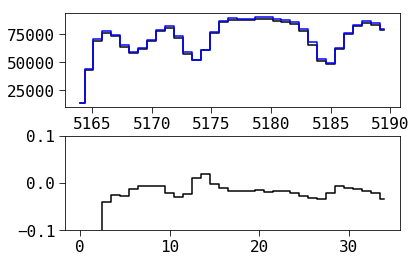

In [196]:

ww = np.arange(-10.,10.+ll[1]-ll[0],ll[1]-ll[0])
g = mfutils.gauss(0.85,.75,ww)
g = g/np.sum(g)

def b(s,g):
    return scipy.signal.fftconvolve(s, g, mode='same')

plt.subplot(2,1,1)
for s in spectra:
    plt.plot(spectra[s][0][12:-20], b( spectra[s][1][12:-20] , g), drawstyle='steps-mid')
    
plt.subplot(2,1,2)
plt.plot( b(spectra[133][1][12:-20]/spectra[134][1][12:-20], g)-1, drawstyle='steps-mid')
plt.ylim(-.1,.1)

In [199]:
import pickle
import os

outfile = 'twi_offsetNotFixed.pkl'
#outfile = 'arc_offsetsFixed.pkl'
#outfile = 'arc_offsetsNOTfixed.pkl'

#save
OVERWRITE = False
if not os.path.exists(outfile) or OVERWRITE:
    with open(outfile, 'wb') as pkl_file: 
        pickle.dump(spectra, pkl_file)
        print("saved.")

In [205]:
outfile = 'twi_offsetFixed.pkl'
#outfile = 'arc_offsetsFixed.pkl'
#outfile = 'arc_offsetsNOTfixed.pkl'

if True:
    import pickle
    # load
    with open(outfile, 'rb') as pkl_file:
        spectra = pickle.load(pkl_file)

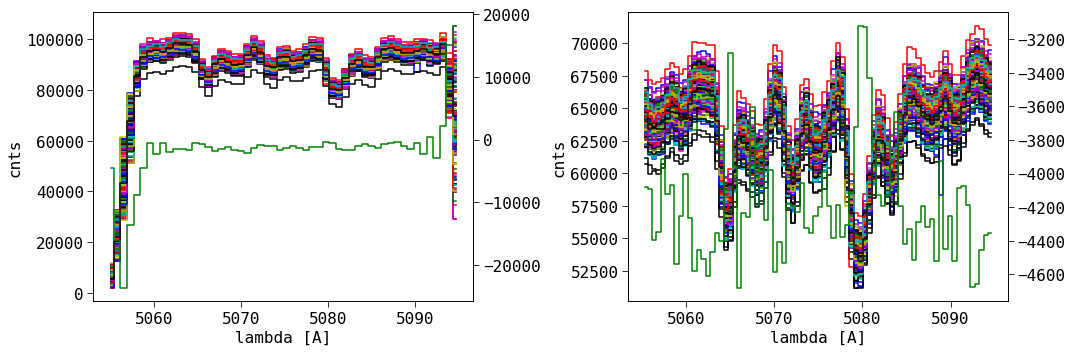

In [206]:
# plot spectra
import scipy
import spectrum

kk = spectra.keys()

f = plt.figure(figsize=[15,5])
plt.subplot(1,2,1)
ll = spectra[kk[0]][0]
ww = np.arange(-10.,10.+ll[1]-ll[0],ll[1]-ll[0])
g = mfutils.gauss(0.85,.75,ww)
g = g/np.sum(g)
bff = []

for s in spectra:
    bf = scipy.signal.fftconvolve(spectra[s][1], g, mode='same')*a
    bff.append(bf)


    plt.plot(ll, bf,drawstyle='steps-mid')
#plt.plot(ll, bff[1],drawstyle='steps-mid')

plt.ylabel("cnts")
plt.xlabel("lambda [A]")
#plt.ylim([-100.,700.])
plt.twinx()
plt.plot(ll, bff[132]-bff[160],'g-',drawstyle='steps-mid')
#plt.ylim([-30.,200.])

#plt.ylim([-1e-4,1e-4])

plt.subplot(1,2,2)

sfe = spectrum.readSpectrum( "redux/20170327/Femastertwi.fits.gz" )
#sfe = spectrum.readSpectrum( "redux/20170327/Femasterarc.fits.gz" )

ii = (np.exp(sfe.grid())>=ll[0]) * (np.exp(sfe.grid())<=ll[-1])
feff = []
for s in spectra:
    #print s
    feff.append(sfe.data[s])
    plt.plot(np.exp( sfe.grid()[ii] ), feff[-1][ii],drawstyle='steps-mid')
    
plt.ylabel("cnts")
plt.xlabel("lambda [A]")
#plt.ylim([-100.,700.])
plt.twinx()
plt.plot( np.exp(sfe.grid())[ii], (feff[0] - feff[-1]*aa[-1])[ii],'g-',drawstyle='steps-mid')
#plt.ylim([-30.,200.])



sum(ii)
f.tight_layout()

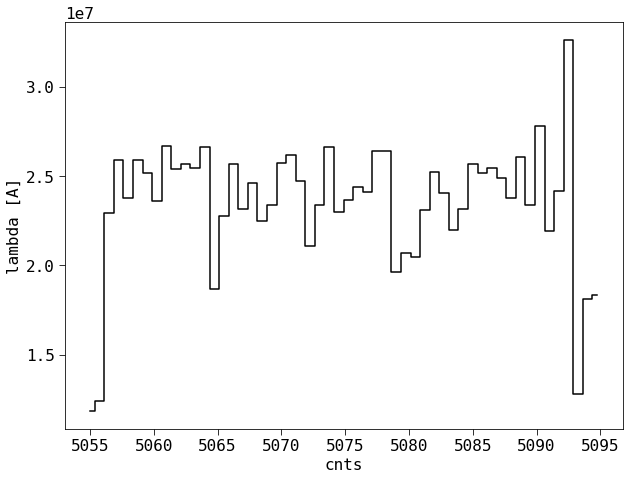

In [207]:
# plot binned spectrum
#for f in spectra[0]:
#    ll = spectra[f][0]
    
ff = np.zeros_like(ll)
for f in spectra:
    ff += spectra[f][1] 
    
f = plt.figure(figsize=[10,7.5])
plt.plot(ll,ff,drawstyle='steps-mid')

plt.xlabel("cnts")
plt.ylabel("lambda [A]")  



In [208]:
# show extracted spectra in ds9
import pysao
ds9 = pysao.ds9()

ds9.view( np.vstack( [spectra[f][1] for f in spectra] ))

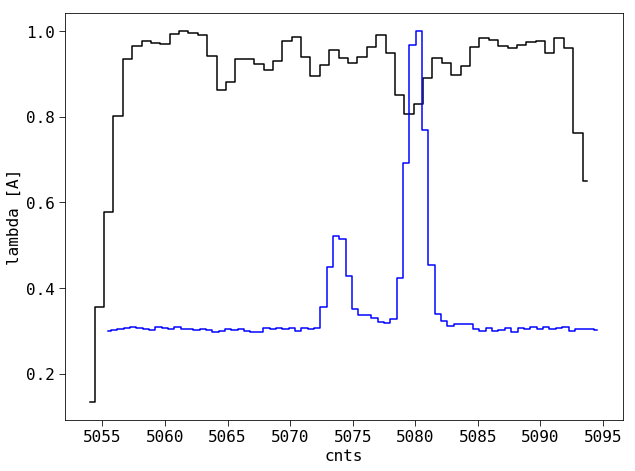

In [209]:
# bin spectra, broaden to ~original resolution and plot
import spectrum
import scipy
from mfutils import gauss

fespectra = fearc

s = spectrum.readSpectrum(fFearc)
ii = ( np.exp(s.grid()) > ll[0]) * ( np.exp(s.grid()) < ll[-1])

ff = np.zeros_like(ll)
for f in spectra:
    ff += spectra[f][1]
    
f = plt.figure(figsize=[10,7.5])

ll_fibext = np.exp(s.grid()[ii])
ff_fibext = np.mean(fespectra[130:140,ii],axis=0)

ww = np.arange(-10.,10.+ll[1]-ll[0],ll[1]-ll[0])
g = gauss(0.5,.7,ww)
bff = scipy.signal.fftconvolve(ff, g, mode='same')

plt.plot(ll-1.,bff/bff.max(),drawstyle='steps-mid')
plt.plot( ll_fibext, ff_fibext/ff_fibext.max() , drawstyle='steps-mid')

plt.xlabel("cnts")
plt.ylabel("lambda [A]")  



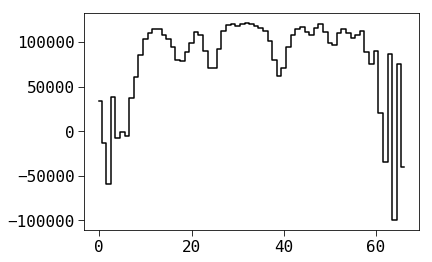

In [162]:
# show extracted spectra in ds9
ww = np.arange(-10.,10.+ll[1]-ll[0],ll[1]-ll[0])
g = gauss(0.5,.7,ww)

im = np.vstack([scipy.signal.fftconvolve(spectra[f][1], g, mode='same') for f in spectra])
nim = np.zeros_like(im)

plt.plot(im[10,:] , drawstyle='steps-mid')

In [210]:
import pysao
ds9 = pysao.ds9()

# normalize by column
for i in xrange(im.shape[1]):
    n = np.mean(im[:,i])
    nim[:,i] = im[:,i] - n
  
ww = np.arange(-10.,10.+ll[1]-ll[0],ll[1]-ll[0])
g = gauss(0.5,.7,ww)

t = spectrum.readSpectrum(fFetwi)
ii = ( np.exp(t.grid()) > ll[0]) * ( np.exp(t.grid()) < ll[-1])

nfetwi = np.zeros_like(t.data[:,ii])
# normalize by column
for i in xrange(t.data[:,ii].shape[1]):
    n = np.mean(t.data[:266,ii][:,i])
    nfetwi[:,i] = t.data[:,ii][:,i]/n
    
ds9.frame(1)
ds9.view(im)
ds9.frame(2)
ds9.view(t.data[:,ii])
ds9.frame(3)
ds9.view(nim)
ds9.frame(4)
ds9.view(nfetwi)

###

In [211]:
import pysao
ds9 = pysao.ds9()

ww = np.arange(-10.,10.+ll[1]-ll[0],ll[1]-ll[0])
g = gauss(0.5,.7,ww)

# show extracted spectra in ds9
im = np.vstack([scipy.signal.fftconvolve(spectra[f][1], g, mode='same') for f in spectra])


In [212]:
nim = np.zeros_like(im)

# normalize by column
for i in xrange(im.shape[1]):
    n = np.mean(im[:,i])
    nim[:,i] = im[:,i] - n
  
nfearc = np.zeros_like(fearc[:,ii])
# normalize by column
for i in xrange(fearc[:,ii].shape[1]):
    n = np.mean(fearc[:266,ii][:,i])
    nfearc[:,i] = fearc[:,ii][:,i] - n

ds9.frame(1)
ds9.view(nim)
ds9.frame(2)
ds9.view(nfearc)

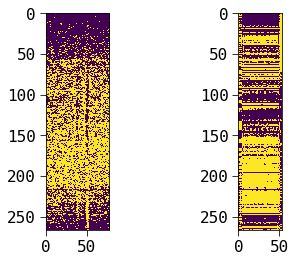

In [213]:
plt.subplot(1,2,1)
plt.imshow(nfearc, vmin=0.8,vmax=1.2)
plt.subplot(1,2,2)
plt.imshow(nim, vmin=0.8,vmax=1.2)


# Old Stuff

In [ ]:

from astropy.table import Table, Column
t = Table(
    names=["wl","fib","A", "BG", "mux", "muy", "sigmax", "sigmay", "sigmaxy", "tA", "RMS"],
    dtype=('f4', 'i4', 'f4', 'f4', 'f4', 'f4', 'f4', 'f4', 'f4', 'f4', 'f4'))

# all good
goodpeaks = [1,4,5,6,8,11,12,13,14,15,16,17,18,19,20,21]
#smaller subrange
goodpeaks = [5,6,8,11,12,13,14]

#arcpeaks[1068+267]
xw = 13
yw = 9

wlmin, wlmax = 4900,5350.
#fmin,fmax = 1,266
fmin,fmax = 160,161

fibers = np.arange(fmin,fmax, dtype=int)
fibers = np.arange(0,267,20, dtype=int)


for i,l in  enumerate(arcpeaks_dict):
    

    print("Wavelength {}, {}".format(i,l))
    #if not (l >= wlmin and l <= wlmax):
    if not i in goodpeaks:
        print("Skipping, not in goodpeaks")
        continue
    for fib in fibers:
        P0 = [   6.33 , 38.31, (xw-1.)/2.+xmin,  (yw-1.)/2.+ymin,   0.6, 0.6,  -0.0, 20.]
        # establish small subregion around arcpeak
        xc,yc = arcpeaks_dict[l][fib]
        ystart, ystop = int(round(yc)-yw/2.),int(round(yc)+yw/2.)
        xstart, xstop = int(round(xc)-xw/2.),int(round(xc)+xw/2.)
        subim = arc[ ystart:ystop , xstart:xstop ]
                    
        ymin,ymax = int(round(yc)-yw/2.),int(round(yc)+yw/2.)

        xx = np.arange(xstart, xstop)
        yy = np.arange(ystart, ystop)
        X,Y = np.meshgrid(xx,yy)

        # run fit
        print("WL {} Fiber {}".format(l,fib))
        #try:


        fit = least_squares(resid,P0, args = (X,Y,subim, dsubim, samplef) )
        p = fit.x

        f = plt.figure(figsize=[15,5])

        X_os,Y_os = oversampleGrid(X,Y,samplef = samplef)
        highres_model = peval(p, X_os,Y_os, samplef)
        lowres_model =  downsampleData(xx, yy, X_os, Y_os, highres_model)


        res = resid(p, X, Y, subim, dsubim, samplef)
        print ("RMS =  {:.4f}".format(np.std(res)))


        A, BG, mux, muy, sigmax, sigmay, sigmaxy, tA = fit.x 

        print("A ={:.3f}, BG ={:.2f}, mux = {:.3f}, muy = {:.3f}, sigmax = {:.3f}, sigmay = {:.3f}, sigmaxy ={:.3f}".\
              format(A, BG, mux, muy, sigmax, sigmay, sigmaxy))


        r = (l, fib, A, BG, mux, muy, sigmax, sigmay, sigmaxy, tA, RMS)
        t.add_row(r)
        print("wl ={:.3f}, fib ={:d}, A ={:.3f}, BG ={:.2f}, mux = {:.3f}, muy = {:.3f}, sigmax = {:.3f}, sigmay = {:.3f}, sigmaxy ={:.3f},  tA ={:.3f}, RMS ={:.3f}".\
              format(r[0],r[1],r[2],r[3],r[4],r[5],r[6],r[7],r[8],r[9],r[10]))
        #except:
            #pass
        print("")
        
        